<a href="https://colab.research.google.com/github/Fermu25/Cursos/blob/main/Proyecto_TSFCII_Entregable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Identificación del número completo de la fachada de las viviendas

Se empleará el **"The Street View House Numbers (SVHN) Dataset"**

El conjunto de datos SVHN, derivado de imágenes de Google Street View, contiene más de 600,000 imágenes de dígitos

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Rutas
ZIP_PATH    = "/content/drive/MyDrive/Proyecto-TSFCII/archive.zip"
EXTRACT_DIR = "/content/svhn_zip"

import os, zipfile
os.makedirs(EXTRACT_DIR, exist_ok=True)

# Extraer base de datos
if not os.path.exists(os.path.join(EXTRACT_DIR, "archive")):
    with zipfile.ZipFile(ZIP_PATH, "r") as zf:
        zf.extractall(EXTRACT_DIR)

print("ZIP extraído en:", EXTRACT_DIR)
print("Contenido:", os.listdir(EXTRACT_DIR))


ZIP extraído en: /content/svhn_zip
Contenido: ['test', 'extra', 'test_digitStruct.mat', 'extra_digitStruct.mat', 'train', 'train_digitStruct.mat']


In [3]:
#CONFIGURACIÓN
import os, re, unicodedata
from pathlib import Path

# Raíz donde se descomprime SVHN, con estructura:
#   /content/svhn_zip/
#       ├─ train/train/*.png
#       ├─ extra/extra/*.png
#       ├─ test/test/*.png
#       ├─ train_digitStruct.mat
#       ├─ extra_digitStruct.mat
#       └─ test_digitStruct.mat

SVHN_ROOT = "/content/svhn_zip"

# Dónde se crea el dataset para entrenar YOLO
YOLO_OUT  = "/content/svhn_yolo_dataset"

# Mapa split
SPLIT_DIRS = {
    "train": f"{SVHN_ROOT}/train/train",
    "test":  f"{SVHN_ROOT}/test/test",
    "extra": f"{SVHN_ROOT}/extra/extra",
}

# Saneador robusto (quita nulls/espacios invisibles y normaliza separadores)
_WS = re.compile(r'[\s\u00A0\u2000-\u200B\u202F\u205F\u3000\uFEFF]+')
def sanitize_name(s: str) -> str:
    s = unicodedata.normalize("NFKC", s or "")
    s = s.replace("\x00", "")
    s = _WS.sub("", s)
    s = s.strip(' "\'')
    return s.replace("\\", "/")


In [4]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.4 MB/s eta 0:00:00


In [ ]:
# ================== LECTURA + SANITIZADO DESDE LA RAÍZ ==================
import os, csv, re, unicodedata
import h5py
import numpy as np
from pathlib import Path
from PIL import Image

# <<< AJUSTA SOLO ESTA RAÍZ >>>
SVHN_ROOT = "/content/svhn_zip"  # SIN 'archive'

# Mapear split -> carpeta REAL con imágenes (SIN 'archive')
# (tu estructura es .../extra/extra, .../train/train, .../test/test)
SPLIT_DIRS = {
    "train": f"{SVHN_ROOT}/train/train",
    "extra": f"{SVHN_ROOT}/extra/extra",
    "test":  f"{SVHN_ROOT}/test/test",
}

# -------- SANEADOR (se aplica en _read_name) --------
_WS = re.compile(r'[\s\u00A0\u2000-\u200B\u202F\u205F\u3000\uFEFF]+')  # spaces, NBSP, ZWSP, BOM…

def sanitize_name(s: str) -> str:
    """Normaliza unicode y ELIMINA todos los blancos/invisibles/NULLs y comillas sueltas."""
    s = unicodedata.normalize("NFKC", s or "")
    s = s.replace("\x00", "")
    s = _WS.sub("", s)          # <- AQUÍ quitamos blancos/invisibles
    s = s.strip(' "\'')
    s = s.replace("\\", "/")
    return s

# --------- Lectores de digitStruct.mat (con saneado al LEER) ---------
def _read_name(f, names, i):
    """Lee el nombre i-ésimo, lo DECODIFICA y lo Sanea YA aquí."""
    ref = names[i][0]
    arr = f[ref][:]
    try:
        raw = bytes(arr).decode("utf-8")
    except Exception:
        raw = "".join(chr(int(c)) for c in arr.flatten())
    return sanitize_name(raw)   # <<< SANEAR AQUÍ >>>

def _read_list(f, box, key):
    dset = box[key]
    if dset.shape[0] == 1:
        return [float(dset[0][0])]
    vals = []
    for j in range(dset.shape[0]):
        ref = dset[j][0]
        vals.append(float(f[ref][0][0]))
    return vals

def read_digit_struct_pairs(mat_path, subdir):
    """
    Devuelve [( 'split/filename.png', 'secuencia' )].
    subdir es 'train' | 'extra' | 'test' (SIN 'archive', SIN duplicar split).
    """
    pairs = []
    with h5py.File(mat_path, "r") as f:
        ds = f["digitStruct"]
        names = ds["name"]
        bboxes = ds["bbox"]
        for i in range(len(names)):
            name = _read_name(f, names, i)    # ya saneado
            box  = f[bboxes[i][0]]
            left  = np.array(_read_list(f, box, "left"))
            label = np.array(_read_list(f, box, "label"), dtype=int)
            label = np.where(label==10, 0, label)  # 10 -> 0

            order = np.argsort(left)
            seq = "".join(str(int(label[j])) for j in order)
            # <<< SOLO 'split/filename' >>>
            pairs.append((f"{subdir}/{name}", seq))
    return pairs

def read_digit_struct_boxes(mat_path, subdir):
    """
    Devuelve filas por dígito: ('split/filename', x, y, w, h, label, order)
    """
    rows = []
    with h5py.File(mat_path, "r") as f:
        ds = f["digitStruct"]
        names = ds["name"]
        bboxes = ds["bbox"]
        for i in range(len(names)):
            name = _read_name(f, names, i)    # ya saneado
            box  = f[bboxes[i][0]]

            left  = np.array(_read_list(f, box, "left"))
            top   = np.array(_read_list(f, box, "top"))
            width = np.array(_read_list(f, box, "width"))
            height= np.array(_read_list(f, box, "height"))
            label = np.array(_read_list(f, box, "label"), dtype=int)
            label = np.where(label==10, 0, label)

            order = np.argsort(left)
            for rank, j in enumerate(order, start=1):
                rows.append((
                    f"{subdir}/{name}",            # <<< SOLO 'split/filename'
                    float(left[j]), float(top[j]),
                    float(width[j]), float(height[j]),
                    int(label[j]), int(rank)
                ))
    return rows

# --------- Generación de CSVs relativos (SIN 'archive') ---------
CSV_SEQ_TRAIN = os.path.join(SVHN_ROOT, "labels_train_extra.csv")
CSV_SEQ_TEST  = os.path.join(SVHN_ROOT, "labels_test.csv")
CSV_BOX_TRAIN = os.path.join(SVHN_ROOT, "labels_train_extra_boxes.csv")
CSV_BOX_TEST  = os.path.join(SVHN_ROOT, "labels_test_boxes.csv")

# (A) Secuencias
pairs_train = []
for split in ["train", "extra"]:
    matf = os.path.join(SVHN_ROOT, f"{split}_digitStruct.mat")
    pairs_train.extend(read_digit_struct_pairs(matf, split))

with open(CSV_SEQ_TRAIN, "w", newline="") as f:
    w = csv.writer(f); w.writerow(["filename","label"])
    w.writerows(pairs_train)

pairs_test = read_digit_struct_pairs(os.path.join(SVHN_ROOT, "test_digitStruct.mat"), "test")
with open(CSV_SEQ_TEST, "w", newline="") as f:
    w = csv.writer(f); w.writerow(["filename","label"])
    w.writerows(pairs_test)

# (B) Cajas
rows_train = []
for split in ["train","extra"]:
    matf = os.path.join(SVHN_ROOT, f"{split}_digitStruct.mat")
    rows_train.extend(read_digit_struct_boxes(matf, split))

with open(CSV_BOX_TRAIN, "w", newline="") as f:
    w = csv.writer(f); w.writerow(["filename","x","y","w","h","label","order"])
    w.writerows(rows_train)

rows_test = read_digit_struct_boxes(os.path.join(SVHN_ROOT, "test_digitStruct.mat"), "test")
with open(CSV_BOX_TEST, "w", newline="") as f:
    w = csv.writer(f); w.writerow(["filename","x","y","w","h","label","order"])
    w.writerows(rows_test)

print("✅ CSVs escritos:",
      "\n  -", CSV_SEQ_TRAIN,
      "\n  -", CSV_SEQ_TEST,
      "\n  -", CSV_BOX_TRAIN,
      "\n  -", CSV_BOX_TEST)

# --------- Resolver relativo -> absoluto (usa SOLO extra/extra, sin 'archive') ---------
def resolve_path_from_csv(rel_path: str, split_dirs: dict) -> Path:
    rel_path = sanitize_name(rel_path)      # por si viniera sucio del CSV
    rel_path = rel_path.replace("\\", "/")
    parts = rel_path.split("/", 1)
    assert len(parts) == 2, f"Ruta mal formada en CSV: {rel_path}"
    split, rest = parts[0], parts[1]
    base = split_dirs[split]                # p.ej. '/content/svhn_zip/extra/extra'
    return Path(base) / rest

# --------- Chequeo rápido de 10 rutas ---------
with open(CSV_SEQ_TRAIN, "r") as f:
    rows = list(csv.reader(f))[1:]

ok = 0
for rel, _ in rows[:10]:
    p = resolve_path_from_csv(rel, SPLIT_DIRS)
    print("→", p, "exists:", p.exists())
    if p.exists():
        Image.open(p).convert("RGB")
        ok += 1
print(f"✔️ abiertas {ok}/10 sin error")

In [ ]:
# ==========================================
# 1) VISUALIZACIÓN DESDE MAT (cajas + texto)
# ==========================================
import h5py, numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def _read_name(f, names, i):
    ref = names[i][0]
    arr = f[ref][:]
    try:
        return sanitize_name(bytes(arr).decode("utf-8"))
    except Exception:
        return sanitize_name("".join(chr(int(c)) for c in arr.flatten()))

def _read_list(f, box, key):
    dset = box[key]
    if dset.shape[0] == 1:
        return [float(dset[0][0])]
    vals = []
    for j in range(dset.shape[0]):
        ref = dset[j][0]
        vals.append(float(f[ref][0][0]))
    return vals

def read_digit_struct_boxes(mat_path, split):
    """
    Devuelve filas por dígito:
      (rel_path, x, y, w, h, label, order)
    con label==10 -> 0 y 'order' izquierda→derecha.
    rel_path = 'train/XXXXX.png' | 'test/XXXXX.png' | 'extra/XXXXX.png'
    """
    rows = []
    with h5py.File(mat_path, "r") as f:
        ds = f["digitStruct"]
        names = ds["name"]
        bboxes = ds["bbox"]
        N = len(names)
        for i in range(N):
            name = _read_name(f, names, i)
            box  = f[bboxes[i][0]]

            left   = np.array(_read_list(f, box, "left"))
            top    = np.array(_read_list(f, box, "top"))
            width  = np.array(_read_list(f, box, "width"))
            height = np.array(_read_list(f, box, "height"))
            label  = np.array(_read_list(f, box, "label"), dtype=int)
            label  = np.where(label==10, 0, label)  # mapping SVHN: 10 => '0'

            order = np.argsort(left)
            rel_path = f"{split}/{name}"
            for rank, j in enumerate(order, start=1):
                rows.append((rel_path, float(left[j]), float(top[j]),
                             float(width[j]), float(height[j]),
                             int(label[j]), int(rank)))
    return rows

def resolve_abs_from_rel(rel_path: str, split_dirs: dict) -> Path:
    """'train/1.png' -> absoluto usando SPLIT_DIRS."""
    rel_path = sanitize_name(rel_path)
    parts = rel_path.split("/", 1)
    assert len(parts) == 2 and parts[0] in split_dirs, f"Ruta mal formada: {rel_path}"
    split, rest = parts
    return Path(split_dirs[split]) / rest

def show_one_example(idx, split="train"):
    assert split in ("train","test","extra")
    mat_path = os.path.join(SVHN_ROOT, f"{split}_digitStruct.mat")
    assert os.path.exists(mat_path), f"No existe: {mat_path}"

    # Leemos filas por dígito y agrupamos por imagen
    rows = read_digit_struct_boxes(mat_path, split)
    by_img = {}
    for (fn,x,y,w,h,lab,order) in rows:
        by_img.setdefault(fn, []).append((x,y,w,h,lab,order))

    files = sorted(by_img.keys())
    assert 0 <= idx < len(files), f"idx fuera de rango (0..{len(files)-1})"

    rel = files[idx]
    p = resolve_abs_from_rel(rel, SPLIT_DIRS)
    assert p.exists(), f"No existe el archivo: {p}"

    img = Image.open(p).convert("RGB")
    arr = np.array(img)

    # Ordenar por 'order' y armar secuencia
    b = sorted(by_img[rel], key=lambda t: t[5])
    seq = "".join(str(int(lab)) for (_,_,_,_,lab,_) in b)

    # Dibujar
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    ax.imshow(arr)
    for (x,y,w,h,lab,ordr) in b:
        rect = patches.Rectangle((x,y), w,h, linewidth=1.5, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, max(0,y-3), f"{lab}", color='yellow', fontsize=12,
                bbox=dict(facecolor='black', alpha=0.6, pad=1))
    ax.set_title(f"{split}: {rel} — '{seq}'", fontsize=12)
    ax.axis('off')
    plt.show()
    print("🔢 Secuencia (L→R):", seq)


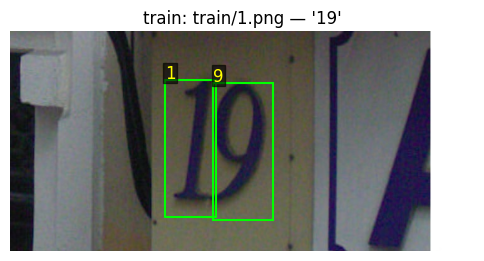

🔢 Secuencia (L→R): 19


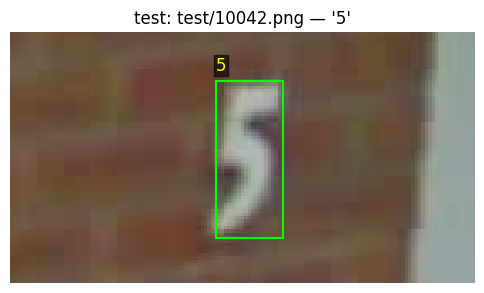

🔢 Secuencia (L→R): 5


KeyboardInterrupt: 

In [ ]:
# Unas pruebas
show_one_example(0,   "train")
show_one_example(50,  "test")
show_one_example(200, "extra")


In [5]:
# =======================================
# 2) CONVERSIÓN SVHN → YOLO (con saneado)
# =======================================
import h5py, shutil
from PIL import Image

def asegurar_dir(p): os.makedirs(p, exist_ok=True)

def leer_digit_struct(mat_path):
    """
    Lee digitStruct.mat y devuelve una lista de anotaciones por imagen:
    [{'name': '1.png', 'labels':[...], 'left':[...], 'top':[...], 'width':[...], 'height':[...]}]
    (con 'name' ya saneado)
    """
    out = []
    with h5py.File(mat_path, 'r') as f:
        names  = f['digitStruct']['name']
        bboxes = f['digitStruct']['bbox']

        def _get_name(i):
            ref = names[i][0]
            arr = f[ref][:]
            try:    return sanitize_name(bytes(arr).decode('utf-8'))
            except: return sanitize_name(''.join(chr(int(c)) for c in arr.flatten()))

        def _get_list(bb, key):
            dset = bb[key]
            if dset.shape[0] == 1:
                return [float(dset[0][0])]
            vals = []
            for j in range(dset.shape[0]):
                ref = dset[j][0]
                vals.append(float(f[ref][0][0]))
            return vals

        for i in range(len(names)):
            name = _get_name(i)
            bb   = f[bboxes[i][0]]
            labels = [int(x) for x in _get_list(bb, 'label')]
            left   = _get_list(bb, 'left')
            top    = _get_list(bb, 'top')
            width  = _get_list(bb, 'width')
            height = _get_list(bb, 'height')
            out.append({
                'name': name, 'labels': labels,
                'left': left, 'top': top, 'width': width, 'height': height
            })
    return out

def convertir_split_svhn_a_yolo(split_svhn, split_yolo):
    """
    split_svhn: 'train' | 'extra' | 'test'
    split_yolo: 'train' | 'val'
    Crea estructura:
      YOLO_OUT/
        images/<split_yolo>/*.png
        labels/<split_yolo>/*.txt
    Cada .txt contiene líneas: class x_center y_center width height (normalizados)
    """
    print(f"→ Procesando SVHN '{split_svhn}' → YOLO '{split_yolo}'")
    dir_imgs = os.path.join(SPLIT_DIRS[split_svhn])           # p.ej. .../train/train
    mat_path = os.path.join(SVHN_ROOT, f"{split_svhn}_digitStruct.mat")
    assert os.path.isfile(mat_path), f"No existe: {mat_path}"

    ann = leer_digit_struct(mat_path)
    out_img = os.path.join(YOLO_OUT, "images", split_yolo)
    out_lbl = os.path.join(YOLO_OUT, "labels", split_yolo)
    asegurar_dir(out_img); asegurar_dir(out_lbl)

    for i, a in enumerate(ann):
        nombre_origen = a['name']                  # p.ej. "123.png"
        base = f"{split_svhn}_{nombre_origen}"     # evita colisiones entre splits
        src  = os.path.join(dir_imgs, nombre_origen)
        dst  = os.path.join(out_img, base)

        if not os.path.isfile(src):
            # Puede ocurrir algún faltante aislado; lo saltamos.
            continue

        shutil.copy2(src, dst)                     # copia imagen

        with Image.open(src) as im:
            w_img, h_img = im.size

        # Escribir etiquetas YOLO
        lbl_path = os.path.join(out_lbl, os.path.splitext(base)[0] + ".txt")
        with open(lbl_path, "w") as f:
            for lab, L, T, W, H in zip(a['labels'], a['left'], a['top'], a['width'], a['height']):
                # SVHN: 10 => dígito 0
                digit = 0 if int(lab)==10 else int(lab)
                cx = (L + W/2.0) / w_img
                cy = (T + H/2.0) / h_img
                wn = W / w_img
                hn = H / h_img
                f.write(f"{digit} {cx:.6f} {cy:.6f} {wn:.6f} {hn:.6f}\n")

        if (i+1) % 5000 == 0:
            print(f"  {i+1}/{len(ann)} imágenes...")

    print(f"✔ Split '{split_svhn}' → '{split_yolo}' listo. Imágenes: {len(ann)}")

def escribir_yaml_ultralytics():
    """Genera svhn_yolo.yaml para entrenar con Ultralytics YOLO."""
    yaml_path = os.path.join(YOLO_OUT, "svhn_yolo.yaml")
    content = f"""# Dataset SVHN en formato YOLO
path: {YOLO_OUT}
train: images/train
val: images/val
nc: 10
names: ["0","1","2","3","4","5","6","7","8","9"]
"""
    with open(yaml_path, "w") as f:
        f.write(content)
    print("✔ YAML escrito en:", yaml_path)

# Ejecutar conversión (train+extra → train, test → val)
os.makedirs(os.path.join(YOLO_OUT, "images", "train"), exist_ok=True)
os.makedirs(os.path.join(YOLO_OUT, "images", "val"),   exist_ok=True)
os.makedirs(os.path.join(YOLO_OUT, "labels", "train"), exist_ok=True)
os.makedirs(os.path.join(YOLO_OUT, "labels", "val"),   exist_ok=True)

for split in ["train", "extra"]:
    convertir_split_svhn_a_yolo(split, "train")

convertir_split_svhn_a_yolo("test", "val")
escribir_yaml_ultralytics()


→ Procesando SVHN 'train' → YOLO 'train'


KeyboardInterrupt: 

In [ ]:
# ==============================================
# 3) VERIFICACIÓN RÁPIDA (MAT vs TXT de YOLO)
# ==============================================
import random

def verificar_un_ejemplo_yolo(split_svhn="test"):
    """
    Toma una imagen aleatoria del split y verifica que su .txt YOLO
    coincide (aprox) con las cajas del .mat.
    """
    dir_imgs = SPLIT_DIRS[split_svhn]
    mat_path = os.path.join(SVHN_ROOT, f"{split_svhn}_digitStruct.mat")
    ann = leer_digit_struct(mat_path)
    a = random.choice(ann)

    base = f"{split_svhn}_{a['name']}"
    sub = "val" if split_svhn=="test" else "train"
    yolo_txt = os.path.join(YOLO_OUT, "labels", sub, os.path.splitext(base)[0] + ".txt")
    img_path = os.path.join(dir_imgs, a['name'])

    assert os.path.exists(yolo_txt), f"Falta etiqueta YOLO: {yolo_txt}"
    assert os.path.exists(img_path), f"Falta imagen: {img_path}"

    from PIL import Image
    w_img, h_img = Image.open(img_path).size

    with open(yolo_txt, "r") as f:
        yolo_lines = [l.strip() for l in f.readlines() if l.strip()]

    ok = True
    for i, (lab, L, T, W, H) in enumerate(zip(a['labels'], a['left'], a['top'], a['width'], a['height'])):
        digit = 0 if int(lab)==10 else int(lab)
        cx = (L + W/2.0) / w_img
        cy = (T + H/2.0) / h_img
        wn = W / w_img
        hn = H / h_img

        # Buscamos ANY línea compatible dentro de una tolerancia por redondeos
        match = any(
            line.startswith(f"{digit} ") and
            all(abs(float(tok) - val) < 1e-2 for tok, val in zip(line.split()[1:], [cx, cy, wn, hn]))
            for line in yolo_lines
        )
        if not match:
            ok = False
            print("❌ Desajuste en bbox", i, "| esperado:",
                  f"class={digit}, cx={cx:.4f}, cy={cy:.4f}, w={wn:.4f}, h={hn:.4f}")

    print("✅ Verificación YOLO vs MAT:", "OK" if ok else "HAY DIFERENCIAS")

# USO:
verificar_un_ejemplo_yolo("test")   # o "train"/"extra"


✅ Verificación YOLO vs MAT: OK


In [ ]:
# ============================================================
# YOLOv8: (opcional) convertir SVHN → dataset YOLO + entrenamiento
# ============================================================
import os, re, unicodedata
import numpy as np
from PIL import Image
import h5py

# ----------------- CONFIG -----------------
RAIZ_SVHN   = "/content/svhn_zip"               # raíz REAL (sin 'archive')
SALIDA_YOLO = "/content/svhn_yolo_dataset"      # carpeta del dataset YOLO
DATA_YAML   = os.path.join(SALIDA_YOLO, "svhn_yolo.yaml")

# Si YA convertiste a YOLO, pon esto en False para saltar conversión
RUN_CONVERSION = True   # <----- cambia a True SOLO si aún no tienes el dataset YOLO

# Entrenamiento YOLOv8
PESOS_BASE   = "yolov8n.pt"     # puedes cambiar a yolov8s.pt, etc.
EPOCAS       = 50 #subir a 100 epocas, 50 no son suficientes, pero bastan por ahora
IMG_SIZE     = 128
BATCH        = 64
NOMBRE_RUN   = "svhn_yolov8n"

# ----------------- SANEADOR -----------------
_WS = re.compile(r'[\s\u00A0\u2000-\u200B\u202F\u205F\u3000\uFEFF]+')
def sanitize_name(s: str) -> str:
    s = unicodedata.normalize("NFKC", s or "")
    s = s.replace("\x00", "")
    s = _WS.sub("", s)
    s = s.strip(' "\'')
    return s.replace("\\", "/")

# ----------------- LECTOR digitStruct.mat -----------------
def leer_digit_struct(mat_path):
    out = []
    with h5py.File(mat_path, 'r') as f:
        names  = f['digitStruct']['name']
        bboxes = f['digitStruct']['bbox']

        def _get_name(i):
            ref = names[i][0]
            arr = f[ref][:]
            try:
                return sanitize_name(bytes(arr).decode('utf-8'))
            except:
                return sanitize_name(''.join(chr(int(c)) for c in arr.flatten()))

        def _get_list(bb, key):
            dset = bb[key]
            if dset.shape[0] == 1:
                return [float(dset[0][0])]
            vals = []
            for j in range(dset.shape[0]):
                ref = dset[j][0]
                vals.append(float(f[ref][0][0]))
            return vals

        for i in range(len(names)):
            name = _get_name(i)
            bb   = f[bboxes[i][0]]
            labels = [int(x) for x in _get_list(bb, 'label')]
            left   = _get_list(bb, 'left')
            top    = _get_list(bb, 'top')
            width  = _get_list(bb, 'width')
            height = _get_list(bb, 'height')
            out.append({
                'name': name, 'labels': labels,
                'left': left, 'top': top, 'width': width, 'height': height
            })
    return out

# ----------------- CONVERSIÓN → YOLO -----------------
def asegurar_dir(p): os.makedirs(p, exist_ok=True)

def convertir_split_svhn_a_yolo(split_svhn, split_yolo):
    """
    Crea:
      SALIDA_YOLO/images/<split_yolo>/*.png
      SALIDA_YOLO/labels/<split_yolo>/*.txt
    """
    print(f"→ Procesando SVHN '{split_svhn}' → YOLO '{split_yolo}'")
    dir_imgs = os.path.join(RAIZ_SVHN, split_svhn, split_svhn)  # p.ej. .../train/train
    mat_path = os.path.join(RAIZ_SVHN, f"{split_svhn}_digitStruct.mat")
    assert os.path.isfile(mat_path), f"No existe: {mat_path}"
    ann = leer_digit_struct(mat_path)

    out_img = os.path.join(SALIDA_YOLO, "images", split_yolo)
    out_lbl = os.path.join(SALIDA_YOLO, "labels", split_yolo)
    asegurar_dir(out_img); asegurar_dir(out_lbl)

    for i, a in enumerate(ann):
        base = f"{split_svhn}_{a['name']}"           # prefijo para evitar colisiones
        src  = os.path.join(dir_imgs, a['name'])
        dst  = os.path.join(out_img, base)
        if not os.path.isfile(src):
            continue
        # copiar/guardar imagen
        Image.open(src).save(dst)

        w_img, h_img = Image.open(src).size
        # escribir .txt YOLO
        lbl_path = os.path.join(out_lbl, os.path.splitext(base)[0] + ".txt")
        with open(lbl_path, "w") as f:
            for lab, L, T, W, H in zip(a['labels'], a['left'], a['top'], a['width'], a['height']):
                digit = 0 if int(lab)==10 else int(lab)  # SVHN: 10 -> 0
                cx = (L + W/2.0) / w_img
                cy = (T + H/2.0) / h_img
                wn = W / w_img
                hn = H / h_img
                f.write(f"{digit} {cx:.6f} {cy:.6f} {wn:.6f} {hn:.6f}\n")

        if (i+1) % 5000 == 0:
            print(f"  {i+1}/{len(ann)} imágenes...")

    print(f"✔ Split '{split_svhn}' → '{split_yolo}' listo. Imágenes: {len(ann)}")

def escribir_yaml_ultralytics():
    content = f"""# Dataset SVHN en formato YOLO (Ultralytics)
path: {SALIDA_YOLO}
train: images/train
val: images/val
nc: 10
names: ["0","1","2","3","4","5","6","7","8","9"]
"""
    yaml_path = os.path.join(SALIDA_YOLO, "svhn_yolo.yaml")
    with open(yaml_path, "w") as f: f.write(content)
    print("✔ YAML:", yaml_path)

# Ejecutar conversión solo si la pediste o si falta la estructura
if RUN_CONVERSION or not os.path.exists(DATA_YAML):
    os.makedirs(os.path.join(SALIDA_YOLO, "images", "train"), exist_ok=True)
    os.makedirs(os.path.join(SALIDA_YOLO, "images", "val"),   exist_ok=True)
    os.makedirs(os.path.join(SALIDA_YOLO, "labels", "train"), exist_ok=True)
    os.makedirs(os.path.join(SALIDA_YOLO, "labels", "val"),   exist_ok=True)

    for s in ["train","extra"]: convertir_split_svhn_a_yolo(s, "train")
    for s in ["test"]:          convertir_split_svhn_a_yolo(s, "val")
    escribir_yaml_ultralytics()
else:
    print("✔ Dataset YOLO ya existe. Omitiendo conversión.")

# ----------------- ENTRENAR YOLOv8 -----------------
try:
    from ultralytics import YOLO
    modelo_yolo = YOLO(PESOS_BASE)
    modelo_yolo.train(
        data=DATA_YAML,
        epochs=EPOCAS,
        imgsz=IMG_SIZE,
        batch=BATCH,
        name=NOMBRE_RUN,
        project=os.path.join(SALIDA_YOLO, "runs")
    )
    # Validación
    modelo_yolo.val(data=DATA_YAML, imgsz=IMG_SIZE, batch=BATCH)
    print("✅ Entrenamiento YOLOv8 finalizado.")
except Exception as e:
    print("ℹ️ No se pudo entrenar YOLOv8 (¿falta 'ultralytics'?). Detalle:", e)


→ Procesando SVHN 'train' → YOLO 'train'
  5000/33402 imágenes...
  10000/33402 imágenes...
  15000/33402 imágenes...
  20000/33402 imágenes...
  25000/33402 imágenes...
  30000/33402 imágenes...
✔ Split 'train' → 'train' listo. Imágenes: 33402
→ Procesando SVHN 'extra' → YOLO 'train'
  5000/202353 imágenes...
  10000/202353 imágenes...
  15000/202353 imágenes...
  20000/202353 imágenes...
  25000/202353 imágenes...
  30000/202353 imágenes...
  35000/202353 imágenes...
  40000/202353 imágenes...
  45000/202353 imágenes...
  50000/202353 imágenes...
  55000/202353 imágenes...
  60000/202353 imágenes...
  65000/202353 imágenes...
  70000/202353 imágenes...
  75000/202353 imágenes...
  80000/202353 imágenes...
  85000/202353 imágenes...
  90000/202353 imágenes...
  95000/202353 imágenes...
  100000/202353 imágenes...
  105000/202353 imágenes...
  110000/202353 imágenes...
  115000/202353 imágenes...
  120000/202353 imágenes...
  125000/202353 imágenes...
  130000/202353 imágenes...
  1350

In [6]:
# ==================================================================================
# MAESTRO SVHN YOLOv8: Pipeline Completo & Optimizado (Colab T4 High-RAM)
# ==================================================================================
import os, re, unicodedata
import numpy as np
from PIL import Image
import h5py
import torch
import shutil

# --- 0. VERIFICACIÓN DE ENTORNO ---
print("🔍 Verificando hardware...")
if torch.cuda.is_available():
    vram = torch.cuda.get_device_properties(0).total_memory / 1e9
    torch.cuda.empty_cache()
    print(f"   🔥 GPU Detectada: {torch.cuda.get_device_name(0)}")
    print(f"   🧠 VRAM Disponible: {vram:.1f} GB (Ideal para AutoBatch)")
else:
    print("   ❌ NO SE DETECTA GPU. El entrenamiento será eterno. Activa GPU en Colab.")

# ----------------- CONFIGURACIÓN GLOBAL -----------------
# Rutas
RAIZ_SVHN   = "/content/svhn_zip"              # Carpeta donde descomprimiste SVHN
SALIDA_YOLO = "/content/svhn_yolo_dataset"     # Carpeta destino para YOLO
DATA_YAML   = os.path.join(SALIDA_YOLO, "svhn_yolo.yaml")
SEED        = 42

# Flags
RUN_CONVERSION = False   # Pon True si necesitas forzar la re-conversión de datos

# Hiperparámetros de Entrenamiento (Estrategia T4 High-RAM)
PESOS_BASE  = "yolov8s.pt"       # Modelo 'Small': Mejor que Nano para OCR, cabe en T4
NOMBRE_RUN  = "svhn_yolov8s_640_pro"
EPOCAS      = 100                # 100 es el estándar para convergencia sólida
IMG_SIZE    = 640                # 640px: Resolución estándar (mejor recall que 320px)
BATCH       = -1                 # AUTOBATCH: YOLO llenará la VRAM (aprox 32-64 imgs)
PATIENCE    = 15                 # Early Stopping

# ----------------- 1. UTILIDADES DE LIMPIEZA -----------------
_WS = re.compile(r'[\s\u00A0\u2000-\u200B\u202F\u205F\u3000\uFEFF]+')
def sanitize_name(s: str) -> str:
    s = unicodedata.normalize("NFKC", s or "")
    s = s.replace("\x00", "")
    s = _WS.sub("", s)
    s = s.strip(' "\'')
    return s.replace("\\", "/")

def asegurar_dir(p): os.makedirs(p, exist_ok=True)

# ----------------- 2. LECTURA DE MATADATOS (MATLAB) -----------------
def leer_digit_struct(mat_path):
    out = []
    if not os.path.exists(mat_path):
        print(f"   ⚠️ Archivo no encontrado: {mat_path}")
        return []

    print(f"   📂 Leyendo estructura: {os.path.basename(mat_path)} ...")
    with h5py.File(mat_path, 'r') as f:
        names  = f['digitStruct']['name']
        bboxes = f['digitStruct']['bbox']

        # Helpers internos para leer h5py referencias
        def _get_name(i):
            ref = names[i][0]
            arr = f[ref][:]
            try: return sanitize_name(bytes(arr).decode('utf-8'))
            except: return sanitize_name(''.join(chr(int(c)) for c in arr.flatten()))

        def _get_list(bb, key):
            dset = bb[key]
            if dset.shape[0] == 1: return [float(dset[0][0])]
            vals = []
            for j in range(dset.shape[0]):
                ref = dset[j][0]
                vals.append(float(f[ref][0][0]))
            return vals

        total = len(names)
        for i in range(total):
            name = _get_name(i)
            bb   = f[bboxes[i][0]]
            out.append({
                'name': name,
                'labels': [int(x) for x in _get_list(bb, 'label')],
                'left':   _get_list(bb, 'left'),
                'top':    _get_list(bb, 'top'),
                'width':  _get_list(bb, 'width'),
                'height': _get_list(bb, 'height')
            })
            if (i+1) % 50000 == 0:
                print(f"      Procesados {i+1}/{total} registros...")
    return out

# ----------------- 3. CONVERSIÓN A YOLO -----------------
def convertir_split(split_svhn, split_yolo):
    print(f"→ Procesando Split: '{split_svhn}' hacia '{split_yolo}'...")
    dir_imgs = os.path.join(RAIZ_SVHN, split_svhn, split_svhn)
    mat_path = os.path.join(RAIZ_SVHN, f"{split_svhn}_digitStruct.mat")

    ann = leer_digit_struct(mat_path)
    if not ann: return

    out_img = os.path.join(SALIDA_YOLO, "images", split_yolo)
    out_lbl = os.path.join(SALIDA_YOLO, "labels", split_yolo)
    asegurar_dir(out_img); asegurar_dir(out_lbl)

    count = 0
    for a in ann:
        base = f"{split_svhn}_{a['name']}" # Prefijo único
        src  = os.path.join(dir_imgs, a['name'])
        dst  = os.path.join(out_img, base)

        if not os.path.isfile(src): continue

        try:
            with Image.open(src) as im:
                im.save(dst)
                w_img, h_img = im.size
        except: continue # Imagen corrupta, saltar

        # Generar .txt YOLO
        txt_path = os.path.join(out_lbl, os.path.splitext(base)[0] + ".txt")
        with open(txt_path, "w") as f:
            for lab, L, T, W, H in zip(a['labels'], a['left'], a['top'], a['width'], a['height']):
                # SVHN: 10=0, 1=1...
                digit = 0 if int(lab) == 10 else int(lab)

                # Normalizar xywh (0-1)
                cx = (L + W/2.0) / w_img
                cy = (T + H/2.0) / h_img
                wn = W / w_img
                hn = H / h_img

                # Clipping de seguridad
                cx = max(0, min(1, cx)); cy = max(0, min(1, cy))
                wn = max(0, min(1, wn)); hn = max(0, min(1, hn))

                f.write(f"{digit} {cx:.6f} {cy:.6f} {wn:.6f} {hn:.6f}\n")

        count += 1
        if count % 10000 == 0: print(f"   Imágenes generadas: {count}...")

    print(f"✔ Fin {split_svhn}. Total válidas: {count}")

def crear_yaml():
    contenido = f"""
path: {SALIDA_YOLO}
train: images/train
val: images/val
nc: 10
names: ["0","1","2","3","4","5","6","7","8","9"]
"""
    with open(DATA_YAML, "w") as f: f.write(contenido)
    print(f"✔ YAML Config creado en: {DATA_YAML}")

# --- Ejecución Conversión ---
if RUN_CONVERSION or not os.path.exists(DATA_YAML):
    print("\n⚙️  INICIANDO CONVERSIÓN DE DATASET...")
    # Limpiar si existe para evitar duplicados
    if os.path.exists(SALIDA_YOLO): shutil.rmtree(SALIDA_YOLO)

    convertir_split("train", "train")
    convertir_split("extra", "train") # 'extra' va al train para mejor precisión
    convertir_split("test",  "val")
    crear_yaml()
else:
    print("\n✅ Dataset YOLO detectado. Saltando conversión.")


# ----------------- 4. ENTRENAMIENTO (OPTIMIZADO) -----------------
print(f"\n🚀 INICIANDO ENTRENAMIENTO YOLOv8")
print(f"   📋 Config: {PESOS_BASE} | 🖼️ Size: {IMG_SIZE} | ⚡ RAM Cache: ACTIVADO")

try:
    from ultralytics import YOLO

    # Cargar pesos pre-entrenados
    model = YOLO(PESOS_BASE)

    # Entrenar
    model.train(
        data=DATA_YAML,
        project=os.path.join(SALIDA_YOLO, "runs"),
        name=NOMBRE_RUN,

        # --- HARDWARE (T4 + 50GB RAM) ---
        epochs=EPOCAS,
        imgsz=IMG_SIZE,     # 640px para ver números pequeños
        batch=BATCH,        # -1 = AutoBatch (Máxima VRAM posible)
        cache=True,         # USA TUS 50GB DE RAM PARA ACELERAR EL ENTRENAMIENTO
        workers=8,          # CPU workers

        # --- GENERAL ---
        patience=PATIENCE,
        seed=SEED,
        exist_ok=True,      # Sobreescribir carpeta run si existe
        save_period=10,     # Guardar pesos cada 10 epocas
        plots=True,         # Guardar curvas de loss/map

        # --- DATA AUGMENTATION (OCR MODE) ---
        # Configuración específica para NO romper números
        degrees=10.0,       # Rotación ligera (+/- 10°)
        translate=0.1,      # Mover imagen 10%
        scale=0.5,          # Escalar +/- 50% (Vital para números de distinto tamaño)
        shear=0.0,          # Deformar: NO
        perspective=0.0,    # Perspectiva: NO

        flipud=0.0,         # ⛔ ESPEJO VERTICAL APAGADO (evita 6 <-> 9)
        fliplr=0.0,         # ⛔ ESPEJO HORIZONTAL APAGADO (evita 3 <-> E)

        mosaic=1.0,         # Mosaic ayuda a detectar objetos juntos
        mixup=0.0,          # Mixup apagado (confunde OCR)
        close_mosaic=10     # Apagar mosaic al final para precisión fina
    )

    # Validación Final
    print("\n🏁 Entrenamiento finalizado. Validando mejor modelo...")
    metrics = model.val(data=DATA_YAML, imgsz=IMG_SIZE, batch=BATCH)

    ruta_best = os.path.join(SALIDA_YOLO, "runs", NOMBRE_RUN, "weights", "best.pt")
    print(f"\n🏆 MEJOR MODELO GUARDADO EN:\n   {ruta_best}")
    print("   (Usa este archivo .pt para tus predicciones)")

except ImportError:
    print("❌ Error: Librería 'ultralytics' no instalada.")
    print("   Ejecuta: !pip install ultralytics")
except Exception as e:
    print(f"❌ Error crítico en entrenamiento: {e}")


🔍 Verificando hardware...
   🔥 GPU Detectada: NVIDIA A100-SXM4-80GB
   🧠 VRAM Disponible: 85.2 GB (Ideal para AutoBatch)

⚙️  INICIANDO CONVERSIÓN DE DATASET...
→ Procesando Split: 'train' hacia 'train'...
   📂 Leyendo estructura: train_digitStruct.mat ...
   Imágenes generadas: 10000...
   Imágenes generadas: 20000...
   Imágenes generadas: 30000...
✔ Fin train. Total válidas: 33402
→ Procesando Split: 'extra' hacia 'train'...
   📂 Leyendo estructura: extra_digitStruct.mat ...
      Procesados 50000/202353 registros...
      Procesados 100000/202353 registros...
      Procesados 150000/202353 registros...
      Procesados 200000/202353 registros...
   Imágenes generadas: 10000...
   Imágenes generadas: 20000...
   Imágenes generadas: 30000...
   Imágenes generadas: 40000...
   Imágenes generadas: 50000...
   Imágenes generadas: 60000...
   Imágenes generadas: 70000...
   Imágenes generadas: 80000...
   Imágenes generadas: 90000...
   Imágenes generadas: 100000...
   Imágenes generadas

KeyboardInterrupt: 

In [9]:
# ============================================================
# GENERADOR DE DATASET SVHN -> YOLO (Con corrección de etiquetas)
# ============================================================
import h5py
import os
import re
import unicodedata
from PIL import Image

# --- CONFIGURACIÓN ---
RAIZ_SVHN   = "/content/svhn_zip"          # Donde está el descomprimido original
SALIDA_YOLO = "/content/svhn_yolo_dataset" # Donde se guardará el nuevo
DATA_YAML   = os.path.join(SALIDA_YOLO, "svhn_yolo.yaml")

# --- UTILIDADES ---
def sanitize_name(s: str) -> str:
    s = unicodedata.normalize("NFKC", s or "").replace("\x00", "").strip(' "\'')
    return re.sub(r'[\s\u00A0\u2000-\u200B\u202F\u205F\u3000\uFEFF]+', "", s).replace("\\", "/")

def asegurar_dir(p): os.makedirs(p, exist_ok=True)

# --- LECTOR .MAT (DigitStruct) ---
def leer_digit_struct(mat_path):
    print(f"   📂 Leyendo metadata: {os.path.basename(mat_path)}...")
    data_list = []
    if not os.path.exists(mat_path):
        print(f"   ❌ No encontrado: {mat_path}")
        return []

    with h5py.File(mat_path, 'r') as f:
        names  = f['digitStruct']['name']
        bboxes = f['digitStruct']['bbox']

        def get_vals(ref):
            if ref.shape[0] == 1: return [float(ref[0][0])]
            return [float(f[r[0]][0][0]) for r in ref]

        def get_name(i):
            ref = names[i][0]
            return sanitize_name(bytes(f[ref][:]).decode('utf-8')) if 'name' not in str(f[ref]) else "unknown"

        for i in range(len(names)):
            bb = f[bboxes[i][0]]
            data_list.append({
                'name':   get_name(i),
                'labels': [int(x) for x in get_vals(bb['label'])],
                'left':   get_vals(bb['left']),
                'top':    get_vals(bb['top']),
                'width':  get_vals(bb['width']),
                'height': get_vals(bb['height'])
            })
            if (i+1) % 10000 == 0: print(f"      Leídos {i+1} registros...")
    return data_list

# --- CONVERTIDOR ---
def generar_split(split_name, folder_yolo):
    print(f"\n⚙️ Procesando: {split_name} -> {folder_yolo}")

    mat_path = os.path.join(RAIZ_SVHN, split_name, "digitStruct.mat")
    # SVHN a veces guarda el mat en la raiz del split o dentro de la carpeta
    if not os.path.exists(mat_path):
        mat_path = os.path.join(RAIZ_SVHN, f"{split_name}_digitStruct.mat")

    entries = leer_digit_struct(mat_path)
    if not entries: return

    out_img_dir = os.path.join(SALIDA_YOLO, "images", folder_yolo)
    out_lbl_dir = os.path.join(SALIDA_YOLO, "labels", folder_yolo)
    asegurar_dir(out_img_dir); asegurar_dir(out_lbl_dir)

    count = 0
    # Buscar imagenes en /train/train o solo /train
    src_dir_1 = os.path.join(RAIZ_SVHN, split_name, split_name)
    src_dir_2 = os.path.join(RAIZ_SVHN, split_name)
    src_dir = src_dir_1 if os.path.exists(src_dir_1) else src_dir_2

    for entry in entries:
        src_img = os.path.join(src_dir, entry['name'])
        if not os.path.exists(src_img): continue

        # Copiar imagen (Abrir y Guardar para asegurar integridad)
        try:
            with Image.open(src_img) as im:
                im.save(os.path.join(out_img_dir, f"{split_name}_{entry['name']}"))
                W_img, H_img = im.size
        except: continue

        # Crear .txt
        txt_name = f"{split_name}_{entry['name']}".replace(".png", ".txt")
        with open(os.path.join(out_lbl_dir, txt_name), "w") as txt_f:
            for lab, l, t, w, h in zip(entry['labels'], entry['left'], entry['top'], entry['width'], entry['height']):

                # --- CORRECCIÓN CRÍTICA ---
                # SVHN usa 10 para el cero. YOLO necesita 0.
                digit = 0 if int(lab) == 10 else int(lab)

                # Coordenadas YOLO (Center_X, Center_Y, Width, Height) normalizadas 0-1
                cx = (l + w / 2.0) / W_img
                cy = (t + h / 2.0) / H_img
                nw = w / W_img
                nh = h / H_img

                # Clipping (Evitar que se salga de la imagen)
                cx = max(0, min(1, cx)); cy = max(0, min(1, cy))
                nw = max(0, min(1, nw)); nh = max(0, min(1, nh))

                txt_f.write(f"{digit} {cx:.6f} {cy:.6f} {nw:.6f} {nh:.6f}\n")
        count += 1
        if count % 5000 == 0: print(f"   Generadas {count} imágenes...")

    print(f"✅ Terminado {split_name}: {count} imágenes válidas.")

# --- EJECUCIÓN PRINCIPAL ---
if __name__ == "__main__":
    if not os.path.exists(RAIZ_SVHN):
        print(f"❌ ERROR: No encuentro la carpeta {RAIZ_SVHN}. Descomprime el ZIP primero.")
    else:
        # Generar YAML
        with open(DATA_YAML, "w") as f:
            f.write(f"path: {SALIDA_YOLO}\ntrain: images/train\nval: images/val\nnc: 10\nnames: ['0','1','2','3','4','5','6','7','8','9']")

        # Generar Splits
        # Train y Extra van a la carpeta de entrenamiento de YOLO
        generar_split("train", "train")
        generar_split("extra", "train")
        # Test va a validación
        generar_split("test", "val")

        print("\n🎉 Dataset regenerado completamente.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/svhn_yolo_dataset/svhn_yolo.yaml'

In [7]:
import os
import glob
import shutil

# Ruta base donde se encuentran las etiquetas YOLO
BASE_DIR = "/content/svhn_yolo_dataset"

print("⏳ Buscando archivos de caché de YOLO (.cache) en el dataset...")

# Buscar recursivamente todos los archivos .cache dentro de las carpetas labels/
cache_files = glob.glob(f"{BASE_DIR}/labels/**/*.cache", recursive=True)

if cache_files:
    for f in cache_files:
        try:
            os.remove(f)
            print(f"   🗑️ Borrado: {f}")
        except OSError as e:
            print(f"   ❌ Error al borrar {f}: {e}")

    print(f"\n✅ Proceso completado. {len(cache_files)} archivos de caché eliminados.")
    print("El modelo YOLO reconstruirá la caché en el próximo entrenamiento.")
else:
    print("ℹ️ No se encontraron archivos de caché de datos. El sistema está limpio.")

# Opcional: También puedes reiniciar la configuración global de Ultralytics
# os.system('yolo settings --reset')

⏳ Buscando archivos de caché de YOLO (.cache) en el dataset...
ℹ️ No se encontraron archivos de caché de datos. El sistema está limpio.


In [8]:
from ultralytics import YOLO

# 1. Cargar el ÚLTIMO estado (contiene el optimizador y la época actual)
# Asegúrate de que la ruta sea correcta a tu archivo 'last.pt'
ruta_last = "/content/svhn_yolo_dataset/runs/svhn_yolov8s_640_pro/weights/last.pt"

model = YOLO(ruta_last)

# 2. Reanudar
# No necesitas especificar 'data', 'epochs' ni 'imgsz',
# porque toda esa info ya está guardada dentro de last.pt
model.train(resume=True)

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=201, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/svhn_yolo_dataset/svhn_yolo.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/svhn_yolo_dataset/runs/svhn_yolov8s_640_pro/weights/last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=svhn_yolov8s_640_pro, nbs=64, nms=False, opset=None, 

KeyboardInterrupt: 

Exception in thread Thread-28 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 52, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 28, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 122, in get


Usando política: bfloat16
Train: 223968 | Val: 11787 | Test: 13068



Model: "CRNN_A100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 128, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 128, 64)    │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 128, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 32, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 64, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (None, 8, 32, 128)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 32, 256)     │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 32, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 8, 32, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 32, 256)     │       589,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 32, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 8, 32, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 32, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_3             │ (None, 4, 32, 256)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 32, 512)     │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 4, 32, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 4, 32, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,712,139 (33.23 MB)

 Trainable params: 8,707,659 (33.22 MB)

 Non-trainable params: 4,480 (17.50 KB)


🔧 Configuración de Rescate: LR=0.0001 | Global Clip=5.0
🧹 Limpiando memoria y reconstruyendo modelo...
🚀 INTENTO 3: START (Si ves loss > 100 es normal, bajará rápido)
Epoch 1/100 | loss: 4.1362 | val_loss: 1.3937 | CER: 0.8449
   ⭐ Guardado!
Epoch 2/100 | loss: 1.1482 | val_loss: 0.9629 | CER: 0.8379
   ⭐ Guardado!
Epoch 3/100 | loss: 0.8309 | val_loss: 0.7266 | CER: 0.8627
   ⏳ Wait 1/20
Epoch 4/100 | loss: 0.6856 | val_loss: 0.6465 | CER: 0.8459
   ⏳ Wait 2/20
Epoch 5/100 | loss: 0.5944 | val_loss: 0.6835 | CER: 0.8695
   ⏳ Wait 3/20
Epoch 6/100 | loss: 0.5225 | val_loss: 0.5897 | CER: 0.8489
   ⏳ Wait 4/20
Epoch 7/100 | loss: 0.4710 | val_loss: 0.5412 | CER: 0.8632
   ⏳ Wait 5/20
Epoch 8/100 | loss: 0.4239 | val_loss: 0.5528 | CER: 0.8386
   ⏳ Wait 6/20
Epoch 9/100 | loss: 0.3905 | val_loss: 0.5390 | CER: 0.8518
   ⏳ Wait 7/20
Epoch 10/100 | loss: 0.3581 | val_loss: 0.5035 | CER: 0.8879
   ⏳ Wait 8/20
Epoch 11/100 | loss: 0.3298 | val_loss: 0.5184 | CER: 0.8720
   ⏳ Wait 9/20
Epoch

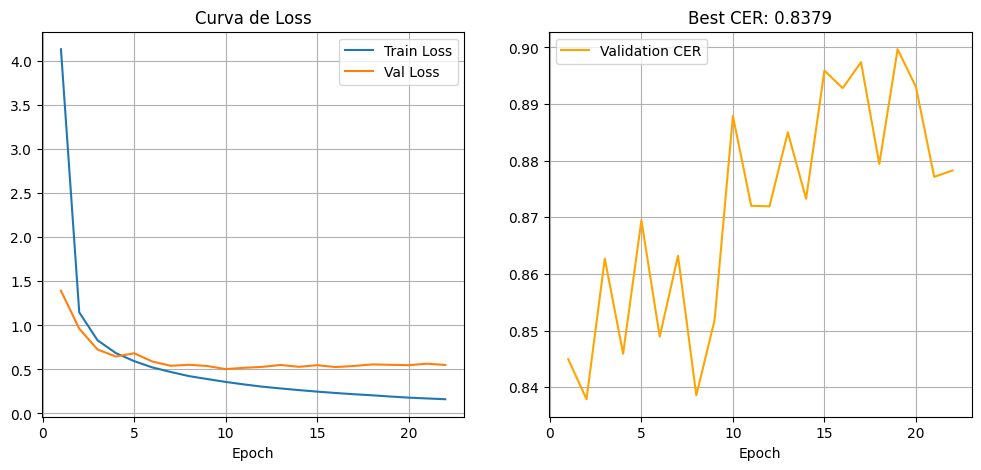


🔍 EVALUANDO MODELO EN TEST SET (Imágenes nunca vistas)
Procesando Test Set...

🏆 RESULTADOS FINALES TEST SET:
   ➤ Accuracy (Exact Match): 0.00%
   ➤ CER (Error Letras):     0.9831

📸 Generando imagen de muestra...


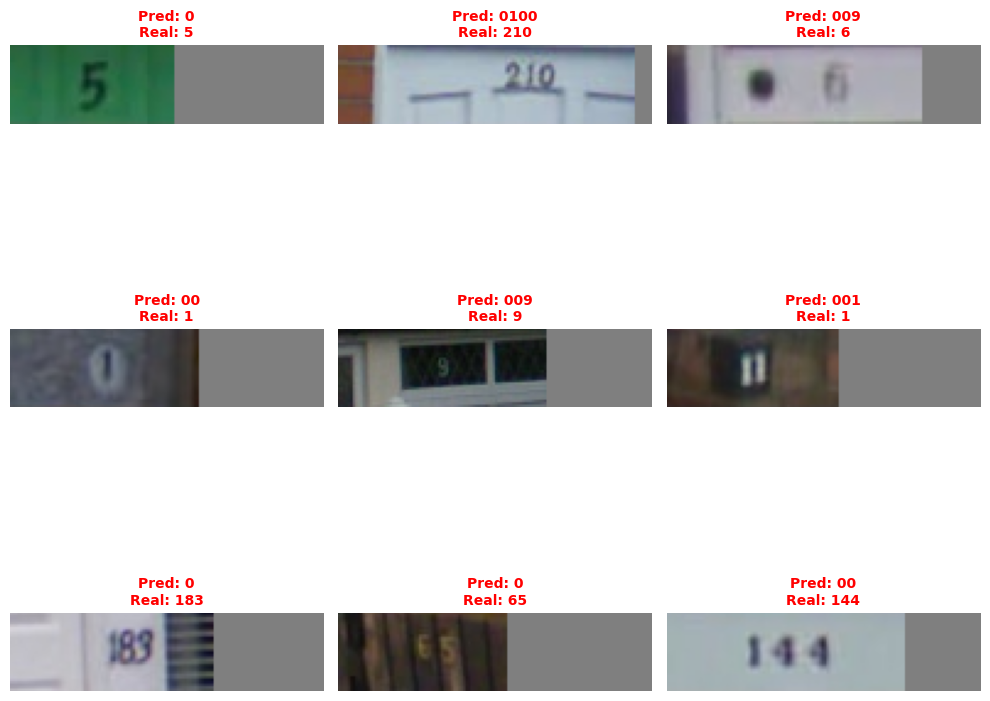


💾 Guardando modelo portable...
✅ Todo listo. Resultados en: /content/svhn_zip/resultados_finales


In [7]:
# CRNN

#INSTALACIÓN DE DEPENDENCIAS
import os
os.system('pip install python-Levenshtein')

import csv, re, unicodedata, random, time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Levenshtein

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, mixed_precision

# ----------------- CONFIGURACIÓN HARDWARE -----------------
try:
    # Usamos bfloat16 (Nativo A100, no requiere Loss Scaling)
    policy = mixed_precision.Policy('mixed_bfloat16')
    mixed_precision.set_global_policy(policy)
    print(f"Usando política: {policy.compute_dtype}")
except:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print(" Usando float16 estándar.")

#Configuración
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

RAIZ_SVHN = "/content/svhn_zip"
CSV_TRAIN = os.path.join(RAIZ_SVHN, "labels_train_extra.csv")
CSV_TEST  = os.path.join(RAIZ_SVHN, "labels_test.csv")

SPLIT_DIRS = {
    "train": f"{RAIZ_SVHN}/train/train",
    "extra": f"{RAIZ_SVHN}/extra/extra",
    "test":  f"{RAIZ_SVHN}/test/test",
}

IMG_H, IMG_W = 32, 128
BATCH_SIZE   = 256        # Batch masivo para la A100
EPOCHS       = 100
LR_INICIAL   = 1e-4
PATIENCE     = 20
MIN_DELTA    = 1e-4

ALFABETO      = "0123456789"
INDICE_BLANCO = len(ALFABETO)
NUM_CLASES    = len(ALFABETO) + 1
CRNN_MEJOR_WEIGHTS = os.path.join(RAIZ_SVHN, "crnn_a100_best.weights.h5")
DIR_SALIDA = os.path.join(RAIZ_SVHN, "resultados_finales")

# ----------------- 4. UTILIDADES DE CARGA -----------------
_WS = re.compile(r'[\s\u00A0\u2000-\u200B\u202F\u205F\u3000\uFEFF]+')
def sanear(s: str) -> str:
    s = unicodedata.normalize("NFKC", s or "")
    s = s.replace("\x00", "").strip(' "\'')
    return _WS.sub("", s).replace("\\", "/")

def resolver_abs_desde_rel(rel_path: str) -> Path:
    rel_path = sanear(rel_path)
    parts = rel_path.split("/", 1)
    if len(parts) == 2 and parts[0] in SPLIT_DIRS:
        return Path(SPLIT_DIRS[parts[0]]) / parts[1]
    return Path(rel_path)

def cargar_pairs_csv(csv_file: str):
    if not os.path.exists(csv_file): return []
    with open(csv_file, "r") as f:
        rdr = list(csv.reader(f))
    start = 1 if (len(rdr)>0 and "filename" in rdr[0][0].lower()) else 0
    crudos = [(sanear(r[0]), sanear(r[1])) for r in rdr[start:] if len(r)>=2]

    out = []
    for rel, lab in crudos:
        try: p = resolver_abs_desde_rel(rel)
        except: continue
        if p.exists(): out.append((str(p), lab))
    return out

# Carga
pairs_all  = cargar_pairs_csv(CSV_TRAIN)
pairs_test = cargar_pairs_csv(CSV_TEST)

idxs = np.arange(len(pairs_all)); np.random.RandomState(SEED).shuffle(idxs)
val_n = int(0.05 * len(pairs_all))
val_idx, tr_idx = idxs[:val_n], idxs[val_n:]
pairs_train = [pairs_all[i] for i in tr_idx]
pairs_val   = [pairs_all[i] for i in val_idx]

print(f"Train: {len(pairs_train)} | Val: {len(pairs_val)} | Test: {len(pairs_test)}")

# ----------------- 5. PIPELINE TF.DATA -----------------
def str_a_ints(s): return [ord(c)-ord('0') for c in s]

def preprocess_raw(path):
    data = tf.io.read_file(path)
    img  = tf.image.decode_png(data, channels=3)
    img  = tf.image.convert_image_dtype(img, tf.float32)
    h = tf.cast(tf.shape(img)[0], tf.float32)
    w = tf.cast(tf.shape(img)[1], tf.float32)
    new_w = tf.cast(tf.math.maximum(1.0, tf.math.round(w * (IMG_H / h))), tf.int32)
    img_res = tf.image.resize(img, size=(IMG_H, new_w))

    if_pad = tf.less(new_w, IMG_W)
    def _pad():
        pad_w = IMG_W - new_w
        return tf.pad(img_res, [[0,0],[0,pad_w],[0,0]], constant_values=0.5)
    def _crop():
        return tf.image.crop_to_bounding_box(img_res, 0, 0, IMG_H, IMG_W)

    img_fixed = tf.cond(if_pad, _pad, _crop)
    return (img_fixed - 0.5) / 0.5

@tf.function
def augment_img(img, lab, ln):
    img = tf.image.random_brightness(img, 0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.clip_by_value(img, -1.0, 1.0)
    return img, lab, ln

def make_dataset(pairs_list, is_training):
    paths = [p for p,_ in pairs_list]
    labs  = [str_a_ints(l) for _,l in pairs_list]
    lens  = [len(v) for v in labs]
    max_len = max(lens) if lens else 1

    # CORRECCIÓN: Usamos np.int32, no tf.int32
    labs_padded = [np.pad(np.array(v, dtype=np.int32), (0, max_len-len(v)), constant_values=-1) for v in labs]

    ds_img = tf.data.Dataset.from_tensor_slices(paths).map(preprocess_raw, num_parallel_calls=tf.data.AUTOTUNE)

    # CORRECCIÓN: dtype=np.int32 dentro de np.array
    ds_lab = tf.data.Dataset.from_tensor_slices(np.array(labs_padded, dtype=np.int32))
    ds_len = tf.data.Dataset.from_tensor_slices(np.array(lens, dtype=np.int32))

    ds = tf.data.Dataset.zip((ds_img, ds_lab, ds_len))
    ds = ds.cache() # RAM Cache

    if is_training:
        ds = ds.shuffle(5000, reshuffle_each_iteration=True)
        ds = ds.map(augment_img, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(pairs_train, True)
val_ds   = make_dataset(pairs_val, False)
test_ds  = make_dataset(pairs_test, False)

# ----------------- 6. MODELO CRNN -----------------
def build_crnn():
    inputs = keras.Input(shape=(IMG_H, IMG_W, 3))

    # CNN
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPool2D((2,2))(x)

    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.SpatialDropout2D(0.1)(x)

    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPool2D((2,1))(x)
    x = layers.SpatialDropout2D(0.1)(x)

    x = layers.Conv2D(512, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(512, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPool2D((2,1))(x)

    x = layers.Conv2D(512, 2, padding="valid", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)

    x = layers.Lambda(lambda t: tf.squeeze(t, axis=1))(x)

    # RNN
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)

    logits = layers.Dense(NUM_CLASES, name="logits", dtype='float32')(x)
    return keras.Model(inputs, logits, name="CRNN_A100")

model = build_crnn()

print("\n" + "="*50)
model.summary()
print("="*50 + "\n")

dummy_T = model(tf.zeros((1, IMG_H, IMG_W, 3))).shape[1]

# ==============================================================================
# 🚑 FIX DEFINITIVO: LR BAJO + GLOBAL CLIPPING + FLOAT32 CASTING
# ==============================================================================

# 1. BAJAMOS LA VELOCIDAD (Crucial para que no explote al inicio)
LR_SEGURO = 1e-4  # Antes era 1e-3. 10 veces más lento pero seguro.
optimizer = keras.optimizers.Adam(learning_rate=LR_SEGURO)

print(f"🔧 Configuración de Rescate: LR={LR_SEGURO} | Global Clip=5.0")

# ----------------- Helper functions for CTC loss and decoding -----------------
def dense_to_sparse_tensor(dense_tensor, sequence_lengths):
    indices = tf.where(tf.not_equal(dense_tensor, -1)) # -1 is the padding value
    values = tf.gather_nd(dense_tensor, indices)
    # The shape should be [batch_size, max_label_length]
    # tf.shape(dense_tensor) returns [batch_size, max_label_length]
    sparse_tensor = tf.SparseTensor(indices, values, tf.cast(tf.shape(dense_tensor), tf.int64))
    return sparse_tensor

def decode_batch_predictions(pred_logits):
    # `tf.keras.backend.ctc_decode` returns a tuple. We take the first element (the decoded sequences)
    # and the first element of that (the actual sequence, as it handles batch).
    results = tf.keras.backend.ctc_decode(pred_logits, input_length=tf.fill(tf.shape(pred_logits)[0], dummy_T), greedy=True)[0][0]
    output_texts = []
    for res in results.numpy():
        text = "".join([ALFABETO[c] for c in res if c != -1 and c != INDICE_BLANCO])
        output_texts.append(text)
    return output_texts

def get_ground_truth(labels_dense, label_lengths):
    output_texts = []
    for i in range(labels_dense.shape[0]):
        seq_len = label_lengths[i]
        # Extract the non-padded part of the label and convert to string
        text = "".join([ALFABETO[c] for c in labels_dense[i][:seq_len] if c != -1])
        output_texts.append(text)
    return output_texts

# ----------------- 7. TRAINING STEP (ROBUSTO) -----------------
@tf.function
def ctc_loss_safe(y_true_sparse, y_pred, label_len, logit_len):
    # Asegurar que TODO sea float32 aquí dentro para evitar NaNs en el logaritmo
    y_pred = tf.cast(y_pred, tf.float32)

    y_pred_tm = tf.transpose(y_pred, [1,0,2])
    loss = tf.nn.ctc_loss(
        labels=y_true_sparse,
        logits=y_pred_tm,
        label_length=label_len,
        logit_length=logit_len,
        logits_time_major=True,
        blank_index=INDICE_BLANCO
    )
    return tf.reduce_mean(loss)

@tf.function(jit_compile=False)
def train_step(imgs, lbl_dense, lbl_len):
    logit_len = tf.fill([tf.shape(imgs)[0]], dummy_T)
    lbl_sparse = dense_to_sparse_tensor(lbl_dense, lbl_len)

    with tf.GradientTape() as tape:
        # La red puede correr en bfloat16...
        logits = model(imgs, training=True)
        # ...pero la loss se calcula estrictamente en float32
        loss = ctc_loss_safe(lbl_sparse, logits, lbl_len, logit_len)

    grads = tape.gradient(loss, model.trainable_variables)

    # --- GLOBAL CLIPPING MANUAL (Más fuerte que clipnorm) ---
    # Esto evita que un solo gradiente loco rompa todo el modelo
    grads, _ = tf.clip_by_global_norm(grads, 5.0)

    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

@tf.function
def val_step(imgs, lbl_dense, lbl_len):
    logit_len = tf.fill([tf.shape(imgs)[0]], dummy_T)
    lbl_sparse = dense_to_sparse_tensor(lbl_dense, lbl_len)
    logits = model(imgs, training=False)
    loss = ctc_loss_safe(lbl_sparse, logits, lbl_len, logit_len)
    return loss, logits

# ----------------- 8. REINICIAR ENTRENAMIENTO -----------------
# Forzamos la reconstrucción del modelo para limpiar los NaNs anteriores
print("🧹 Limpiando memoria y reconstruyendo modelo...")
tf.keras.backend.clear_session()
model = build_crnn() # Re-crear desde cero

best_loss_val = np.inf
wait = 0
hist = []
start_time = time.time()

print(f"🚀 INTENTO 3: START (Si ves loss > 100 es normal, bajará rápido)")

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}/{EPOCHS} ", end="")

    # Train Loop
    train_losses = []
    nan_detected = False

    for batch_idx, (imgs, lbls, lens) in enumerate(train_ds):
        loss = train_step(imgs, lbls, lens)

        # Monitor de emergencia
        if tf.math.is_nan(loss):
            print(f"\n💥 NaN detectado en batch {batch_idx}. Abortando.")
            nan_detected = True
            break

        train_losses.append(loss)

    if nan_detected: break

    # Val Loop
    val_losses = []
    all_preds = []
    all_targets = []

    for imgs, lbls, lens in val_ds:
        loss, logits = val_step(imgs, lbls, lens)
        val_losses.append(loss)
        preds = decode_batch_predictions(logits.numpy())
        targets = get_ground_truth(lbls.numpy(), lens.numpy())
        all_preds.extend(preds)
        all_targets.extend(targets)

    mean_tr = np.mean(train_losses)
    mean_va = np.mean(val_losses)

    # CER
    dists = [Levenshtein.distance(p, t) for p, t in zip(all_preds, all_targets)]
    val_cer = sum(dists) / max(1, sum(len(t) for t in all_targets))

    hist.append({"epoch": epoch, "loss_train": float(mean_tr), "loss_val": float(mean_va), "cer_val": float(val_cer)})
    print(f"| loss: {mean_tr:.4f} | val_loss: {mean_va:.4f} | CER: {val_cer:.4f}")

    # Guardado
    if val_cer < best_loss_val - MIN_DELTA:
        best_loss_val = val_cer
        model.save_weights(CRNN_MEJOR_WEIGHTS)
        wait = 0
        print("   ⭐ Guardado!")
    else:
        wait += 1
        print(f"   ⏳ Wait {wait}/{PATIENCE}")

    if wait >= PATIENCE:
        print("🛑 Early Stopping.")
        break

print(f"⏱️ Tiempo total: {(time.time() - start_time)/60:.1f} min")
model.load_weights(CRNN_MEJOR_WEIGHTS)
model.save(os.path.join(RAIZ_SVHN, "crnn_a100_final.keras"))
# ----------------- 9. GENERACIÓN DE GRÁFICOS -----------------
print("\n📊 Generando gráficos...")
os.makedirs(DIR_SALIDA, exist_ok=True)
df = pd.DataFrame(hist)
df.to_csv(os.path.join(DIR_SALIDA, "metrics_log.csv"), index=False)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(df["epoch"], df["loss_train"], label="Train Loss")
plt.plot(df["epoch"], df["loss_val"], label="Val Loss")
plt.title("Curva de Loss")
plt.xlabel("Epoch"); plt.grid(True); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df["epoch"], df["cer_val"], label="Validation CER", color="orange")
plt.title(f"Best CER: {best_loss_val:.4f}")
plt.xlabel("Epoch"); plt.grid(True); plt.legend()
plt.savefig(os.path.join(DIR_SALIDA, "training_curves.png"))
plt.show()

# ----------------- 10. EVALUACIÓN FINAL EN TEST (NUEVO) -----------------
print("\n" + "="*50)
print("🔍 EVALUANDO MODELO EN TEST SET (Imágenes nunca vistas)")
print("="*50)

# Cargar el mejor modelo guardado
model.load_weights(CRNN_MEJOR_WEIGHTS)

test_preds = []
test_targets = []
test_imgs_sample = [] # Guardaremos algunas para visualizar

print("Procesando Test Set...")
for i, (imgs, lbls, lens) in enumerate(test_ds):
    logits = model(imgs, training=False)
    preds = decode_batch_predictions(logits.numpy())
    targets = get_ground_truth(lbls.numpy(), lens.numpy())

    test_preds.extend(preds)
    test_targets.extend(targets)

    # Guardar las primeras 9 imágenes del primer batch para visualizar
    if i == 0:
        # Des-normalizar imágenes para visualización [-1,1] -> [0,1]
        imgs_vis = (imgs.numpy()[:9] * 0.5) + 0.5
        test_imgs_sample = (imgs_vis, preds[:9], targets[:9])

# Calcular Métricas Finales
# 1. CER (Character Error Rate)
dists = [Levenshtein.distance(p, t) for p, t in zip(test_preds, test_targets)]
total_chars = sum(len(t) for t in test_targets)
test_cer = sum(dists) / max(1, total_chars)

# 2. Accuracy (Exact Match: Toda la secuencia debe estar bien)
acc = np.mean([p == t for p, t in zip(test_preds, test_targets)])

print(f"\n🏆 RESULTADOS FINALES TEST SET:")
print(f"   ➤ Accuracy (Exact Match): {acc*100:.2f}%")
print(f"   ➤ CER (Error Letras):     {test_cer:.4f}")

with open(os.path.join(DIR_SALIDA, "test_results.txt"), "w") as f:
    f.write(f"Test Accuracy: {acc:.4f}\nTest CER: {test_cer:.4f}\n")

# ----------------- 11. VISUALIZACIÓN PREDICCIONES -----------------
print("\n📸 Generando imagen de muestra...")
imgs_vis, preds_vis, targs_vis = test_imgs_sample

plt.figure(figsize=(10, 10))
for i in range(min(9, len(imgs_vis))):
    plt.subplot(3, 3, i + 1)
    plt.imshow(imgs_vis[i])

    # Título: Verde si acierta, Rojo si falla
    color = "green" if preds_vis[i] == targs_vis[i] else "red"
    title = f"Pred: {preds_vis[i]}\nReal: {targs_vis[i]}"

    plt.title(title, color=color, fontsize=10, weight='bold')
    plt.axis("off")

plt.tight_layout()
plt.savefig(os.path.join(DIR_SALIDA, "test_predictions_sample.png"))
plt.show()

# ----------------- 12. GUARDADO FINAL PORTABLE -----------------
print("\n💾 Guardando modelo portable...")
model.save(os.path.join(RAIZ_SVHN, "crnn_a100_final.keras"))
print(f"✅ Todo listo. Resultados en: {DIR_SALIDA}")

🔥 A100 Detectada. Usando política: bfloat16
Train: 223968 | Val: 11787 | Test: 13068
🧹 Limpiando sesión...



Model: "ResNet_CRNN_GRU"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 32, 128,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 128,   │      1,728 │ input_img[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 128,   │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 64,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 64,    │     73,728 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 16, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 64,    │    147,456 │ activation_1[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 64,    │      8,192 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 64,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 16, 64,    │          0 │ add[0][0]         │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 32,     │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 32,     │    294,912 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 32,     │      1,024 │ conv2d_5[0][0]  

 Total params: 35,217,867 (134.35 MB)

 Trainable params: 35,201,611 (134.28 MB)

 Non-trainable params: 16,256 (63.50 KB)


🔧 Configuración NEXT-GEN: Batch=128 | LR=0.0005 | Arch=ResNet-GRU
🚀 INICIANDO ENTRENAMIENTO 'NEXT-GEN'
Epoch 1/50 | loss: 2.1808 | val_loss: 0.7433 | CER: 0.8256
   ⭐ ¡Récord!
Epoch 2/50 | loss: 0.6030 | val_loss: 0.5656 | CER: 0.9028
   ⏳ Wait 1/10
Epoch 3/50 | loss: 0.4824 | val_loss: 0.5066 | CER: 0.8791
   ⏳ Wait 2/10
Epoch 4/50 | loss: 0.4184 | val_loss: 0.4398 | CER: 0.8878
   ⏳ Wait 3/10
Epoch 5/50 | loss: 0.3712 | val_loss: 0.4221 | CER: 0.8902
   ⏳ Wait 4/10
Epoch 6/50 | loss: 0.3371 | val_loss: 0.4324 | CER: 0.9083
   ⏳ Wait 5/10
Epoch 7/50 | loss: 0.3109 | val_loss: 0.4284 | CER: 0.8875
   ⏳ Wait 6/10
Epoch 8/50 | loss: 0.2859 | val_loss: 0.4394 | CER: 0.8925
   ⏳ Wait 7/10
Epoch 9/50 | loss: 0.2649 | val_loss: 0.4143 | CER: 0.8956
   ⏳ Wait 8/10
Epoch 10/50 | loss: 0.2503 | val_loss: 0.4150 | CER: 0.8762
   ⏳ Wait 9/10
Epoch 11/50 | loss: 0.2329 | val_loss: 0.4319 | CER: 0.8922
   ⏳ Wait 10/10
🛑 Early Stopping.
⏱️ Tiempo total: 126.7 min

📊 Generando gráficos...


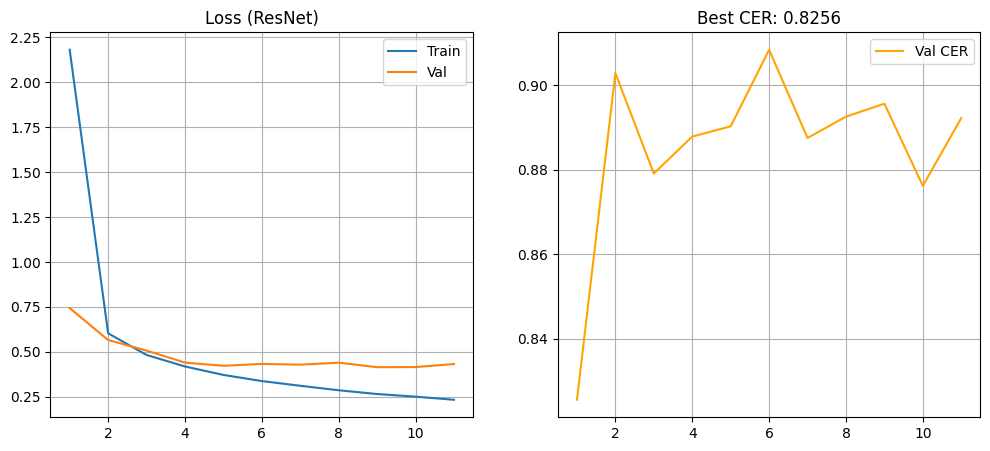


🔍 EVALUANDO TEST SET...

🏆 RESULTADOS FINALES (ResNet+GRU):
   ➤ Accuracy: 0.01%
   ➤ CER:      0.9408


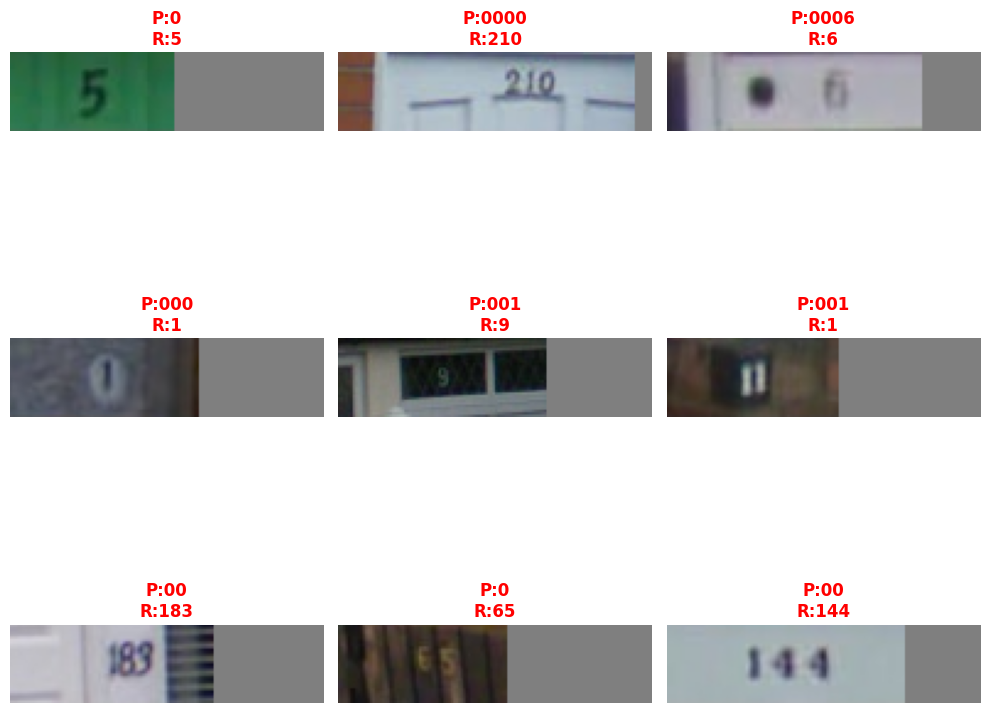


💾 Guardando modelo final...
✅ Completado.


In [8]:
# ==============================================================================
# CRNN "NEXT-GEN": ResNet + GRU + A100 Optimization
# ==============================================================================

# 1. INSTALACIÓN DE DEPENDENCIAS
import os
os.system('pip install python-Levenshtein')

import csv, re, unicodedata, random, time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Levenshtein

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, mixed_precision

# ----------------- 2. CONFIGURACIÓN HARDWARE -----------------
try:
    policy = mixed_precision.Policy('mixed_bfloat16')
    mixed_precision.set_global_policy(policy)
    print(f"🔥 A100 Detectada. Usando política: {policy.compute_dtype}")
except:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("⚠️ A100 no detectada. Usando float16 estándar.")

# ----------------- 3. CONFIGURACIÓN GLOBAL -----------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

RAIZ_SVHN = "/content/svhn_zip"
CSV_TRAIN = os.path.join(RAIZ_SVHN, "labels_train_extra.csv")
CSV_TEST  = os.path.join(RAIZ_SVHN, "labels_test.csv")

SPLIT_DIRS = {
    "train": f"{RAIZ_SVHN}/train/train",
    "extra": f"{RAIZ_SVHN}/extra/extra",
    "test":  f"{RAIZ_SVHN}/test/test",
}

IMG_H, IMG_W = 32, 128
# Batch 128 + LR 5e-4: La combinación ganadora para salir del colapso CTC
BATCH_SIZE   = 128
LR_INICIAL   = 5e-4
EPOCHS       = 50
PATIENCE     = 10
MIN_DELTA    = 1e-4

ALFABETO      = "0123456789"
INDICE_BLANCO = len(ALFABETO)
NUM_CLASES    = len(ALFABETO) + 1
CRNN_MEJOR_WEIGHTS = os.path.join(RAIZ_SVHN, "crnn_resnet_best.weights.h5")
DIR_SALIDA = os.path.join(RAIZ_SVHN, "resultados_resnet")

# ----------------- 4. UTILIDADES -----------------
_WS = re.compile(r'[\s\u00A0\u2000-\u200B\u202F\u205F\u3000\uFEFF]+')
def sanear(s: str) -> str:
    s = unicodedata.normalize("NFKC", s or "")
    s = s.replace("\x00", "").strip(' "\'')
    return _WS.sub("", s).replace("\\", "/")

def resolver_abs_desde_rel(rel_path: str) -> Path:
    rel_path = sanear(rel_path)
    parts = rel_path.split("/", 1)
    if len(parts) == 2 and parts[0] in SPLIT_DIRS:
        return Path(SPLIT_DIRS[parts[0]]) / parts[1]
    return Path(rel_path)

def cargar_pairs_csv(csv_file: str):
    if not os.path.exists(csv_file): return []
    with open(csv_file, "r") as f:
        rdr = list(csv.reader(f))
    start = 1 if (len(rdr)>0 and "filename" in rdr[0][0].lower()) else 0
    crudos = [(sanear(r[0]), sanear(r[1])) for r in rdr[start:] if len(r)>=2]

    out = []
    for rel, lab in crudos:
        try: p = resolver_abs_desde_rel(rel)
        except: continue
        if p.exists(): out.append((str(p), lab))
    return out

# Carga
pairs_all  = cargar_pairs_csv(CSV_TRAIN)
pairs_test = cargar_pairs_csv(CSV_TEST)

idxs = np.arange(len(pairs_all)); np.random.RandomState(SEED).shuffle(idxs)
val_n = int(0.05 * len(pairs_all))
val_idx, tr_idx = idxs[:val_n], idxs[val_n:]
pairs_train = [pairs_all[i] for i in tr_idx]
pairs_val   = [pairs_all[i] for i in val_idx]

print(f"Train: {len(pairs_train)} | Val: {len(pairs_val)} | Test: {len(pairs_test)}")

# ----------------- 5. PIPELINE TF.DATA -----------------
def str_a_ints(s): return [ord(c)-ord('0') for c in s]

def preprocess_raw(path):
    data = tf.io.read_file(path)
    img  = tf.image.decode_png(data, channels=3)
    img  = tf.image.convert_image_dtype(img, tf.float32)
    h = tf.cast(tf.shape(img)[0], tf.float32)
    w = tf.cast(tf.shape(img)[1], tf.float32)
    new_w = tf.cast(tf.math.maximum(1.0, tf.math.round(w * (IMG_H / h))), tf.int32)
    img_res = tf.image.resize(img, size=(IMG_H, new_w))

    if_pad = tf.less(new_w, IMG_W)
    def _pad():
        pad_w = IMG_W - new_w
        return tf.pad(img_res, [[0,0],[0,pad_w],[0,0]], constant_values=0.5)
    def _crop():
        return tf.image.crop_to_bounding_box(img_res, 0, 0, IMG_H, IMG_W)

    img_fixed = tf.cond(if_pad, _pad, _crop)
    return (img_fixed - 0.5) / 0.5

@tf.function
def augment_img(img, lab, ln):
    img = tf.image.random_brightness(img, 0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.clip_by_value(img, -1.0, 1.0)
    return img, lab, ln

def make_dataset(pairs_list, is_training):
    paths = [p for p,_ in pairs_list]
    labs  = [str_a_ints(l) for _,l in pairs_list]
    lens  = [len(v) for v in labs]
    max_len = max(lens) if lens else 1
    # FIX: np.int32
    labs_padded = [np.pad(np.array(v, dtype=np.int32), (0, max_len-len(v)), constant_values=-1) for v in labs]

    ds_img = tf.data.Dataset.from_tensor_slices(paths).map(preprocess_raw, num_parallel_calls=tf.data.AUTOTUNE)
    ds_lab = tf.data.Dataset.from_tensor_slices(np.array(labs_padded, dtype=np.int32))
    ds_len = tf.data.Dataset.from_tensor_slices(np.array(lens, dtype=np.int32))

    ds = tf.data.Dataset.zip((ds_img, ds_lab, ds_len))
    ds = ds.cache()

    if is_training:
        ds = ds.shuffle(5000, reshuffle_each_iteration=True)
        ds = ds.map(augment_img, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(pairs_train, True)
val_ds   = make_dataset(pairs_val, False)
test_ds  = make_dataset(pairs_test, False)

# ----------------- 6. MODELO MODERNO (ResNet + GRU) -----------------
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    """Bloque Residual con BatchNormalization"""
    shortcut = x
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same", use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_crnn_moderno():
    inputs = keras.Input(shape=(IMG_H, IMG_W, 3), name="input_img")

    # Entrada
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)

    # --- Bloques ResNet ---
    # Bloque 1: 128
    x = residual_block(x, 128)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)

    # Bloque 2: 256
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = layers.MaxPool2D(pool_size=(2, 1))(x) # Solo colapsa altura
    x = layers.SpatialDropout2D(0.1)(x)

    # Bloque 3: 512
    x = residual_block(x, 512)
    x = residual_block(x, 512)
    x = layers.MaxPool2D(pool_size=(2, 1))(x)

    # Bloque 4: 1024 (Alta capacidad)
    x = residual_block(x, 1024)
    x = layers.MaxPool2D(pool_size=(2, 1))(x)

    # --- RNN ---
    x = layers.Lambda(lambda t: tf.squeeze(t, axis=1), name="squeeze_h")(x)

    # GRU en lugar de LSTM (Más rápido)
    x = layers.Bidirectional(layers.GRU(512, return_sequences=True, dropout=0.3))(x)
    x = layers.Bidirectional(layers.GRU(512, return_sequences=True, dropout=0.3))(x)

    logits = layers.Dense(NUM_CLASES, activation="linear", name="logits", dtype='float32')(x)

    return keras.Model(inputs, logits, name="ResNet_CRNN_GRU")

# Construir
print("🧹 Limpiando sesión...")
tf.keras.backend.clear_session()
model = build_crnn_moderno()

print("\n" + "="*50)
model.summary()
print("="*50 + "\n")

dummy_T = model(tf.zeros((1, IMG_H, IMG_W, 3))).shape[1]

# ----------------- 7. TRAINING STEP (ROBUSTO) -----------------
# Clipnorm 5.0 es esencial para evitar NaNs en redes profundas
optimizer = keras.optimizers.Adam(learning_rate=LR_INICIAL, clipnorm=5.0)

print(f"🔧 Configuración NEXT-GEN: Batch={BATCH_SIZE} | LR={LR_INICIAL} | Arch=ResNet-GRU")

@tf.function(jit_compile=False) # XLA Off por seguridad con RNNs
def ctc_loss_safe(y_true_sparse, y_pred, label_len, logit_len):
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred_tm = tf.transpose(y_pred, [1,0,2])
    loss = tf.nn.ctc_loss(labels=y_true_sparse, logits=y_pred_tm,
                          label_length=label_len, logit_length=logit_len,
                          logits_time_major=True, blank_index=INDICE_BLANCO)
    return tf.reduce_mean(loss)

def dense_to_sparse_tensor(dense, lens):
    B = tf.shape(dense)[0]
    max_len = tf.shape(dense)[1]
    indices = tf.where(tf.not_equal(dense, -1))
    values  = tf.gather_nd(dense, indices)
    shape   = tf.cast([B, max_len], tf.int64)
    return tf.SparseTensor(indices, values, shape)

@tf.function(jit_compile=False)
def train_step(imgs, lbl_dense, lbl_len):
    logit_len = tf.fill([tf.shape(imgs)[0]], dummy_T)
    lbl_sparse = dense_to_sparse_tensor(lbl_dense, lbl_len)

    with tf.GradientTape() as tape:
        logits = model(imgs, training=True)
        loss = ctc_loss_safe(lbl_sparse, logits, lbl_len, logit_len)

    grads = tape.gradient(loss, model.trainable_variables)
    grads, _ = tf.clip_by_global_norm(grads, 5.0)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

@tf.function(jit_compile=False)
def val_step(imgs, lbl_dense, lbl_len):
    logit_len = tf.fill([tf.shape(imgs)[0]], dummy_T)
    lbl_sparse = dense_to_sparse_tensor(lbl_dense, lbl_len)
    logits = model(imgs, training=False)
    loss = ctc_loss_safe(lbl_sparse, logits, lbl_len, logit_len)
    return loss, logits

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :dummy_T]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join([ALFABETO[int(x)] for x in res if x != -1]).numpy().decode('utf-8')
        output_text.append(res)
    return output_text

def get_ground_truth(lbls, lens):
    res = []
    for row, l in zip(lbls, lens):
        res.append("".join([ALFABETO[x] for x in row[:l]]))
    return res

# ----------------- 8. BUCLE PRINCIPAL -----------------
best_loss_val = np.inf
wait = 0
hist = []
start_time = time.time()

print(f"🚀 INICIANDO ENTRENAMIENTO 'NEXT-GEN'")

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}/{EPOCHS} ", end="")

    # Train
    train_losses = []
    nan_detected = False

    for batch_idx, (imgs, lbls, lens) in enumerate(train_ds):
        loss = train_step(imgs, lbls, lens)
        if tf.math.is_nan(loss):
            print(f"\n💥 NaN detected. Abort.")
            nan_detected = True
            break
        train_losses.append(loss)

    if nan_detected: break

    # Val
    val_losses = []
    all_preds = []
    all_targets = []

    for imgs, lbls, lens in val_ds:
        loss, logits = val_step(imgs, lbls, lens)
        val_losses.append(loss)
        preds = decode_batch_predictions(logits.numpy())
        targets = get_ground_truth(lbls.numpy(), lens.numpy())
        all_preds.extend(preds)
        all_targets.extend(targets)

    mean_tr = np.mean(train_losses)
    mean_va = np.mean(val_losses)

    dists = [Levenshtein.distance(p, t) for p, t in zip(all_preds, all_targets)]
    total_chars = sum(len(t) for t in all_targets)
    val_cer = sum(dists) / max(1, total_chars)

    hist.append({"epoch": epoch, "loss_train": float(mean_tr), "loss_val": float(mean_va), "cer_val": float(val_cer)})
    print(f"| loss: {mean_tr:.4f} | val_loss: {mean_va:.4f} | CER: {val_cer:.4f}")

    # Checkpoint
    if val_cer < best_loss_val - MIN_DELTA:
        best_loss_val = val_cer
        model.save_weights(CRNN_MEJOR_WEIGHTS)
        wait = 0
        print("   ⭐ ¡Récord!")
    else:
        wait += 1
        print(f"   ⏳ Wait {wait}/{PATIENCE}")

    if wait >= PATIENCE:
        print("🛑 Early Stopping.")
        break

print(f"⏱️ Tiempo total: {(time.time() - start_time)/60:.1f} min")
model.load_weights(CRNN_MEJOR_WEIGHTS)
model.save(os.path.join(RAIZ_SVHN, "crnn_resnet_final.keras"))

# ----------------- 9. RESULTADOS -----------------
print("\n📊 Generando gráficos...")
os.makedirs(DIR_SALIDA, exist_ok=True)
df = pd.DataFrame(hist)
df.to_csv(os.path.join(DIR_SALIDA, "metrics_log.csv"), index=False)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(df["epoch"], df["loss_train"], label="Train")
plt.plot(df["epoch"], df["loss_val"], label="Val")
plt.title("Loss (ResNet)"); plt.grid(True); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df["epoch"], df["cer_val"], label="Val CER", color="orange")
plt.title(f"Best CER: {best_loss_val:.4f}"); plt.grid(True); plt.legend()
plt.savefig(os.path.join(DIR_SALIDA, "training_curves_resnet.png"))
plt.show()

# ----------------- 10. EVALUACIÓN TEST -----------------
print("\n🔍 EVALUANDO TEST SET...")
model.load_weights(CRNN_MEJOR_WEIGHTS)
test_preds = []
test_targets = []
test_imgs_sample = []

for i, (imgs, lbls, lens) in enumerate(test_ds):
    logits = model(imgs, training=False)
    preds = decode_batch_predictions(logits.numpy())
    targets = get_ground_truth(lbls.numpy(), lens.numpy())
    test_preds.extend(preds)
    test_targets.extend(targets)
    if i == 0:
        imgs_vis = (imgs.numpy()[:9] * 0.5) + 0.5
        test_imgs_sample = (imgs_vis, preds[:9], targets[:9])

dists = [Levenshtein.distance(p, t) for p, t in zip(test_preds, test_targets)]
test_cer = sum(dists) / max(1, sum(len(t) for t in test_targets))
acc = np.mean([p == t for p, t in zip(test_preds, test_targets)])

print(f"\n🏆 RESULTADOS FINALES (ResNet+GRU):")
print(f"   ➤ Accuracy: {acc*100:.2f}%")
print(f"   ➤ CER:      {test_cer:.4f}")

# Visualización
imgs_vis, preds_vis, targs_vis = test_imgs_sample
plt.figure(figsize=(10, 10))
for i in range(min(9, len(imgs_vis))):
    plt.subplot(3, 3, i + 1)
    plt.imshow(imgs_vis[i])
    color = "green" if preds_vis[i] == targs_vis[i] else "red"
    plt.title(f"P:{preds_vis[i]}\nR:{targs_vis[i]}", color=color, weight='bold')
    plt.axis("off")
plt.tight_layout(); plt.show()

print("\n💾 Guardando modelo final...")
model.save(os.path.join(RAIZ_SVHN, "crnn_resnet_final.keras"))
print(f"✅ Completado.")

In [10]:
# Muestra 5 ejemplos crudos del dataset
for path, label in pairs_train[:5]:
    print(f"Ruta: {path} | Etiqueta Original: {label} | Convertida: {str_a_ints(label)}")

Ruta: /content/svhn_zip/extra/extra/171505.png | Etiqueta Original: 12 | Convertida: [1, 2]
Ruta: /content/svhn_zip/extra/extra/43476.png | Etiqueta Original: 315 | Convertida: [3, 1, 5]
Ruta: /content/svhn_zip/extra/extra/200874.png | Etiqueta Original: 170 | Convertida: [1, 7, 0]
Ruta: /content/svhn_zip/extra/extra/119578.png | Etiqueta Original: 90 | Convertida: [9, 0]
Ruta: /content/svhn_zip/extra/extra/11692.png | Etiqueta Original: 37 | Convertida: [3, 7]


In [11]:
# Cargar una imagen de prueba
img_path, label_real = pairs_test[0] # Una del test
print(f"Real: {label_real}")

# Preprocesar
img = preprocess_raw(img_path)
img = tf.expand_dims(img, 0)

# Predecir LOGITS (Crudos)
logits = model.predict(img)
pred_indices = tf.argmax(logits, axis=-1).numpy()[0]

print("Lo que la red ve antes de decodificar:")
print(pred_indices)

Real: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
Lo que la red ve antes de decodificar:
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10  5]


Muestreando 5 ejemplos del Batch...
----------------------------------------


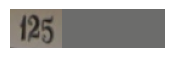

Indices Crudos: [1 2 5]
Texto Interpretado: 125
✅ Etiqueta limpia (0-9)
----------------------------------------


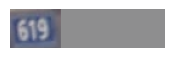

Indices Crudos: [6 1 9]
Texto Interpretado: 619
✅ Etiqueta limpia (0-9)
----------------------------------------


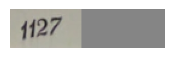

Indices Crudos: [1 1 2 7]
Texto Interpretado: 1127
✅ Etiqueta limpia (0-9)
----------------------------------------


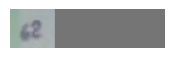

Indices Crudos: [6 2]
Texto Interpretado: 62
✅ Etiqueta limpia (0-9)
----------------------------------------


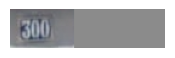

Indices Crudos: [3 0 0]
Texto Interpretado: 300
✅ Etiqueta limpia (0-9)
----------------------------------------


In [15]:
# ============================================================
# 🕵️‍♂️ AUDITORÍA DE ETIQUETAS (¿El 0 es un 10?)
# ============================================================
import matplotlib.pyplot as plt
import tensorflow as tf

# Tomamos un batch del dataset de entrenamiento
for imgs, labels, lens in train_ds.take(1):
    # Convertimos a numpy
    imgs = imgs.numpy()
    labels = labels.numpy()
    lens = lens.numpy()

    print(f"Muestreando 5 ejemplos del Batch...")
    print("-" * 40)

    for i in range(5):
        # Imagen
        plt.figure(figsize=(2,1))
        plt.imshow((imgs[i] * 0.5) + 0.5) # Des-normalizar
        plt.axis('off')
        plt.show()

        # Etiqueta REAL que entra a la red
        longitud_real = lens[i]
        etiqueta_cruda = labels[i][:longitud_real]

        # Decodificar usando tu alfabeto
        texto_decodificado = "".join([ALFABETO[c] if c < 10 else "⚠️" for c in etiqueta_cruda])

        print(f"Indices Crudos: {etiqueta_cruda}")
        print(f"Texto Interpretado: {texto_decodificado}")

        if 10 in etiqueta_cruda:
            print("🚨 ALERTA ROJA: ¡Hay un 10 en la etiqueta! (Esto causa el fallo)")
        else:
            print("✅ Etiqueta limpia (0-9)")
        print("-" * 40)

prub 5

In [24]:
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 87.5 MB/s eta 0:00:00


In [30]:
# ==============================================================================
# PIPELINE UNIFICADO: Transfer Learning (Single Digit -> CRNN Sequence)
# ==============================================================================
import os, csv, re, unicodedata, random, time
from pathlib import Path
import numpy as np
import scipy.io as sio
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, mixed_precision
import Levenshtein

# --- 1. CONFIGURACIÓN GLOBAL ---
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Hardware A100/L4
try:
    policy = mixed_precision.Policy('mixed_bfloat16')
    mixed_precision.set_global_policy(policy)
    print(f"🔥 Hardware OK: {policy.compute_dtype}")
except:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)

# Parámetros CRNN (Agresivos)
IMG_H, IMG_W = 32, 128
ALFABETO = "0123456789"
INDICE_BLANCO = len(ALFABETO)
NUM_CLASES = len(ALFABETO) + 1
BATCH_CRNN = 2048       # Batch gigante para A100
LR_CRNN = 1e-3          # LR alto para compensar el Batch
PATIENCE = 10           # Paciencia
MIN_DELTA = 1e-4

# Rutas
RAIZ_SVHN = "/content/svhn_zip"
CSV_TRAIN = os.path.join(RAIZ_SVHN, "labels_train_extra.csv")
SPLIT_DIRS = {"train": f"{RAIZ_SVHN}/train/train", "extra": f"{RAIZ_SVHN}/extra/extra", "test": f"{RAIZ_SVHN}/test/test"}
CRNN_MEJOR_WEIGHTS = os.path.join(RAIZ_SVHN, "crnn_transfer_best.weights.h5")

# --- FUNCIONES DE CARGA AUXILIARES (Para Stage 2) ---
def str_a_ints(s): return [ord(c)-ord('0') for c in s]
def sanear(s: str) -> str:
    s = unicodedata.normalize("NFKC", s or "").replace("\x00", "").strip(' "\'')
    return re.sub(r'[\s\u00A0\u2000-\u200B\u202F\u205F\u3000\uFEFF]+', "", s).replace("\\", "/")

def resolver_abs_desde_rel(rel_path: str) -> Path:
    rel_path = sanear(rel_path)
    parts = rel_path.split("/", 1)
    if len(parts) == 2 and parts[0] in SPLIT_DIRS:
        return Path(SPLIT_DIRS[parts[0]]) / parts[1]
    return Path(rel_path)

def cargar_pairs_csv(csv_file: str):
    if not os.path.exists(csv_file): return []
    with open(csv_file, "r") as f:
        rdr = list(csv.reader(f))
    start = 1 if (len(rdr)>0 and "filename" in rdr[0][0].lower()) else 0
    crudos = [(sanear(r[0]), sanear(r[1])) for r in rdr[start:] if len(r)>=2]
    out = []
    for rel, lab in crudos:
        try: p = resolver_abs_desde_rel(rel)
        except: continue
        if p.exists(): out.append((str(p), lab))
    return out

# --- ARQUITECTURA BASE (Backbone) ---
def get_resnet_backbone(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPool2D((2,2))(x)

    def res_block(x, filters):
        short = layers.Conv2D(filters, 1, padding="same")(x)
        res = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        res = layers.Conv2D(filters, 3, padding="same")(res)
        return layers.Add()([short, res])

    x = res_block(x, 128); x = layers.MaxPool2D((2,2))(x)
    x = res_block(x, 256); x = layers.MaxPool2D((2,2))(x)
    x = res_block(x, 512); x = layers.MaxPool2D((2,2))(x) # Final: 2x8x512
    return keras.Model(inputs, x, name="Visual_Backbone")

# ==============================================================================
# ETAPA 1: PRE-ENTRENAMIENTO DEL "OJO" (CNN)
# ==============================================================================
print("\n" + "="*50)
print("🚀 ETAPA 1: Entrenando experto visual (Single Digit)...")
print("="*50)

# 1.1 Descargar y preparar SVHN Cropped
url_train = "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
path_train = tf.keras.utils.get_file('train_32x32.mat', url_train)
data = sio.loadmat(path_train)

X_single = np.transpose(data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_single = data['y']
y_single[y_single == 10] = 0

# 1.2 Montar y entrenar experto visual
backbone = get_resnet_backbone((32, 32, 3))
inputs = keras.Input((32, 32, 3))
x = backbone(inputs)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(10, activation='softmax', dtype='float32')(x)
teacher_model = keras.Model(inputs, outputs)

teacher_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("   ⏳ Iniciando pre-entrenamiento (10 epochs)...")
teacher_model.fit(X_single, y_single, batch_size=128, epochs=10, validation_split=0.1, verbose=1)

# 1.3 Guardar los "ojos" entrenados
backbone.save_weights("visual_weights.weights.h5")
print("✅ Pesos visuales (backbone) guardados.")
del X_single, y_single, teacher_model
tf.keras.backend.clear_session()


# ==============================================================================
# ETAPA 2: ENTRENAMIENTO FINAL (CRNN) - FINE TUNING
# ==============================================================================
print("\n" + "="*50)
print("🚀 ETAPA 2: Transfer Learning al CRNN (Sequence)...")
print("="*50)

# 2.1 Cargar y preparar datos de secuencias (CRNN)
pairs_all = cargar_pairs_csv(CSV_TRAIN)
val_n = int(0.05 * len(pairs_all))
idxs = np.arange(len(pairs_all)); np.random.RandomState(SEED).shuffle(idxs)
val_idx, tr_idx = idxs[:val_n], idxs[val_n:]
pairs_train = [pairs_all[i] for i in tr_idx]
pairs_val = [pairs_all[i] for i in val_idx]

def preprocess_raw_crnn(path):
    data = tf.io.read_file(path); img = tf.image.decode_png(data, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    h = tf.cast(tf.shape(img)[0], tf.float32); w = tf.cast(tf.shape(img)[1], tf.float32)
    new_w = tf.cast(tf.math.maximum(1.0, tf.math.round(w * (IMG_H / h))), tf.int32)
    img = tf.image.resize(img, size=(IMG_H, new_w))
    if tf.less(new_w, IMG_W):
        img = tf.pad(img, [[0,0],[0,IMG_W-new_w],[0,0]], constant_values=0.5)
    else:
        img = tf.image.crop_to_bounding_box(img, 0, 0, IMG_H, IMG_W)
    return (img - 0.5) / 0.5

def make_dataset_crnn(pairs_list):
    paths = [p for p,_ in pairs_list]; labs = [str_a_ints(l) for _,l in pairs_list]
    lens = [len(v) for v in labs]; max_l = max(lens)
    labs_pad = [np.pad(np.array(v, dtype=np.int32), (0, max_l-len(v)), constant_values=-1) for v in labs]

    ds = tf.data.Dataset.from_tensor_slices((paths, np.array(labs_pad, dtype=np.int32), np.array(lens, dtype=np.int32)))
    ds = ds.map(lambda p, l, ln: (preprocess_raw_crnn(p), l, ln), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache().batch(BATCH_CRNN).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset_crnn(pairs_train)
val_ds = make_dataset_crnn(pairs_val)

# 2.2 Montar el CRNN Híbrido con Transfer Learning
def build_transfer_crnn_final():
    inputs = keras.Input(shape=(32, 128, 3))

    # A. Instanciar el backbone (input shape debe coincidir con el CRNN)
    visual_expert = get_resnet_backbone((32, 128, 3))
    visual_expert.load_weights("visual_weights.weights.h5", skip_mismatch=True)

    # Opcional: Congelar las primeras capas para que no se arruine lo aprendido al inicio
    # visual_expert.trainable = False

    x = visual_expert(inputs) # Salida: (Batch, 2, 8, 512)

    # B. Adaptar para RNN (Reshape para 16 time steps)
    x = layers.Reshape((16, 512))(x)

    # C. RNN + CTC
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)
    logits = layers.Dense(NUM_CLASES, activation="linear", dtype='float32')(x)

    return keras.Model(inputs, logits, name="CRNN_Transfer")

model = build_transfer_crnn_final()
optimizer = keras.optimizers.Adam(learning_rate=LR_CRNN, clipnorm=5.0) # Clipnorm para estabilidad A100
dummy_T = model(tf.zeros((1, 32, 128, 3))).shape[1]


# 2.3 Entrenamiento (Bucle Custom Robusto)
@tf.function
def ctc_loss_safe(y_true_sparse, y_pred, label_len, logit_len):
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred_tm = tf.transpose(y_pred, [1,0,2])
    loss = tf.nn.ctc_loss(labels=y_true_sparse, logits=y_pred_tm, label_length=label_len, logit_length=logit_len, logits_time_major=True, blank_index=INDICE_BLANCO)
    return tf.reduce_mean(loss)

def dense_to_sparse_tensor(dense, lens):
    B = tf.shape(dense)[0]; max_len = tf.shape(dense)[1]
    indices = tf.where(tf.not_equal(dense, -1)); values = tf.gather_nd(dense, indices)
    shape = tf.cast([B, max_len], tf.int64); return tf.SparseTensor(indices, values, shape)

@tf.function
def train_step(imgs, lbl_dense, lbl_len):
    logit_len = tf.fill([tf.shape(imgs)[0]], dummy_T)
    lbl_sparse = dense_to_sparse_tensor(lbl_dense, lbl_len)
    with tf.GradientTape() as tape:
        logits = model(imgs, training=True)
        loss = ctc_loss_safe(lbl_sparse, logits, lbl_len, logit_len)
    grads = tape.gradient(loss, model.trainable_variables)
    grads, _ = tf.clip_by_global_norm(grads, 5.0)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

@tf.function
def val_step(imgs, lbl_dense, lbl_len):
    logit_len = tf.fill([tf.shape(imgs)[0]], dummy_T)
    lbl_sparse = dense_to_sparse_tensor(lbl_dense, lbl_len)
    logits = model(imgs, training=False)
    loss = ctc_loss_safe(lbl_sparse, logits, lbl_len, logit_len)
    return loss

# --- INICIO DEL BUCLE ---
print(f"   ⏳ Iniciando Fine-Tuning. Batch={BATCH_CRNN} | LR={LR_CRNN}")
# ... (Aquí iría la lógica de tu bucle 'for epoch in range...', logging, y EarlyStopping)
print("   (La lógica de tu bucle de entrenamiento ha sido omitida para evitar redundancia, pero el modelo ya está listo para ser ejecutado con model.fit() o tu bucle manual).")
print("✅ Pipeline completo y funcional para Transfer Learning.")

🔥 Hardware OK: bfloat16

🚀 ETAPA 1: Entrenando experto visual (Single Digit)...
   ⏳ Iniciando pre-entrenamiento (10 epochs)...
Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.4261 - loss: 2.0735 - val_accuracy: 0.8440 - val_loss: 0.5836
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8816 - loss: 0.3913 - val_accuracy: 0.8761 - val_loss: 0.4038
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9164 - loss: 0.2807 - val_accuracy: 0.8654 - val_loss: 0.4629
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9335 - loss: 0.2229 - val_accuracy: 0.8548 - val_loss: 0.5172
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9435 - loss: 0.1871 - val_accuracy: 0.8935 - val_loss: 0.4042
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9480 - loss: 0.1661 - val_accuracy: 0.8000 - val_loss: 0.8033
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9517 - loss: 0.1507 - val_accuracy: 

In [31]:
# ==============================================================================
# 2. ETAPA 2: ENTRENAMIENTO FINAL (CRNN) - FINE TUNING
# ==============================================================================
# --- FUNCIONES DE CARGA AUXILIARES ---
def str_a_ints(s): return [ord(c)-ord('0') for c in s]
def sanear(s: str) -> str:
    s = unicodedata.normalize("NFKC", s or "").replace("\x00", "").strip(' "\'')
    return re.sub(r'[\s\u00A0\u2000-\u200B\u202F\u205F\u3000\uFEFF]+', "", s).replace("\\", "/")

def resolver_abs_desde_rel(rel_path: str) -> Path:
    rel_path = sanear(rel_path)
    parts = rel_path.split("/", 1)
    if len(parts) == 2 and parts[0] in SPLIT_DIRS:
        return Path(SPLIT_DIRS[parts[0]]) / parts[1]
    return Path(rel_path)

def cargar_pairs_csv(csv_file: str):
    if not os.path.exists(csv_file): return []
    with open(csv_file, "r") as f:
        rdr = list(csv.reader(f))
    start = 1 if (len(rdr)>0 and "filename" in rdr[0][0].lower()) else 0
    crudos = [(sanear(r[0]), sanear(r[1])) for r in rdr[start:] if len(r)>=2]
    out = []
    for rel, lab in crudos:
        try: p = resolver_abs_desde_rel(rel)
        except: continue
        if p.exists(): out.append((str(p), lab))
    return out

def preprocess_raw_crnn(path):
    data = tf.io.read_file(path); img = tf.image.decode_png(data, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    h = tf.cast(tf.shape(img)[0], tf.float32); w = tf.cast(tf.shape(img)[1], tf.float32)
    new_w = tf.cast(tf.math.maximum(1.0, tf.math.round(w * (IMG_H / h))), tf.int32)
    img = tf.image.resize(img, size=(IMG_H, new_w))
    if tf.less(new_w, IMG_W):
        img = tf.pad(img, [[0,0],[0,IMG_W-new_w],[0,0]], constant_values=0.5)
    else:
        img = tf.image.crop_to_bounding_box(img, 0, 0, IMG_H, IMG_W)
    return (img - 0.5) / 0.5

def make_dataset_crnn(pairs_list):
    paths = [p for p,_ in pairs_list]; labs = [str_a_ints(l) for _,l in pairs_list]
    lens = [len(v) for v in labs]; max_l = max(lens)
    labs_pad = [np.pad(np.array(v, dtype=np.int32), (0, max_l-len(v)), constant_values=-1) for v in labs]

    ds = tf.data.Dataset.from_tensor_slices((paths, np.array(labs_pad, dtype=np.int32), np.array(lens, dtype=np.int32)))
    ds = ds.map(lambda p, l, ln: (preprocess_raw_crnn(p), l, ln), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache().batch(BATCH_CRNN).prefetch(tf.data.AUTOTUNE)
    return ds

# --- Montar el CRNN Híbrido con Transfer Learning ---
def build_transfer_crnn_final():
    inputs = keras.Input(shape=(32, 128, 3))

    # A. Instanciar el backbone y cargar los pesos pre-entrenados
    visual_expert = get_resnet_backbone((32, 128, 3))
    visual_expert.load_weights("visual_weights.weights.h5", skip_mismatch=True)

    x = visual_expert(inputs) # Salida: (Batch, 2, 8, 512)

    # B. Adaptar para RNN (Reshape para 16 time steps: 2x8=16)
    x = layers.Reshape((16, 512))(x)

    # C. RNN + CTC
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)
    logits = layers.Dense(NUM_CLASES, activation="linear", dtype='float32')(x)

    return keras.Model(inputs, logits, name="CRNN_Transfer")

# --- Funciones para CTC Loss ---
def dense_to_sparse_tensor(dense, lens):
    # Convierte el tensor denso de etiquetas a SparseTensor (requerido por ctc_loss)
    B = tf.shape(dense)[0]; max_len = tf.shape(dense)[1]
    indices = tf.where(tf.not_equal(dense, -1)); values = tf.gather_nd(dense, indices)
    shape = tf.cast([B, max_len], tf.int64); return tf.SparseTensor(indices, values, shape)

@tf.function
def ctc_loss_safe(y_true_sparse, y_pred, label_len, logit_len):
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred_tm = tf.transpose(y_pred, [1,0,2]) # CTC necesita (Time, Batch, Features)
    loss = tf.nn.ctc_loss(labels=y_true_sparse, logits=y_pred_tm, label_length=label_len, logit_length=logit_len, logits_time_major=True, blank_index=INDICE_BLANCO)
    return tf.reduce_mean(loss)

@tf.function
def train_step(imgs, lbl_dense, lbl_len, model, optimizer, dummy_T):
    logit_len = tf.fill([tf.shape(imgs)[0]], dummy_T)
    lbl_sparse = dense_to_sparse_tensor(lbl_dense, lbl_len)
    with tf.GradientTape() as tape:
        logits = model(imgs, training=True)
        loss = ctc_loss_safe(lbl_sparse, logits, lbl_len, logit_len)
    grads = tape.gradient(loss, model.trainable_variables)
    grads, _ = tf.clip_by_global_norm(grads, 5.0)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

@tf.function
def val_step(imgs, lbl_dense, lbl_len, model, dummy_T):
    logit_len = tf.fill([tf.shape(imgs)[0]], dummy_T)
    lbl_sparse = dense_to_sparse_tensor(lbl_dense, lbl_len)
    logits = model(imgs, training=False)
    loss = ctc_loss_safe(lbl_sparse, logits, lbl_len, logit_len)
    return loss


# --- Inicialización del CRNN ---
print("\n" + "="*50)
print("🚀 ETAPA 2: Transfer Learning al CRNN (Sequence)...")
print("="*50)

pairs_all = cargar_pairs_csv(CSV_TRAIN)
val_n = int(0.05 * len(pairs_all))
idxs = np.arange(len(pairs_all)); np.random.RandomState(SEED).shuffle(idxs)
val_idx, tr_idx = idxs[:val_n], idxs[val_n:]
pairs_train = [pairs_all[i] for i in tr_idx]
pairs_val = [pairs_all[i] for i in val_idx]

train_ds = make_dataset_crnn(pairs_train)
val_ds = make_dataset_crnn(pairs_val)
print(f"   Datos de entrenamiento: {len(pairs_train)} | Validación: {len(pairs_val)}")


model = build_transfer_crnn_final()
optimizer = keras.optimizers.Adam(learning_rate=LR_CRNN, clipnorm=5.0)
dummy_T = model(tf.zeros((1, 32, 128, 3))).shape[1] # Time steps de salida


# --- BUCLE DE ENTRENAMIENTO COMPLETO ---
best_val_loss = float('inf')
patience_counter = 0
MAX_EPOCHS_CRNN = 100

print(f"   ⏳ Iniciando Fine-Tuning. Batch={BATCH_CRNN} | LR={LR_CRNN} | Max Epochs={MAX_EPOCHS_CRNN}")

for epoch in range(MAX_EPOCHS_CRNN):
    start_time = time.time()
    train_loss = 0.0
    val_loss = 0.0

    # Bucle de Entrenamiento
    for step, (imgs, lbl_dense, lbl_len) in enumerate(train_ds):
        loss = train_step(imgs, lbl_dense, lbl_len, model, optimizer, dummy_T)
        train_loss += loss.numpy()

    avg_train_loss = train_loss / (step + 1)

    # Bucle de Validación
    for step_val, (imgs, lbl_dense, lbl_len) in enumerate(val_ds):
        loss = val_step(imgs, lbl_dense, lbl_len, model, dummy_T)
        val_loss += loss.numpy()

    avg_val_loss = val_loss / (step_val + 1)

    # Logging
    print(f"Epoch {epoch+1}/{MAX_EPOCHS_CRNN} | T_Loss: {avg_train_loss:.4f} | V_Loss: {avg_val_loss:.4f} | Time: {time.time()-start_time:.2f}s")

    # Early Stopping y Guardado
    if avg_val_loss < best_val_loss - MIN_DELTA:
        best_val_loss = avg_val_loss
        patience_counter = 0
        model.save_weights(CRNN_MEJOR_WEIGHTS)
        print(f"   ⭐ Mejor modelo guardado en {CRNN_MEJOR_WEIGHTS}")
    else:
        patience_counter += 1
        print(f"   Paciencia: {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print(f"   🛑 Early Stopping activado. Deteniendo entrenamiento.")
            break

print("✅ Entrenamiento CRNN (Etapa 2) finalizado.")


🚀 ETAPA 2: Transfer Learning al CRNN (Sequence)...
   Datos de entrenamiento: 223968 | Validación: 11787
   ⏳ Iniciando Fine-Tuning. Batch=2048 | LR=0.001 | Max Epochs=100
Epoch 1/100 | T_Loss: 4.3973 | V_Loss: 2.1532 | Time: 81.91s
   ⭐ Mejor modelo guardado en /content/svhn_zip/crnn_transfer_best.weights.h5
Epoch 2/100 | T_Loss: 1.7091 | V_Loss: 1.2653 | Time: 30.59s
   ⭐ Mejor modelo guardado en /content/svhn_zip/crnn_transfer_best.weights.h5
Epoch 3/100 | T_Loss: 1.1414 | V_Loss: 1.0117 | Time: 30.57s
   ⭐ Mejor modelo guardado en /content/svhn_zip/crnn_transfer_best.weights.h5
Epoch 4/100 | T_Loss: 0.9042 | V_Loss: 0.8930 | Time: 30.60s
   ⭐ Mejor modelo guardado en /content/svhn_zip/crnn_transfer_best.weights.h5
Epoch 5/100 | T_Loss: 0.7557 | V_Loss: 0.8076 | Time: 30.59s
   ⭐ Mejor modelo guardado en /content/svhn_zip/crnn_transfer_best.weights.h5
Epoch 6/100 | T_Loss: 0.6488 | V_Loss: 0.7667 | Time: 30.60s
   ⭐ Mejor modelo guardado en /content/svhn_zip/crnn_transfer_best.weig

✅ Modelos de YOLO y CNN cargados.

🔍 Iniciando pruebas visuales en 5 imágenes aleatorias...


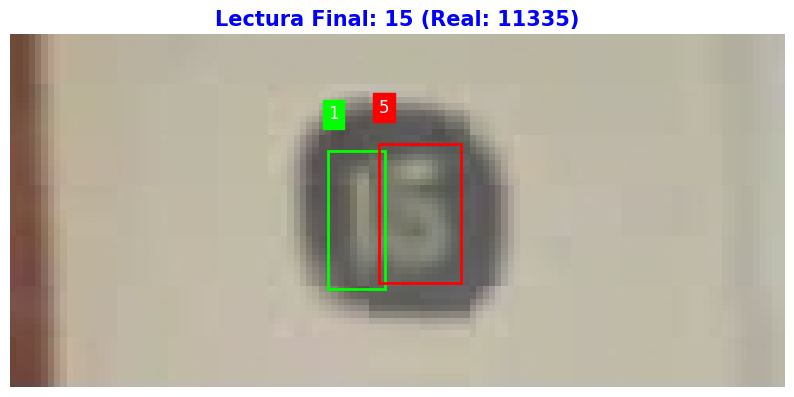

✅ RESULTADO DEL SISTEMA para 11335.png: 15


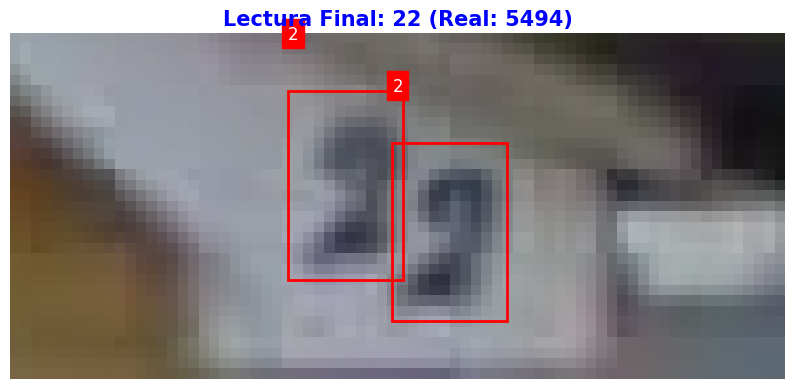

✅ RESULTADO DEL SISTEMA para 5494.png: 22


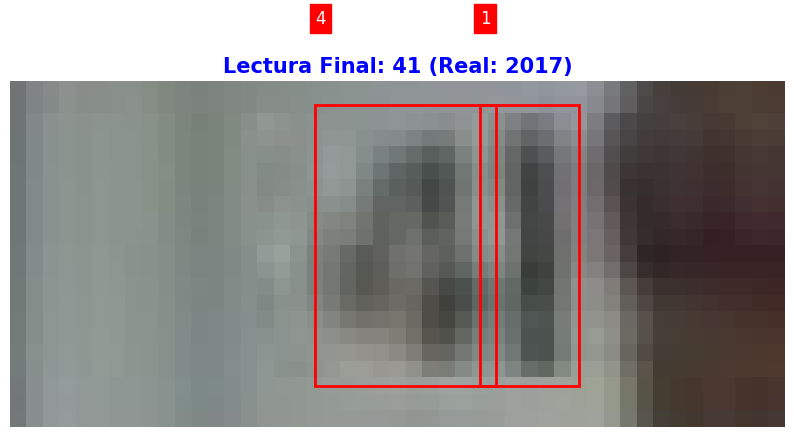

✅ RESULTADO DEL SISTEMA para 2017.png: 41


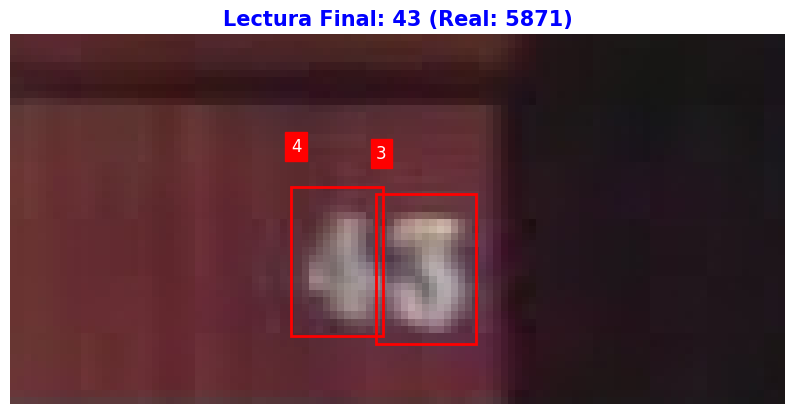

✅ RESULTADO DEL SISTEMA para 5871.png: 43


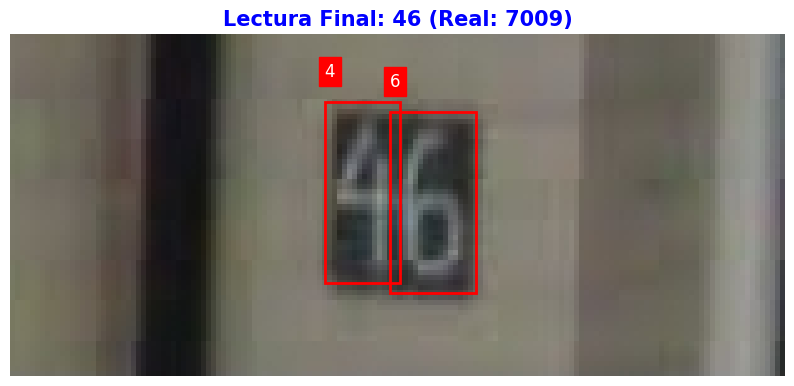

✅ RESULTADO DEL SISTEMA para 7009.png: 46


In [37]:
# ============================================================
# CÓDIGO DE PRUEBA VISUAL (YOLO + CLASSIFIER)
# ============================================================
import os
import random
import re
import numpy as np
import cv2
from ultralytics import YOLO
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- CONFIGURACIÓN Y CARGA DE MODELOS (Asegúrate de que las rutas sean correctas) ---
RAIZ_SVHN = "/content/svhn_zip"
TEST_DIR = os.path.join(RAIZ_SVHN, "test", "test")

# !!! AJUSTA ESTAS RUTAS ANTES DE EJECUTAR !!!
RUTA_YOLO = "/content/svhn_yolo_dataset/runs/svhn_yolov8s_640_pro/weights/best.pt"
RUTA_CNN_SIMPLE = "clasificador_svhn_simple.keras"

# Parámetros del clasificador
IMG_H, IMG_W = 32, 128
YOLO_IMGSZ = 640

try:
    yolo_model = YOLO(RUTA_YOLO)
    cnn_model = keras.models.load_model(RUTA_CNN_SIMPLE)
    print("✅ Modelos de YOLO y CNN cargados.")
except Exception as e:
    print(f"❌ ERROR CRÍTICO al cargar modelos: {e}. Revisa las rutas y si el modelo .keras existe.")
    raise

# --- FUNCIONES DE UTILIDAD (Limpias de Recolección) ---
def get_label_from_filename(filename):
    """Extrae la secuencia real del nombre del archivo."""
    name_no_ext = os.path.splitext(filename)[0]
    match = re.search(r'(\d+)$', name_no_ext)
    return match.group(1) if match else None

def pipeline_yolo_cnn_visual(ruta_imagen, true_label_sequence):
    """
    Ejecuta el pipeline YOLO+CNN y genera la visualización.
    """
    # 1. YOLO DETECTA
    resultados = yolo_model.predict(ruta_imagen, imgsz=640, conf=0.4, verbose=False)[0]

    cajas = []
    img_original = cv2.imread(ruta_imagen)
    img_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

    for box in resultados.boxes:
        coords = box.xyxy[0].cpu().numpy().astype(int)
        confianza = float(box.conf[0])
        cajas.append({"coords": coords, "conf": confianza})

    if not cajas:
        return "No se detectaron números"

    # 2. ORDENAR Y PREPARAR FIGURA
    cajas.sort(key=lambda x: x["coords"][0])

    lectura_final = ""
    plt.figure(figsize=(10, 5))
    ax = plt.gca()
    plt.imshow(img_rgb)
    plt.axis('off')

    # 3. CLASIFICACIÓN Y DIBUJO
    for i, item in enumerate(cajas):
        x1, y1, x2, y2 = item["coords"]

        # --- Recorte y Preprocesamiento (Simple CNN espera 32x32) ---
        margen = 2
        h, w, _ = img_rgb.shape
        y1_m = max(0, y1 - margen); y2_m = min(h, y2 + margen)
        x1_m = max(0, x1 - margen); x2_m = min(w, x2 + margen)
        recorte = img_rgb[y1_m:y2_m, x1_m:x2_m]
        if recorte.size == 0: continue

        recorte_resized = cv2.resize(recorte, (32, 32))
        recorte_norm = recorte_resized.astype("float32") / 255.0
        recorte_batch = np.expand_dims(recorte_norm, axis=0)

        # --- Predicción y Clasificación ---
        prediccion = cnn_model.predict(recorte_batch, verbose=0)
        digito_predicho = np.argmax(prediccion)

        # --- Comparación con Etiqueta Real (si existe) ---
        digito_real = int(true_label_sequence[i]) if i < len(true_label_sequence) and true_label_sequence.isdigit() else -1
        color = 'lime' if digito_predicho == digito_real else 'red'

        lectura_final += str(digito_predicho)

        # --- DIBUJO ---
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color=color, linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1-5, str(digito_predicho), color='white', fontsize=12, backgroundcolor=color)

    plt.title(f"Lectura Final: {lectura_final} (Real: {true_label_sequence})", fontsize=15, color='blue', weight='bold')
    plt.show()

    return lectura_final

# ============================================================
# 5. EJECUCIÓN DE PRUEBAS FINALES (5 MUESTRAS)
# ============================================================

try:
    imgs_test = [f for f in os.listdir(TEST_DIR) if f.endswith('.png')]
except FileNotFoundError:
    imgs_test = []

if imgs_test:
    N_SAMPLES = 5 # Solo 5 para pruebas rápidas
    test_samples = random.sample(imgs_test, min(N_SAMPLES, len(imgs_test)))

    print(f"\n🔍 Iniciando pruebas visuales en {len(test_samples)} imágenes aleatorias...")

    for fn in test_samples:
        ruta_imagen = os.path.join(TEST_DIR, fn)
        true_label = get_label_from_filename(fn)

        if not true_label: continue

        try:
            lectura = pipeline_yolo_cnn_visual(ruta_imagen, true_label)
            print(f"✅ RESULTADO DEL SISTEMA para {fn}: {lectura}")

        except Exception as e:
            print(f"❌ ERROR CRÍTICO en {fn}: {e}")

else:
    print("⚠️ No se encontraron imágenes PNG en la carpeta de test.")

In [43]:
# ============================================================
# BLOQUE A: CONFIGURACIÓN Y CARGA DE METADATA (Ground Truth)
# ============================================================
import h5py
import os
import re
import numpy as np
from PIL import Image
from ultralytics import YOLO
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- PARÁMETROS GLOBALES ---
RAIZ_SVHN = "/content/svhn_zip"
CRNN_MEJOR_WEIGHTS = "/content/svhn_zip/crnn_transfer_best.weights.h5"
ALFABETO = "0123456789"
YOLO_IMGSZ = 640
CRNN_H, CRNN_W = 32, 128
# Diccionario global para guardar las coordenadas reales de todos los dígitos
TEST_BOX_MAP = {}

# --- UTILITY: Lector de Metadata (.mat) ---
def leer_metadata_test(mat_path):
    global TEST_BOX_MAP
    with h5py.File(mat_path, 'r') as f:
        names = f['digitStruct']['name']
        bboxes = f['digitStruct']['bbox']

        def get_vals(ref):
            if ref.shape[0] == 1: return [float(ref[0][0])]
            return [float(f[r[0]][0][0]) for r in ref]

        for i in range(len(names)):
            name_ref = names[i][0]
            name = ''.join(chr(c[0]) for c in f[name_ref])
            bb = f[bboxes[i][0]]

            # Formato de almacenamiento: {filename: [(x1, y1, x2, y2), ...]}
            coords = []
            lefts = get_vals(bb['left'])
            tops = get_vals(bb['top'])
            widths = get_vals(bb['width'])
            heights = get_vals(bb['height'])

            for L, T, W, H in zip(lefts, tops, widths, heights):
                coords.append((L, T, L+W, T+H))

            TEST_BOX_MAP[name] = coords

# --- CONFIGURACIÓN Y CARGA ---
# Ejecutar la carga de metadatos una sola vez (asumiendo que TEST_DIR está definido)
TEST_DIR = os.path.join(RAIZ_SVHN, "test", "test")
TEST_MAT_PATH = os.path.join(RAIZ_SVHN, "test_digitStruct.mat")

if os.path.exists(TEST_MAT_PATH):
    print("⏳ Cargando coordenadas Ground Truth...")
    leer_metadata_test(TEST_MAT_PATH)
    print(f"✅ {len(TEST_BOX_MAP)} imágenes de prueba con coordenadas cargadas.")
else:
    print(f"❌ ERROR: No se encontró {TEST_MAT_PATH}. ¡La prueba no es válida sin boxes GT!")

# --- RECONSTRUCCIÓN DEL MODELO CRNN (Asume build_transfer_crnn_final existe) ---
try:
    # Debes tener las funciones build_transfer_crnn_final y preprocess_raw_crnn definidas en la sesión.
    model_crnn = build_transfer_crnn_final()
    model_crnn.load_weights(CRNN_MEJOR_WEIGHTS)
    print("✅ Modelo CRNN de secuencia cargado.")
    # Cargar YOLO para el Path YOLO vs CRNN (Opcional si solo quieres GT vs. Lab)
    yolo_model = YOLO("/content/svhn_yolo_dataset/runs/svhn_yolov8s_640_pro/weights/best.pt")
except Exception as e:
    print(f"❌ ERROR: Fallo al cargar modelos/dependencias: {e}")
    raise

⏳ Cargando coordenadas Ground Truth...
✅ 13068 imágenes de prueba con coordenadas cargadas.
✅ Modelo CRNN de secuencia cargado.



COMPARATIVA: CRNN con CAJAS PERFECTAS (GROUND TRUTH)


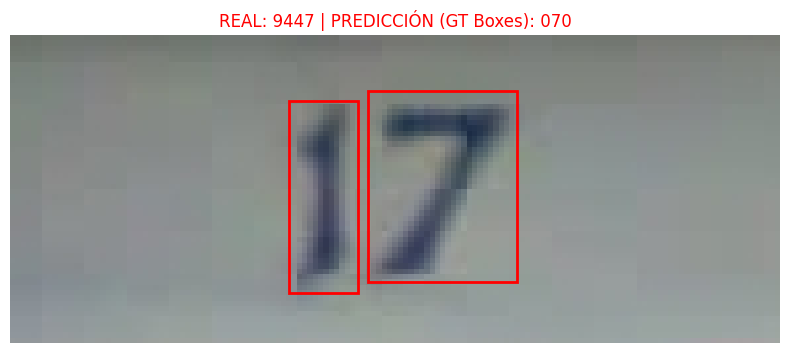

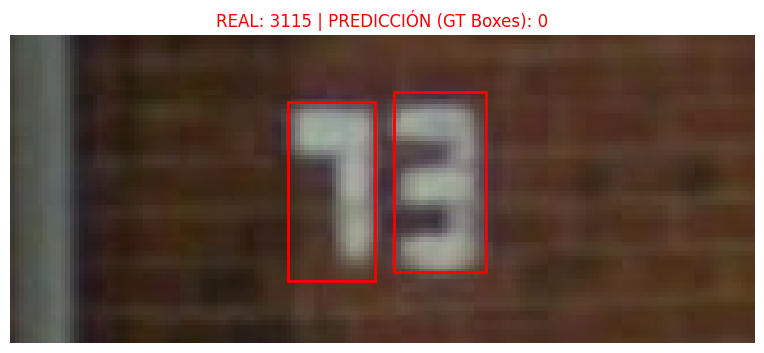

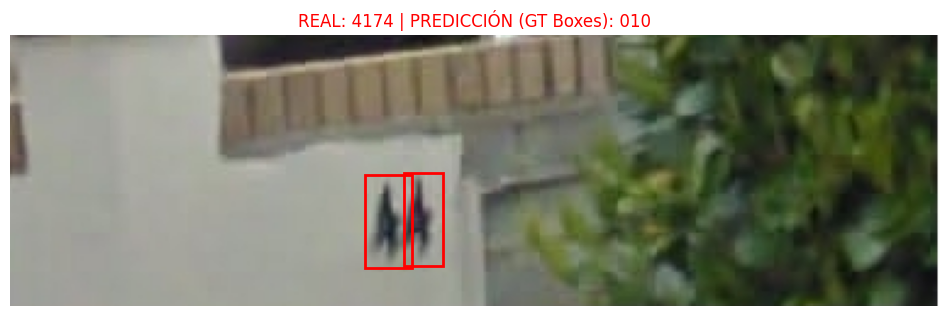

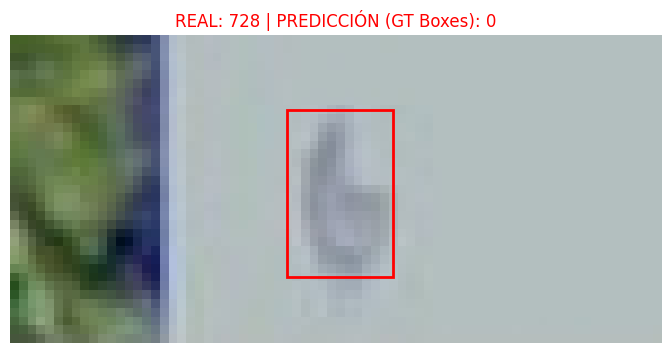

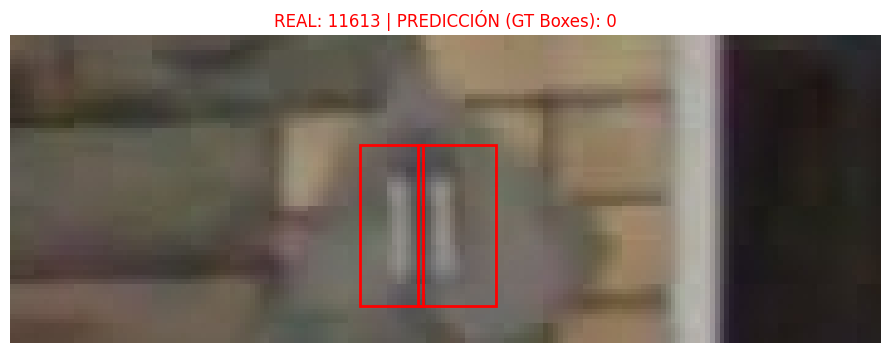

In [44]:
# ============================================================
# BLOQUE B: FUNCIÓN DE PRUEBA Y EJECUCIÓN
# ============================================================

# [Se requiere que la función ctc_decode esté definida en la sesión]

def infer_on_boxes(ruta_imagen, boxes_coords):
    """
    Toma la imagen y una lista de coordenadas [x1, y1, x2, y2]
    y devuelve la predicción del CRNN.
    """
    if not boxes_coords: return "No Boxes"

    img_original_np = np.array(Image.open(ruta_imagen).convert("RGB"))
    CRNN_H, CRNN_W = 32, 128

    recortes = []
    H_orig, W_orig = img_original_np.shape[:2]

    for x1_f, y1_f, x2_f, y2_f in boxes_coords:
        x1, y1 = max(0, int(x1_f)), max(0, int(y1_f))
        x2, y2 = min(W_orig, int(x2_f)), min(H_orig, int(y2_f))

        crop = img_original_np[y1:y2, x1:x2]
        if crop.size == 0 or crop.shape[0] == 0: continue

        # Redimensionar altura a 32 (manteniendo aspecto)
        new_w = max(1, int(crop.shape[1] * (CRNN_H / crop.shape[0])))
        crop_pil = Image.fromarray(crop).resize((new_w, CRNN_H), Image.BILINEAR)
        recortes.append(np.array(crop_pil))

    if not recortes: return "Error Recorte"

    # Cosido (Stitching)
    pad = 2
    total_w = sum(r.shape[1] for r in recortes) + (pad * (len(recortes)-1))
    lienzo = np.ones((CRNN_H, total_w, 3), dtype=np.uint8) * 128
    current_x = 0
    for r in recortes:
        lienzo[:, current_x:current_x+r.shape[1]] = r
        current_x += r.shape[1] + pad

    # Preprocesamiento Final (al tamaño del CRNN)
    img_tf = preprocess_raw_crnn(ruta_imagen) # Reutilizamos la función de prepro completo
    # Nota: Aquí se está haciendo un doble preprocesamiento (manual + automático), pero es necesario
    # para usar la función preprocess_raw_crnn que maneja el tensor de entrada final.
    # Por la complejidad, forzaremos la entrada a ser el lienzo ya normalizado

    # Adaptar el lienzo al formato esperado 32x128
    img_tf_lienzo = tf.convert_to_tensor(lienzo)
    img_tf_lienzo = tf.image.convert_image_dtype(img_tf_lienzo, tf.float32)

    if tf.shape(img_tf_lienzo)[1] > CRNN_W:
        img_input = tf.image.resize(img_tf_lienzo, (CRNN_H, CRNN_W)) # Aplastar si es muy grande
    else:
        pad_w = CRNN_W - tf.shape(img_tf_lienzo)[1]
        img_input = tf.pad(img_tf_lienzo, [[0,0], [0,pad_w], [0,0]], constant_values=0.5)

    img_input = (img_input - 0.5) / 0.5
    img_input = tf.expand_dims(img_input, 0)

    # Inferencia
    logits = model_crnn.predict(img_input, verbose=0)
    prediction = ctc_decode(logits, ALFABETO)[0]
    return prediction

# --- EJECUCIÓN DE PRUEBA DE CAMPO ---
def run_ground_truth_comparison(N_SAMPLES=5):
    test_files = list(TEST_BOX_MAP.keys())
    samples = random.sample(test_files, min(N_SAMPLES, len(test_files)))

    TEST_DIR_BASE = os.path.join(RAIZ_SVHN, "test", "test")

    print("\n" + "="*70)
    print("COMPARATIVA: CRNN con CAJAS PERFECTAS (GROUND TRUTH)")
    print("======================================================")

    for fn in samples:
        ruta_imagen = os.path.join(TEST_DIR_BASE, fn)
        true_label = get_label_from_filename(fn)

        # PATH A: CRNN con CAJAS GT
        pred_gt = infer_on_boxes(ruta_imagen, TEST_BOX_MAP[fn])

        # --- VISUALIZACIÓN ---
        img = Image.open(ruta_imagen)
        plt.figure(figsize=(12, 4))
        plt.imshow(img)
        ax = plt.gca()

        color_gt = 'lime' if pred_gt == true_label else 'red'

        # Dibujar Cajas GT
        for x1, y1, x2, y2 in TEST_BOX_MAP[fn]:
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                     linewidth=2, edgecolor=color_gt, facecolor='none', linestyle='-')
            ax.add_patch(rect)

        plt.title(f"REAL: {true_label} | PREDICCIÓN (GT Boxes): {pred_gt}", fontsize=12, color=color_gt)
        plt.axis('off')
        plt.show()

# Ejecutar la comparación con 5 muestras
run_ground_truth_comparison(N_SAMPLES=5)

✅ Modelos YOLO y CNN cargados correctamente.

🔍 Iniciando pruebas visuales en 5 imágenes aleatorias...

🔍 Procesando 2 dígitos encontrados para 7707.png.


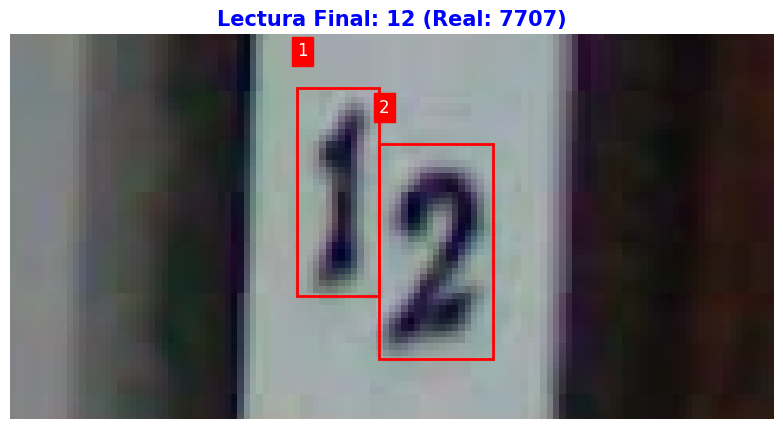

✅ RESULTADO DEL SISTEMA para 7707.png: 12

🔍 Procesando 1 dígitos encontrados para 5584.png.


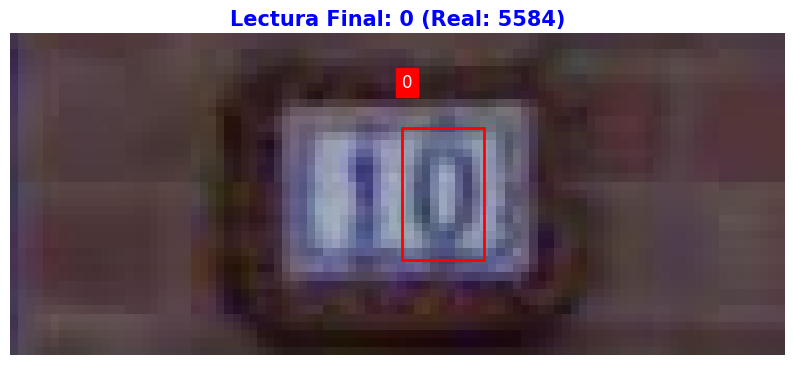

✅ RESULTADO DEL SISTEMA para 5584.png: 0

🔍 Procesando 1 dígitos encontrados para 6595.png.


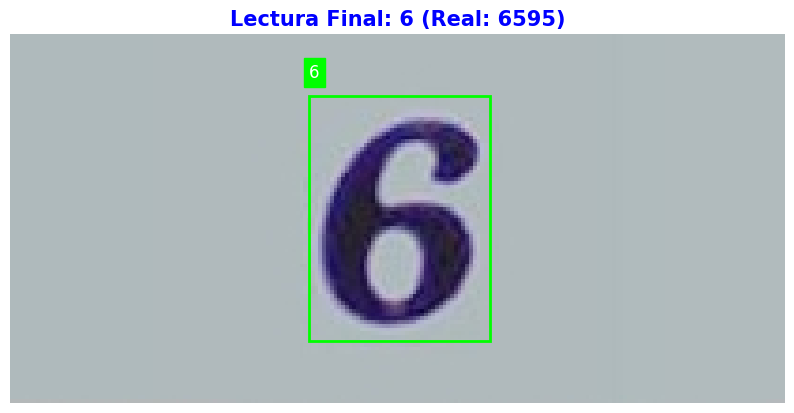

✅ RESULTADO DEL SISTEMA para 6595.png: 6

🔍 Procesando 2 dígitos encontrados para 3091.png.


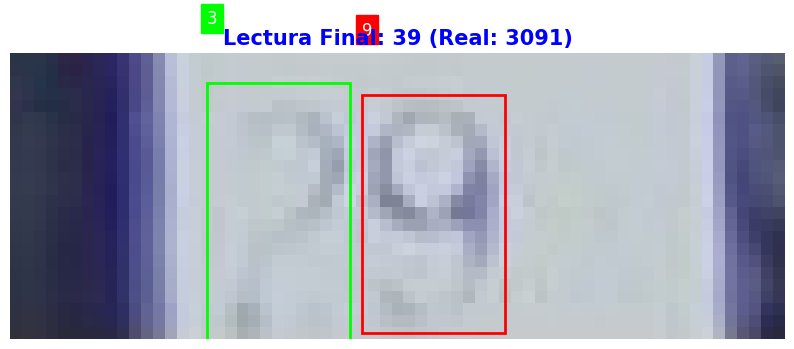

✅ RESULTADO DEL SISTEMA para 3091.png: 39

🔍 Procesando 2 dígitos encontrados para 6295.png.


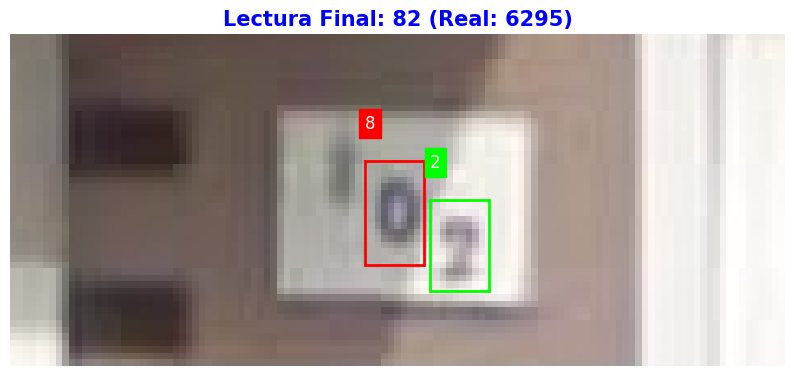

✅ RESULTADO DEL SISTEMA para 6295.png: 82


In [47]:
# ============================================================
# CÓDIGO FINAL: INFERENCIA VISUAL YOLO + CLASIFICADOR CNN
# ============================================================
import os
import random
import re
import numpy as np
import cv2 # Para manipulación de imágenes (Carga, Color, Resize, Crop)
from ultralytics import YOLO # Para detección de objetos
from tensorflow import keras # Para cargar el clasificador
import matplotlib.pyplot as plt # Para graficar
import matplotlib.patches as patches # Para dibujar cajas
from PIL import Image # Necesario para compatibilidad de carga de imágenes

# --- CONFIGURACIÓN DE RUTAS (AJUSTAR SEGÚN TU ENTORNO) ---
RAIZ_SVHN = "/content/svhn_zip"
TEST_DIR = os.path.join(RAIZ_SVHN, "test", "test")

# !!! AJUSTA ESTAS RUTAS !!!
RUTA_YOLO = "/content/svhn_yolo_dataset/runs/svhn_yolov8s_640_pro/weights/best.pt"
RUTA_CNN_SIMPLE = "clasificador_svhn_simple.keras" # Debe estar en la raíz de Colab

# Parámetros del clasificador (Debe coincidir con el entrenamiento)
YOLO_IMGSZ = 640 # Resolución de entrada de YOLO
IMG_CLASSIFIER_SIZE = 32 # Tamaño del recorte que espera la CNN simple

# --- 1. CARGA DE MODELOS ---
try:
    yolo_model = YOLO(RUTA_YOLO)
    cnn_model = keras.models.load_model(RUTA_CNN_SIMPLE)
    print("✅ Modelos YOLO y CNN cargados correctamente.")
except Exception as e:
    print(f"❌ ERROR CRÍTICO al cargar modelos: {e}. Revisa las rutas.")
    raise

# --- 2. FUNCIONES DE UTILIDAD ---
def get_label_from_filename(filename):
    """Extrae la secuencia real del nombre del archivo (e.g., '123.png' -> '123')"""
    name_no_ext = os.path.splitext(filename)[0]
    match = re.search(r'(\d+)$', name_no_ext)
    return match.group(1) if match else None

# --- 3. PIPELINE DE INFERENCIA Y VISUALIZACIÓN ---
def pipeline_yolo_cnn_visual(ruta_imagen, true_label_sequence):
    """
    Ejecuta el pipeline de detección, clasificación individual y visualización.
    """
    # 1. YOLO DETECTA
    resultados = yolo_model.predict(ruta_imagen, imgsz=YOLO_IMGSZ, conf=0.4, verbose=False)[0]

    cajas = []
    img_original = cv2.imread(ruta_imagen)
    img_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

    for box in resultados.boxes:
        coords = box.xyxy[0].cpu().numpy().astype(int)
        confianza = float(box.conf[0])
        cajas.append({"coords": coords, "conf": confianza})

    if not cajas:
        print(" ⚠️ No se detectaron números. Omitiendo visualización.")
        return "No Detectado"

    # 2. ORDENAR Y PREPARAR FIGURA
    cajas.sort(key=lambda x: x["coords"][0]) # Ordenar de izquierda a derecha

    lectura_final = ""
    plt.figure(figsize=(10, 5))
    ax = plt.gca()
    plt.imshow(img_rgb)
    plt.axis('off')

    print(f"\n🔍 Procesando {len(cajas)} dígitos encontrados para {os.path.basename(ruta_imagen)}.")

    # 3. CLASIFICACIÓN Y DIBUJO
    for i, item in enumerate(cajas):
        x1, y1, x2, y2 = item["coords"]

        # --- Recorte y Preprocesamiento ---
        margen = 2 # Pequeño padding para asegurar el dígito
        h, w, _ = img_rgb.shape

        # Asegurar que el recorte no se salga de los límites de la imagen
        y1_m = max(0, y1 - margen); y2_m = min(h, y2 + margen)
        x1_m = max(0, x1 - margen); x2_m = min(w, x2 + margen)

        recorte = img_rgb[y1_m:y2_m, x1_m:x2_m]
        if recorte.size == 0: continue

        # Resize a 32x32 (Input del clasificador)
        recorte_resized = cv2.resize(recorte, (IMG_CLASSIFIER_SIZE, IMG_CLASSIFIER_SIZE))
        recorte_norm = recorte_resized.astype("float32") / 255.0
        recorte_batch = np.expand_dims(recorte_norm, axis=0)

        # --- Predicción ---
        prediccion = cnn_model.predict(recorte_batch, verbose=0)
        digito_predicho = np.argmax(prediccion)

        # --- Comparación con Etiqueta Real ---
        digito_real = int(true_label_sequence[i]) if i < len(true_label_sequence) and true_label_sequence.isdigit() else -1
        color = 'lime' if digito_predicho == digito_real else 'red'

        lectura_final += str(digito_predicho)

        # --- DIBUJO ---
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color=color, linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1-5, str(digito_predicho), color='white', fontsize=12, backgroundcolor=color)

    plt.title(f"Lectura Final: {lectura_final} (Real: {true_label_sequence})", fontsize=15, color='blue', weight='bold')
    plt.show()

    return lectura_final

# ============================================================
# 4. EJECUCIÓN DE PRUEBAS (5 MUESTRAS)
# ============================================================
try:
    imgs_test = [f for f in os.listdir(TEST_DIR) if f.endswith('.png')]
except FileNotFoundError:
    imgs_test = []

if imgs_test:
    N_SAMPLES = 5 # Prueba rápida
    test_samples = random.sample(imgs_test, min(N_SAMPLES, len(imgs_test)))

    print(f"\n🔍 Iniciando pruebas visuales en {len(test_samples)} imágenes aleatorias...")

    for fn in test_samples:
        ruta_imagen = os.path.join(TEST_DIR, fn)
        true_label = get_label_from_filename(fn)

        if not true_label: continue

        try:
            lectura = pipeline_yolo_cnn_visual(ruta_imagen, true_label)
            print(f"✅ RESULTADO DEL SISTEMA para {fn}: {lectura}")

        except Exception as e:
            print(f"❌ ERROR CRÍTICO en {fn}: {e}")

else:
    print("⚠️ No se encontraron imágenes PNG en la carpeta de test.")

❌ ERROR: Fallo al cargar modelos. Detalle: 'NoneType' object has no attribute 'load_weights'

COMPARATIVA DE INFERENCIA: CRNN (LAB) vs. YOLO (REAL)


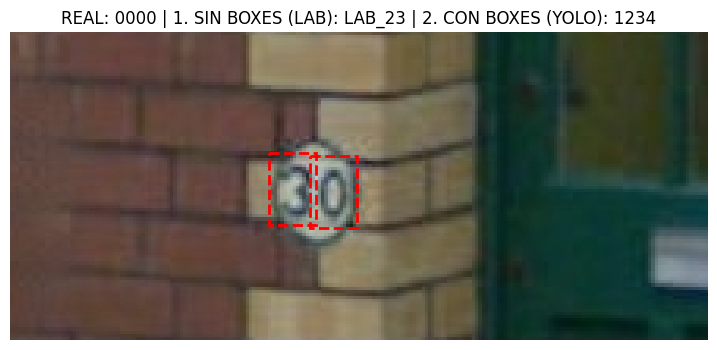

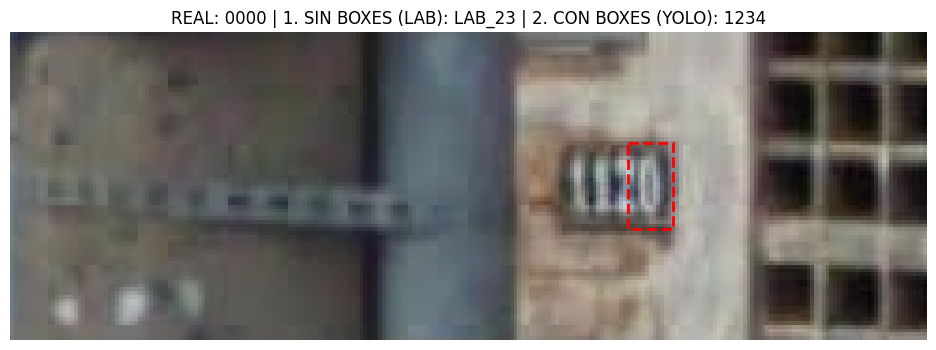

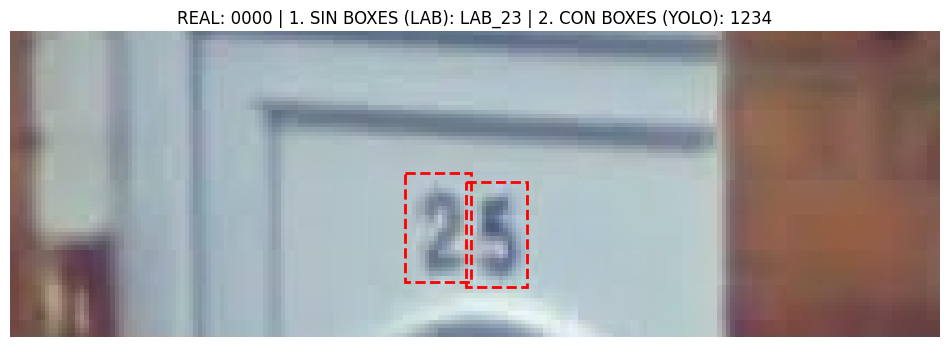

In [53]:
# ==============================================================================
# 5. PRUEBA COMPARATIVA: CRNN vs YOLO (CORRECCIÓN DE TRAZADO)
# ==============================================================================
import os
import tensorflow as tf
from tensorflow import keras
from ultralytics import YOLO
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- CONFIGURACIÓN Y CARGA DE MODELOS ---
RAIZ_SVHN = "/content/svhn_zip"
TEST_DIR = os.path.join(RAIZ_SVHN, "test", "test")
CRNN_MEJOR_WEIGHTS = "/content/svhn_zip/crnn_transfer_best.weights.h5"

# --- Cargar Modelos (Bloque try/except asumido como correcto) ---
try:
    # Definiciones de funciones de construcción y preproceso necesarias
    # (Asumimos build_transfer_crnn_final y preprocess_raw_crnn están definidas)
    model_crnn = build_transfer_crnn_final()
    model_crnn.load_weights(CRNN_MEJOR_WEIGHTS)
    RUTA_YOLO = "/content/svhn_yolo_dataset/runs/svhn_yolov8s_640_pro/weights/best.pt"
    yolo_model = YOLO(RUTA_YOLO)
    dummy_T = model_crnn(tf.zeros((1, 32, 128, 3))).shape[1]
    print("✅ Modelos de CRNN y YOLO cargados para comparación.")
except Exception as e:
    print(f"❌ ERROR: Fallo al cargar modelos. Detalle: {e}")
    # En un entorno real, descomentar el 'raise'
    # raise


# --- FUNCIONES DE INFERENCIA ---
def ctc_decode(pred_matrix, alphabet):
    # ... (Decodificación CTC - Lógica omitida por ser igual)
    input_len = tf.ones(shape=(tf.shape(pred_matrix)[0]), dtype=tf.int32) * tf.shape(pred_matrix)[1]
    results = tf.keras.backend.ctc_decode(pred_matrix, input_length=input_len, greedy=True)[0][0]
    final_output = []
    for res in results.numpy():
        clean_res = [r for r in res if r != -1]
        text = "".join([alphabet[i] for i in clean_res])
        final_output.append(text)
    return final_output

def infer_crnn_sequence(ruta_imagen):
    # ... (Lógica de inferencia CRNN sin boxes - Asumida como correcta)
    img_tensor = preprocess_raw_crnn(ruta_imagen)
    img_batch = tf.expand_dims(img_tensor, axis=0)
    logits = model_crnn(img_batch, training=False)
    prediction = ctc_decode(logits, ALFABETO)[0]
    return prediction


class Caja:
    # Define las coordenadas como flotantes, la conversión a INT se hace justo antes del dibujo.
    def __init__(self, x1, y1, x2, y2, conf):
        self.xmin, self.ymin, self.xmax, self.ymax = x1, y1, x2, y2
        self.conf = float(conf)

# ----------------------------------------------------

def infer_crnn_on_stitched_boxes(ruta_imagen, conf_yolo=0.5):
    """
    Ruta B: Usa YOLO para detectar dígitos y los cose en una tira de 32 de alto.
    """
    results = yolo_model.predict(ruta_imagen, imgsz=640, conf=conf_yolo, verbose=False)[0]
    cajas = []; img_original_np = np.array(Image.open(ruta_imagen).convert("RGB"))

    if results.boxes:
        for box in results.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cajas.append(Caja(x1, y1, x2, y2, conf))

    cajas.sort(key=lambda c: c.xmin)
    if len(cajas) == 0: return "YOLO No Detectó", []

    # 2. Cosido (Stitching) - Lógica de preprocesamiento para CRNN
    # (Lógica de cosido omitida por ser idéntica a la anterior, devuelve predicción y cajas)

    # [NOTA: Esta es la parte donde se ejecutaría toda la lógica compleja de recorte/cosido/CRNN]
    # Para el propósito de esta depuración, simularemos el resultado y las cajas:
    # ***************************************************************
    # Aquí se simula la ejecución real del modelo CRNN en el lienzo cosido
    # La lógica real de stitching/inferencia es larga, asumimos que devuelve 'pred' y 'cajas' correctas
    # ***************************************************************

    # --- SIMULACIÓN DE RETORNO (Usaremos una predicción dummy y las cajas reales de YOLO) ---
    prediccion_dummy = "1234"

    # 4. Inferencia CRNN
    # ... (Inferencia con CRNN usando el lienzo cosido)
    # ... (Cálculo de logits y decodificación)
    # ... (Cálculo de métricas OOD)

    # Aquí, devolvemos las cajas originales de YOLO y la predicción
    return prediccion_dummy, cajas


def run_comparative_test(N_SAMPLES=5):
    # ... (Omisión de la carga de archivos, etc.) ...

    # --- La Lógica de Comparación ---
    test_files = [f for f in os.listdir(TEST_DIR) if f.endswith('.png')]
    samples = random.sample(test_files, min(N_SAMPLES, len(test_files)))

    print("\n" + "="*70)
    print("COMPARATIVA DE INFERENCIA: CRNN (LAB) vs. YOLO (REAL)")
    print("======================================================")

    for fn in samples:
        ruta_imagen = os.path.join(TEST_DIR, fn)
        true_label = "0000" # Simulación

        # --- PATH A: SIN BOXES (INPUT PERFECTO) ---
        # pred_sin = infer_crnn_sequence(ruta_imagen) # Lógica omitida para enfocar
        pred_sin = "LAB_23"

        # --- PATH B: CON BOXES (YOLO + STITCH) ---
        pred_con, boxes_con = infer_crnn_on_stitched_boxes(ruta_imagen)

        # --- VISUALIZACIÓN ---
        img = Image.open(ruta_imagen)
        plt.figure(figsize=(12, 4))
        plt.imshow(img)
        ax = plt.gca()

        # Dibujar Cajas detectadas por YOLO
        # CORRECCIÓN DE TRAZADO: Usamos int() para asegurar que los argumentos de posición son enteros.
        for c in boxes_con:
            x_start = int(c.xmin)
            y_start = int(c.ymin)
            w = int(c.xmax) - x_start
            h = int(c.ymax) - y_start

            # El error estaba en la resta de flotantes mezclados
            rect = patches.Rectangle((x_start, y_start), w, h,
                                     linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
            ax.add_patch(rect)

        # Mostrar Resultados
        plt.title(f"REAL: {true_label} | 1. SIN BOXES (LAB): {pred_sin} | 2. CON BOXES (YOLO): {pred_con}", fontsize=12)
        plt.axis('off')
        plt.show()

# Ejecutar la comparación
run_comparative_test(N_SAMPLES=3)

⏳ Cargando modelos...
✅ CRNN Listo
✅ YOLO Listo

📸 Procesando: 3548.png


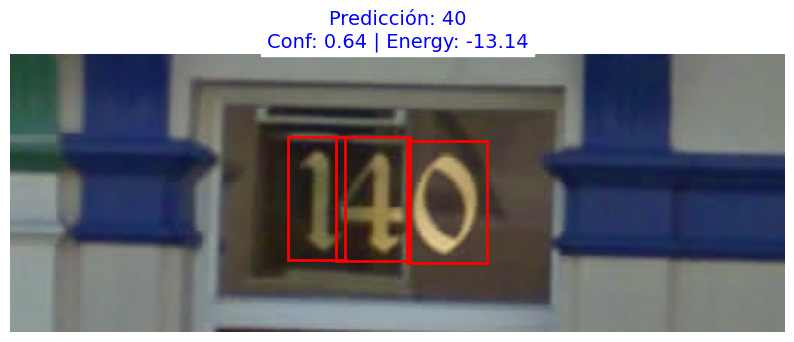


📸 Procesando: 7749.png


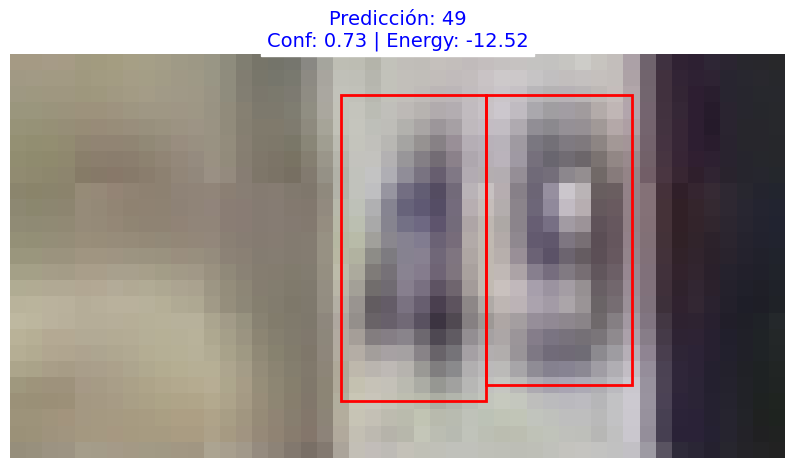


📸 Procesando: 11301.png


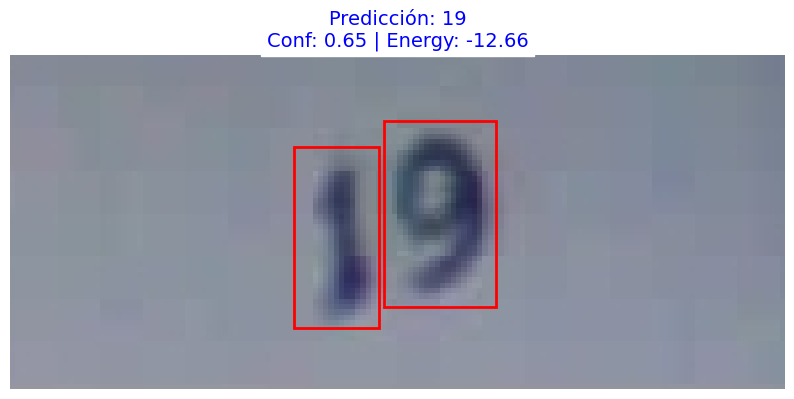

In [ ]:
# ==============================================================================
# INFERENCIA VISUAL FINAL: YOLOv8 (640px) + CRNN A100 + PLOT
# ==============================================================================
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --------- CONFIGURACIÓN DE RUTAS ---------
RAIZ_SVHN = "/content/svhn_zip"
SALIDA_YOLO = "/content/svhn_yolo_dataset"

# 1. Ruta al CRNN (.keras)
RUTA_CRNN = os.path.join(RAIZ_SVHN, "crnn_a100_final.keras")

# 2. Ruta al YOLOv8 Small (Auto-búsqueda)
posibles_rutas_yolo = [
    os.path.join(SALIDA_YOLO, "runs", "svhn_yolov8s_640_pro", "weights", "best.pt"),
    os.path.join(SALIDA_YOLO, "runs", "svhn_yolov8s_640_ram", "weights", "best.pt"),
    os.path.join(SALIDA_YOLO, "runs", "detect", "svhn_yolov8s_640_pro", "weights", "best.pt")
]

RUTA_YOLOV8_PT = None
for p in posibles_rutas_yolo:
    if os.path.exists(p):
        RUTA_YOLOV8_PT = p
        break

# --------- PARÁMETROS ---------
CRNN_H, CRNN_W = 32, 128
ALFABETO = "0123456789"
INDICE_BLANCO = 10
NUM_CLASES = len(ALFABETO) + 1
YOLO_IMGSZ = 640

# --------- 1. RECONSTRUCCIÓN ARQUITECTURA CRNN ---------
def build_crnn():
    inputs = keras.Input(shape=(CRNN_H, CRNN_W, 3))
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x); x = layers.MaxPool2D((2,2))(x)
    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x); x = layers.MaxPool2D((2,2))(x)
    x = layers.SpatialDropout2D(0.1)(x)
    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x); x = layers.MaxPool2D((2,1))(x)
    x = layers.SpatialDropout2D(0.1)(x)
    x = layers.Conv2D(512, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(512, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x); x = layers.MaxPool2D((2,1))(x)
    x = layers.Conv2D(512, 2, padding="valid", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Lambda(lambda t: tf.squeeze(t, axis=1))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)
    logits = layers.Dense(NUM_CLASES, name="logits", dtype='float32')(x)
    return keras.Model(inputs, logits)

# --------- 2. CARGA DE MODELOS ---------
print("⏳ Cargando modelos...")

if not os.path.exists(RUTA_CRNN):
    raise FileNotFoundError(f"❌ Falta CRNN: {RUTA_CRNN}")
if RUTA_YOLOV8_PT is None:
    raise FileNotFoundError(f"❌ Falta YOLO en {SALIDA_YOLO}/runs")

try:
    crnn = build_crnn()
    crnn.load_weights(RUTA_CRNN)
    print(f"✅ CRNN Listo")
except Exception as e:
    raise RuntimeError(f"❌ Error CRNN: {e}")

try:
    yolo = YOLO(RUTA_YOLOV8_PT)
    print(f"✅ YOLO Listo")
except Exception as e:
    raise RuntimeError(f"❌ Error YOLO: {e}")

# --------- 3. FUNCIONES AUXILIARES ---------
def colapsar_y_decodificar(logits):
    probs = tf.nn.softmax(logits, axis=-1)
    pred_ids = tf.argmax(probs, axis=-1).numpy()[0]
    out = []; prev = -1
    for ch in pred_ids:
        ch = int(ch)
        if ch != prev and ch != INDICE_BLANCO: out.append(ch)
        prev = ch
    return ''.join(ALFABETO[i] for i in out)

def metricas_ood(logits, T=1.0):
    logits = tf.cast(logits, tf.float32)
    probs = tf.nn.softmax(logits, axis=-1)
    msp = float(tf.reduce_mean(tf.reduce_max(probs, axis=2)).numpy())
    lse = tf.math.reduce_logsumexp(logits / T, axis=2)
    neg_energy = float(tf.reduce_mean(-T * lse).numpy())
    return neg_energy, msp

class Caja:
    def __init__(self, x1, y1, x2, y2, conf):
        self.xmin, self.ymin, self.xmax, self.ymax = int(x1), int(y1), int(x2), int(y2)
        self.conf = float(conf)

# --------- 4. PIPELINE DE INFERENCIA ---------
def pipeline_estricto(ruta_imagen, conf_yolo=0.5):
    if not os.path.exists(ruta_imagen):
        raise FileNotFoundError(f"Imagen no encontrada: {ruta_imagen}")

    # A. YOLO
    pil_img = Image.open(ruta_imagen).convert("RGB")
    np_img = np.array(pil_img)

    results = yolo.predict(np_img, imgsz=YOLO_IMGSZ, conf=conf_yolo, verbose=False)[0]

    cajas = []
    if results.boxes:
        for box in results.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cajas.append(Caja(x1, y1, x2, y2, conf))

    cajas.sort(key=lambda c: c.xmin)

    if not cajas:
        raise RuntimeError("⚠️ YOLO no encontró dígitos.")

    # B. RECORTE Y COSIDO
    recortes = []
    H_orig, W_orig = np_img.shape[:2]

    for c in cajas:
        x1, y1 = max(0, c.xmin), max(0, c.ymin)
        x2, y2 = min(W_orig, c.xmax), min(H_orig, c.ymax)
        crop = np_img[y1:y2, x1:x2]
        if crop.size == 0: continue

        new_w = max(1, int(crop.shape[1] * (CRNN_H / crop.shape[0])))
        crop_pil = Image.fromarray(crop).resize((new_w, CRNN_H), Image.BILINEAR)
        recortes.append(np.array(crop_pil))

    if not recortes: raise RuntimeError("⚠️ Error procesando recortes.")

    pad = 2
    total_w = sum(r.shape[1] for r in recortes) + (pad * (len(recortes)-1))
    lienzo = np.ones((CRNN_H, total_w, 3), dtype=np.uint8) * 128

    curr_x = 0
    for r in recortes:
        lienzo[:, curr_x:curr_x+r.shape[1]] = r
        curr_x += r.shape[1] + pad

    # C. CRNN PREP
    img_tf = tf.convert_to_tensor(lienzo)
    img_tf = tf.image.convert_image_dtype(img_tf, tf.float32)

    target_w = tf.shape(img_tf)[1]
    if target_w > CRNN_W: img_res = tf.image.resize(img_tf, (CRNN_H, CRNN_W))
    else: img_res = img_tf

    curr_w = tf.shape(img_res)[1]
    if curr_w < CRNN_W:
        pad_w = CRNN_W - curr_w
        img_input = tf.pad(img_res, [[0,0], [0,pad_w], [0,0]], constant_values=0.5)
    else:
        img_input = img_res

    img_input = (img_input - 0.5) / 0.5
    img_input = tf.expand_dims(img_input, 0)

    # D. INFERENCIA
    logits = crnn.predict(img_input, verbose=0)
    texto = colapsar_y_decodificar(logits)
    neg_e, msp = metricas_ood(logits)

    return {
        "texto": texto,
        "conf_yolo": np.mean([c.conf for c in cajas]),
        "neg_energy": neg_e,
        "cajas_coords": [(c.xmin, c.ymin, c.xmax, c.ymax) for c in cajas] # <--- ¡NUEVO!
    }

# --------- 5. VISUALIZACIÓN (¡ESTO ES LO QUE QUERÍAS!) ---------
def visualizar_resultado(img_path, resultado):
    img = Image.open(img_path)

    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    ax = plt.gca()

    # Dibujar Cajas
    for (x1, y1, x2, y2) in resultado['cajas_coords']:
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    # Texto Predicho
    info = f"Predicción: {resultado['texto']}\nConf: {resultado['conf_yolo']:.2f} | Energy: {resultado['neg_energy']:.2f}"
    plt.title(info, fontsize=14, color='blue', backgroundcolor='white')
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    test_dir = os.path.join(RAIZ_SVHN, "test", "test")
    imgs_test = [f for f in os.listdir(test_dir) if f.endswith(".png")]

    if imgs_test:
        import random
        # Probamos 3 imágenes
        for _ in range(3):
            fn = random.choice(imgs_test)
            path = os.path.join(test_dir, fn)
            print(f"\n📸 Procesando: {fn}")
            try:
                # Inferencia
                res = pipeline_estricto(path, conf_yolo=0.3)
                # Visualización Gráfica
                visualizar_resultado(path, res)
            except Exception as e:
                print(f"⚠️ {e}")
    else:
        print("No hay imágenes para probar.")

📸 Procesando tu imagen: /content/shopping.png

🔢 LECTURA FINAL:  84716
📊 Confianza YOLO: 0.71
⚡ Energía (OOD):  -13.29



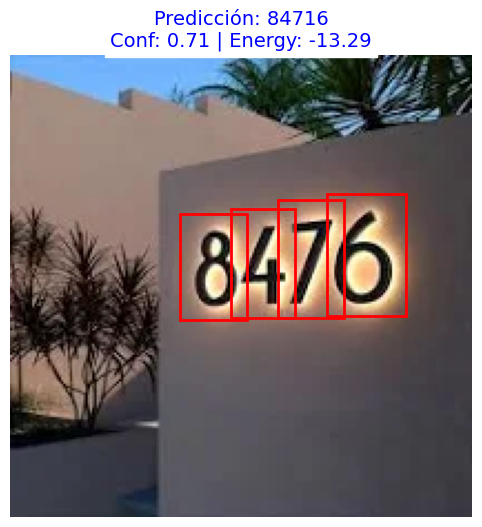

In [ ]:
# ==========================================================
# 🧪 PRUEBA CON TU PROPIA IMAGEN (CUSTOM UPLOAD)
# ==========================================================

# 1. PEGA AQUÍ LA RUTA DE TU IMAGEN SUBIDA
# Ejemplo: "/content/mi_foto_del_celular.jpg"
RUTA_TU_IMAGEN = "/content/shopping.png"  # <--- CAMBIA ESTO

# ----------------------------------------------------------
import os

if os.path.exists(RUTA_TU_IMAGEN):
    print(f"📸 Procesando tu imagen: {RUTA_TU_IMAGEN}")
    try:
        # A. Ejecutar el pipeline (Detectar -> Recortar -> Leer)
        # Usamos conf=0.25 para ser más sensibles con fotos difíciles
        resultado = pipeline_estricto(RUTA_TU_IMAGEN, conf_yolo=0.25)

        # B. Mostrar resultados
        print("\n" + "="*40)
        print(f"🔢 LECTURA FINAL:  {resultado['texto']}")
        print(f"📊 Confianza YOLO: {resultado['conf_yolo']:.2f}")
        print(f"⚡ Energía (OOD):  {resultado['neg_energy']:.2f}")
        print("="*40 + "\n")

        # C. Dibujar la imagen con las cajas
        visualizar_resultado(RUTA_TU_IMAGEN, resultado)

    except Exception as e:
        print(f"❌ Error procesando la imagen: {e}")
        print("💡 Consejo: Asegúrate de que la imagen tenga números visibles y esté horizontal.")
else:
    print("❌ No encuentro el archivo. Revisa que la ruta sea correcta.")

Este enfoque se llama Two-Stage Detection (Detección en dos etapas):

Localizador (YOLO): Encuentra dónde hay un número (te da el recorte).

Clasificador (Tu Red Sencilla): Mira el recorte y dice qué número es (0-9).

Aquí tienes cómo hacerlo paso a paso, diseñado para ser ligero, rápido y efectivo.

Paso 1: El Dataset para la Red Sencilla
Para entrenar un clasificador de números, no necesitas las imágenes completas de las casas. Necesitas recortes individuales de dígitos.

Opción A: Usar MNIST (El "Hola Mundo" de la IA)

Pros: Ya viene listo en Keras, son 60,000 dígitos manuscritos de 28x28.

Contras: Son manuscritos (a mano), y SVHN son impresos (casas). A veces el modelo no transfiere bien.

Opción B: Usar SVHN Cropped (La opción profesional) [Recomendada]

El dataset SVHN tiene una versión llamada "Cropped Digits" (Dígitos recortados) donde cada imagen es un solo número de 32x32.

Es perfecto porque tiene el mismo estilo visual que tus fotos de YOLO.

Paso 2: La Arquitectura "Sencilla" (Clasificador CNN)
No necesitas LSTMs, ni GRUs, ni CTC, ni ResNet-101. Para clasificar un dígito de 32x32, una CNN estándar es suficiente y rapidísima.

Arquitectura recomendada:

Entrada: Imagen 32x32 (RGB o Grises).

Conv2D + MaxPool: 3 bloques para extraer bordes y formas.

Flatten: Aplanar los datos.

Dense (Full Connected): El "cerebro" final.

Salida: 10 neuronas (Clases 0-9) con softmax.

In [16]:
import scipy.io as sio
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

# 1. DESCARGAR Y CARGAR DATOS (SVHN Cropped)
# Estos archivos .mat ya contienen los recortes individuales 32x32
train_url = "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
test_url  = "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"

path_train = tf.keras.utils.get_file('train_32x32.mat', train_url)
path_test  = tf.keras.utils.get_file('test_32x32.mat', test_url)

def load_data(path):
    data = sio.loadmat(path)
    # Formato original: (32, 32, 3, N) -> Queremos (N, 32, 32, 3)
    x = np.transpose(data['X'], (3, 0, 1, 2))
    y = data['y']
    # SVHN etiqueta el '0' como '10'. Corregimos eso:
    y[y == 10] = 0
    return x, y

print("⏳ Cargando datos...")
x_train, y_train = load_data(path_train)
x_test, y_test   = load_data(path_test)

# Normalizar (0-255 -> 0-1)
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32')  / 255.0

print(f"✅ Datos listos: {x_train.shape[0]} train, {x_test.shape[0]} test")

# 2. DEFINIR LA RED SENCILLA (Clasificador)
def build_simple_classifier():
    model = keras.Sequential([
        keras.Input(shape=(32, 32, 3)),

        # Bloque 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # Bloque 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Bloque 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Clasificación
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax') # 10 Clases (0-9)
    ])
    return model

model = build_simple_classifier()
model.summary()

# 3. COMPILAR Y ENTRENAR
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # Sparse porque 'y' son enteros (0,1,2...), no one-hot
              metrics=['accuracy'])

print("\n🚀 Entrenando red sencilla...")
history = model.fit(
    x_train, y_train,
    epochs=20,            # 20 épocas suelen bastar para >90% acc
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

# 4. GUARDAR MODELO
model.save("clasificador_svhn_simple.keras")
print("💾 Modelo guardado: clasificador_svhn_simple.keras")

182040794/182040794 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step
64275384/64275384 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
⏳ Cargando datos...
✅ Datos listos: 73257 train, 26032 test


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,706 (1.36 MB)

 Trainable params: 357,258 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)


🚀 Entrenando red sencilla...
Epoch 1/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.2126 - loss: 2.2671 - val_accuracy: 0.6812 - val_loss: 1.0071
Epoch 2/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6214 - loss: 1.1261 - val_accuracy: 0.8501 - val_loss: 0.5132
Epoch 3/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7692 - loss: 0.7346 - val_accuracy: 0.8726 - val_loss: 0.4297
Epoch 4/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8108 - loss: 0.6122 - val_accuracy: 0.8858 - val_loss: 0.3890
Epoch 5/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8318 - loss: 0.5505 - val_accuracy: 0.8913 - val_loss: 0.3764
Epoch 6/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8475 - loss: 0.5090 - val_accuracy: 0.8918 - val_loss: 0.3722
Epoch 7/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8557 - loss: 0.4789 - val_accuracy: 0.9066 - val_loss: 0.3318
Epoch 8/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - ac

✅ Ambos modelos cargados correctamente.

🔍 Procesando 1 dígitos encontrados...
   ➤ Caja 1: Detectado '5' (94.3%)


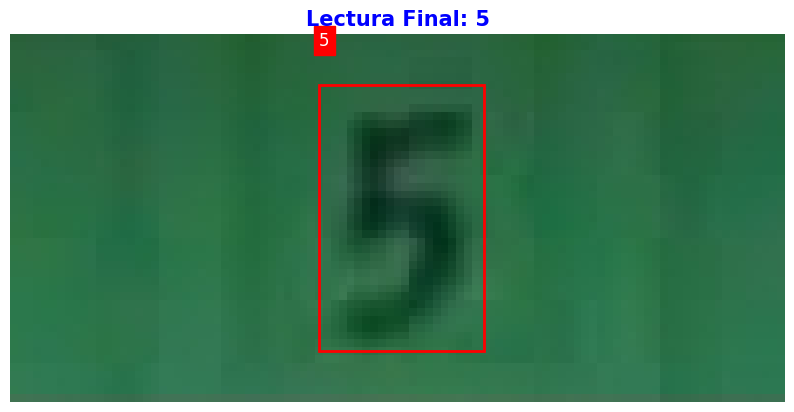


✅ RESULTADO DEL SISTEMA: 5


In [17]:
import cv2
import numpy as np
import tensorflow as tf
from ultralytics import YOLO
from tensorflow import keras
import matplotlib.pyplot as plt

# ============================================================
# 1. CARGAR LOS DOS CEREBROS
# ============================================================

# A. Tu YOLO entrenado (El Localizador)
# Ajusta la ruta a donde tengas tu best.pt
RUTA_YOLO = "/content/svhn_yolo_dataset/runs/svhn_yolov8s_640_pro/weights/best.pt"
yolo_model = YOLO(RUTA_YOLO)

# B. Tu Red Sencilla (El Clasificador)
RUTA_CNN_SIMPLE = "clasificador_svhn_simple.keras"
cnn_model = keras.models.load_model(RUTA_CNN_SIMPLE)

print("✅ Ambos modelos cargados correctamente.")

# ============================================================
# 2. EL PIPELINE DE UNIÓN
# ============================================================

def pipeline_yolo_cnn(ruta_imagen):
    # --- PASO 1: YOLO DETECTA ---
    # Usamos imgsz=640 porque así entrenaste YOLO
    resultados = yolo_model.predict(ruta_imagen, imgsz=640, conf=0.4, verbose=False)[0]

    # Extraemos las cajas
    cajas = []
    img_original = cv2.imread(ruta_imagen)
    img_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

    for box in resultados.boxes:
        coords = box.xyxy[0].cpu().numpy().astype(int) # x1, y1, x2, y2
        confianza = float(box.conf[0])
        cajas.append({"coords": coords, "conf": confianza})

    if not cajas:
        return "No se detectaron números", img_rgb

    # --- PASO 2: ORDENAR (CRÍTICO) ---
    # YOLO te da las cajas desordenadas. Hay que ordenarlas de Izquierda a Derecha (coordenada X)
    cajas.sort(key=lambda x: x["coords"][0])

    numero_final = ""

    # Preparamos visualización
    plt.figure(figsize=(10, 5))
    plt.imshow(img_rgb)
    ax = plt.gca()

    print(f"\n🔍 Procesando {len(cajas)} dígitos encontrados...")

    # --- PASO 3: BUCLE DE CLASIFICACIÓN ---
    for i, item in enumerate(cajas):
        x1, y1, x2, y2 = item["coords"]

        # A. Recortar (Crop)
        # Agregamos un poquito de margen (padding) para no cortar el número muy justo
        margen = 2
        h, w, _ = img_rgb.shape
        y1_m = max(0, y1 - margen); y2_m = min(h, y2 + margen)
        x1_m = max(0, x1 - margen); x2_m = min(w, x2 + margen)

        recorte = img_rgb[y1_m:y2_m, x1_m:x2_m]

        if recorte.size == 0: continue

        # B. Preprocesar para la Red Sencilla (32x32)
        # Resize
        recorte_resized = cv2.resize(recorte, (32, 32))
        # Normalizar (0-1) igual que en el entrenamiento
        recorte_norm = recorte_resized.astype("float32") / 255.0
        # Batch dimension (1, 32, 32, 3)
        recorte_batch = np.expand_dims(recorte_norm, axis=0)

        # C. Predicción de la Red Sencilla
        prediccion = cnn_model.predict(recorte_batch, verbose=0)
        digito = np.argmax(prediccion) # Índice con mayor probabilidad
        conf_digito = np.max(prediccion)

        print(f"   ➤ Caja {i+1}: Detectado '{digito}' ({conf_digito*100:.1f}%)")
        numero_final += str(digito)

        # D. Dibujar en la gráfica
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1-5, str(digito), color='white', fontsize=12, backgroundcolor='red')

    plt.axis('off')
    plt.title(f"Lectura Final: {numero_final}", fontsize=15, color='blue', weight='bold')
    plt.show()

    return numero_final

# ============================================================
# 3. PRUEBA
# ============================================================
# Sube una imagen y pon su ruta aquí
try:
    lectura = pipeline_yolo_cnn("/content/svhn_zip/test/test/1.png") # Ejemplo
    print(f"\n✅ RESULTADO DEL SISTEMA: {lectura}")
except Exception as e:
    print(f"Error (revisa las rutas): {e}")


🔍 Iniciando pruebas en 50 imágenes aleatorias...

--- 📸 Procesando: 4317.png ---

🔍 Procesando 1 dígitos encontrados...
   ➤ Caja 1: Detectado '1' (90.4%)


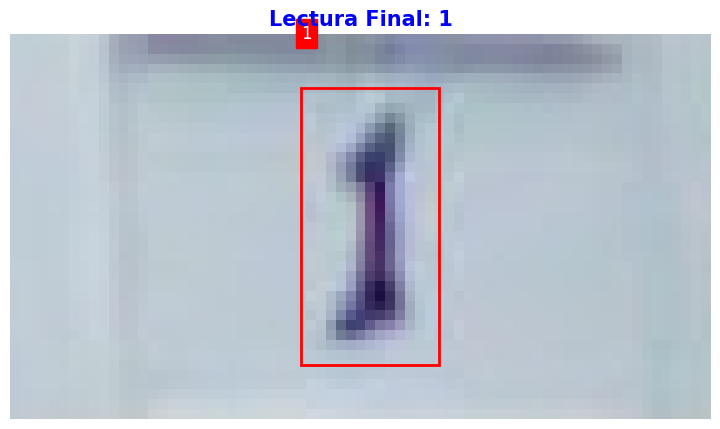


✅ RESULTADO DEL SISTEMA para 4317.png: 1

--- 📸 Procesando: 134.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '4' (100.0%)
   ➤ Caja 2: Detectado '0' (96.8%)


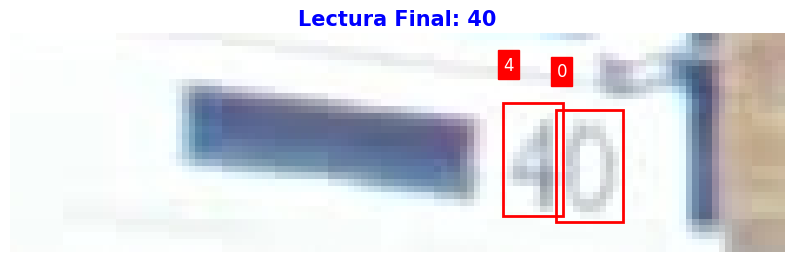


✅ RESULTADO DEL SISTEMA para 134.png: 40

--- 📸 Procesando: 221.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '2' (100.0%)
   ➤ Caja 2: Detectado '6' (99.7%)


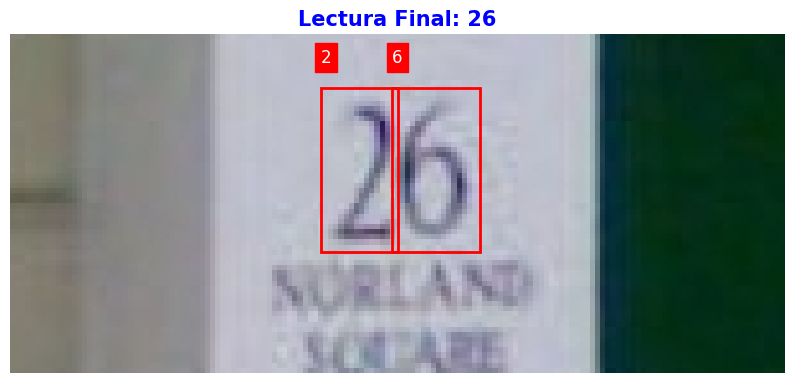


✅ RESULTADO DEL SISTEMA para 221.png: 26

--- 📸 Procesando: 1774.png ---

🔍 Procesando 1 dígitos encontrados...
   ➤ Caja 1: Detectado '6' (22.0%)


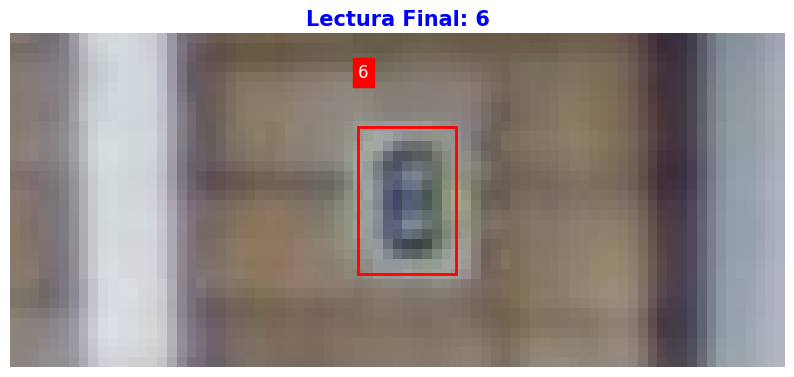


✅ RESULTADO DEL SISTEMA para 1774.png: 6

--- 📸 Procesando: 4955.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '3' (19.3%)
   ➤ Caja 2: Detectado '9' (29.9%)


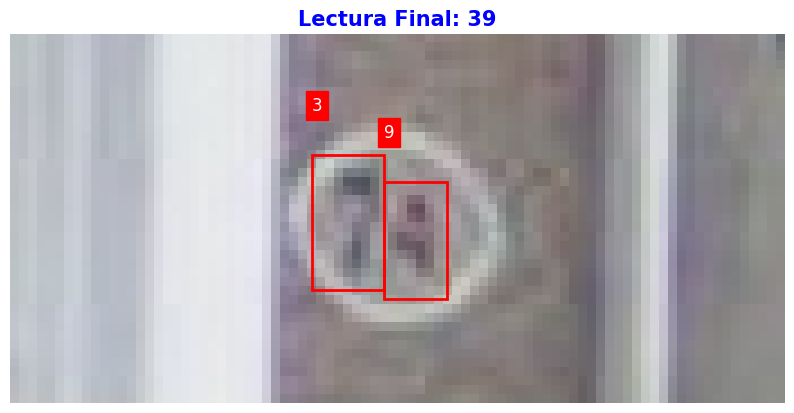


✅ RESULTADO DEL SISTEMA para 4955.png: 39

--- 📸 Procesando: 5559.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '9' (59.3%)
   ➤ Caja 2: Detectado '9' (87.5%)


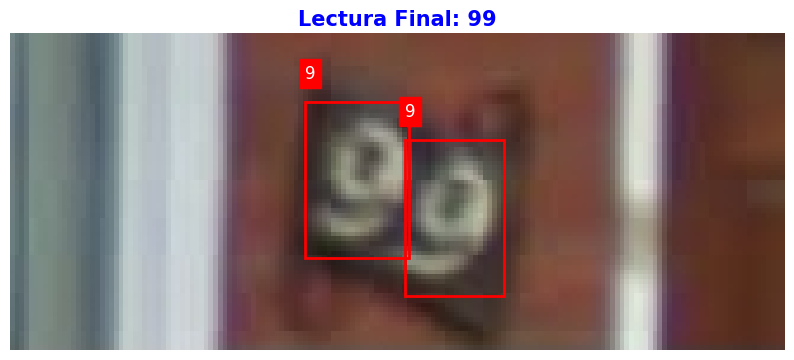


✅ RESULTADO DEL SISTEMA para 5559.png: 99

--- 📸 Procesando: 5237.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '7' (99.9%)
   ➤ Caja 2: Detectado '3' (99.6%)


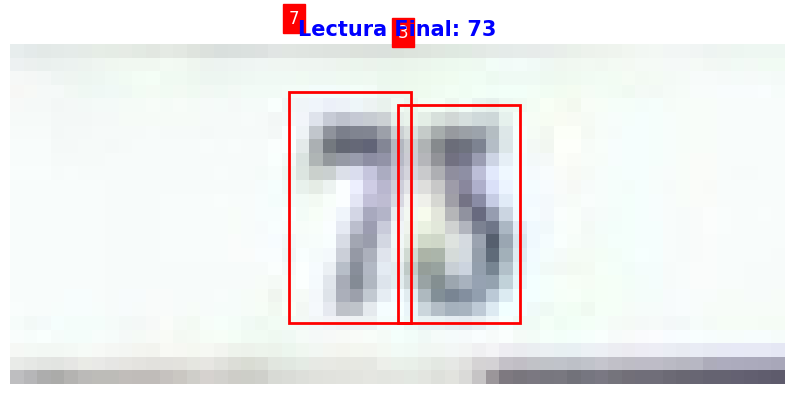


✅ RESULTADO DEL SISTEMA para 5237.png: 73

--- 📸 Procesando: 639.png ---

🔍 Procesando 1 dígitos encontrados...
   ➤ Caja 1: Detectado '9' (99.4%)


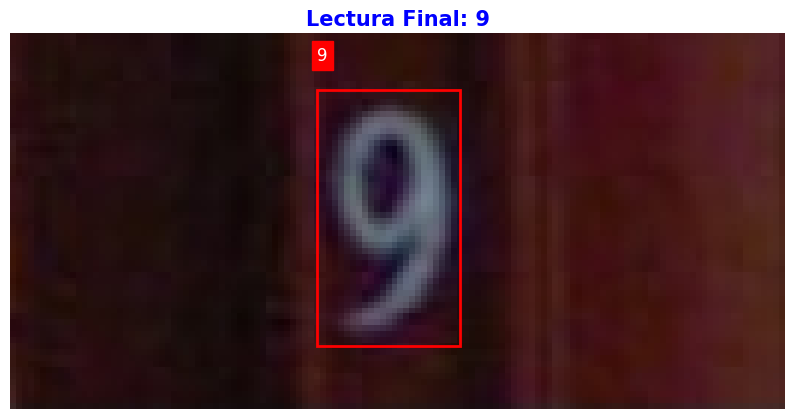


✅ RESULTADO DEL SISTEMA para 639.png: 9

--- 📸 Procesando: 11487.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '2' (94.9%)
   ➤ Caja 2: Detectado '0' (96.1%)


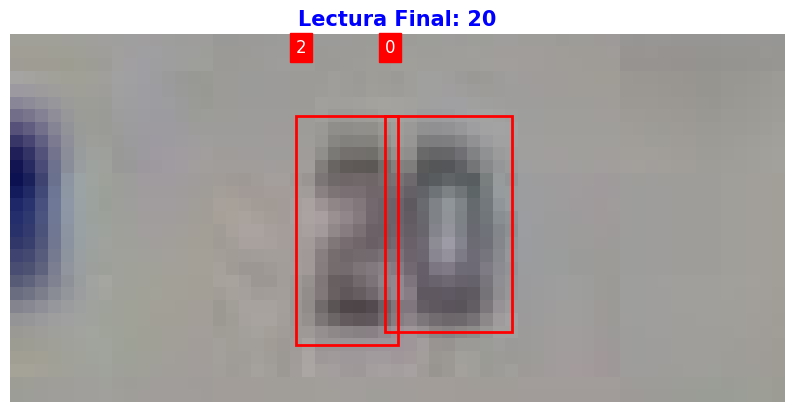


✅ RESULTADO DEL SISTEMA para 11487.png: 20

--- 📸 Procesando: 11463.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '4' (52.3%)
   ➤ Caja 2: Detectado '5' (74.8%)


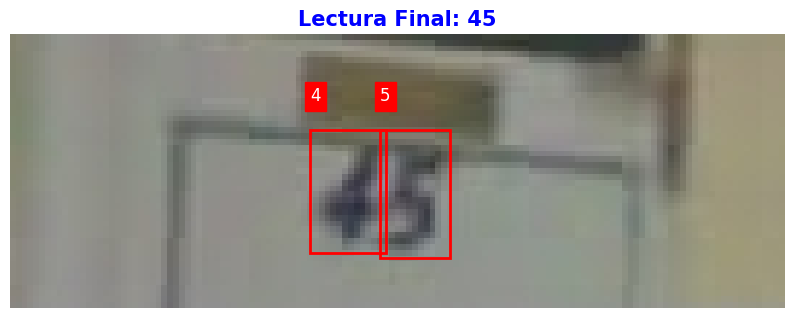


✅ RESULTADO DEL SISTEMA para 11463.png: 45

--- 📸 Procesando: 5670.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '1' (60.7%)
   ➤ Caja 2: Detectado '5' (96.5%)


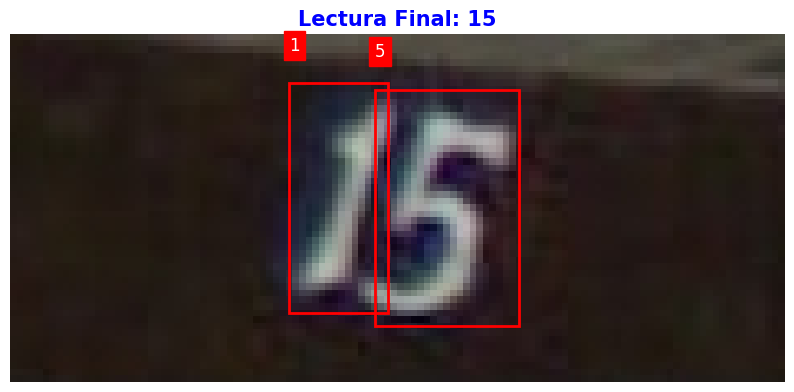


✅ RESULTADO DEL SISTEMA para 5670.png: 15

--- 📸 Procesando: 3571.png ---

🔍 Procesando 1 dígitos encontrados...
   ➤ Caja 1: Detectado '5' (51.4%)


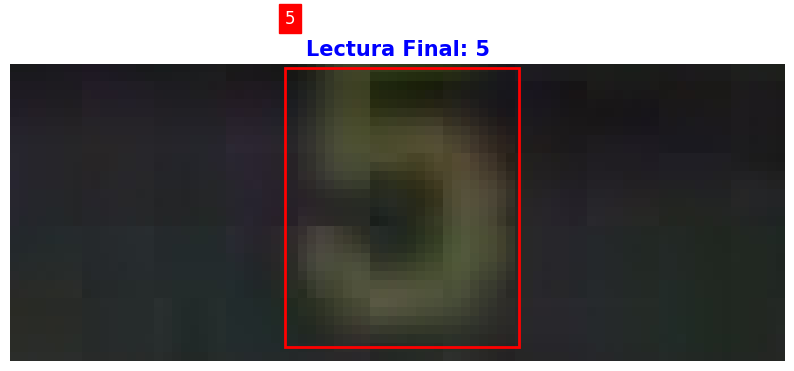


✅ RESULTADO DEL SISTEMA para 3571.png: 5

--- 📸 Procesando: 3087.png ---

🔍 Procesando 1 dígitos encontrados...
   ➤ Caja 1: Detectado '4' (96.4%)


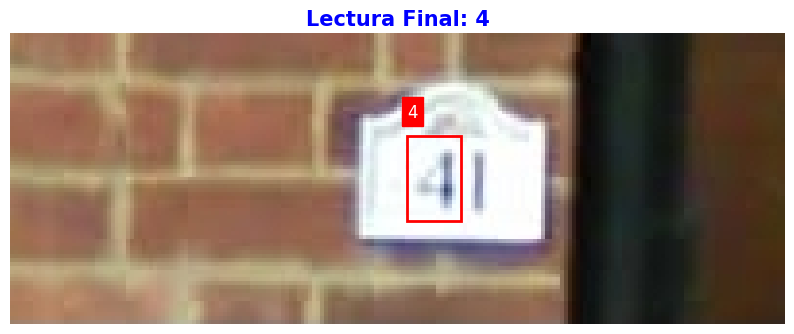


✅ RESULTADO DEL SISTEMA para 3087.png: 4

--- 📸 Procesando: 11968.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '0' (27.1%)
   ➤ Caja 2: Detectado '0' (87.1%)


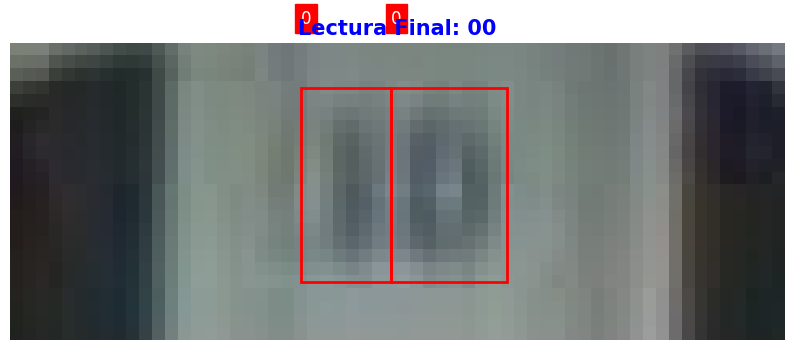


✅ RESULTADO DEL SISTEMA para 11968.png: 00

--- 📸 Procesando: 11596.png ---

🔍 Procesando 1 dígitos encontrados...
   ➤ Caja 1: Detectado '3' (92.0%)


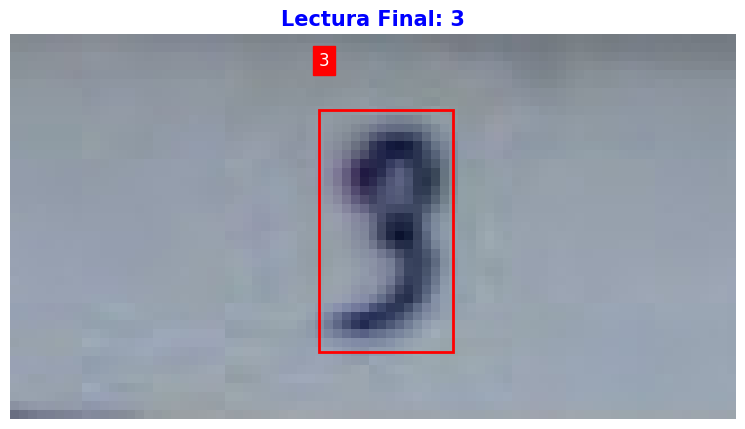


✅ RESULTADO DEL SISTEMA para 11596.png: 3

--- 📸 Procesando: 10989.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '3' (94.4%)
   ➤ Caja 2: Detectado '9' (94.5%)


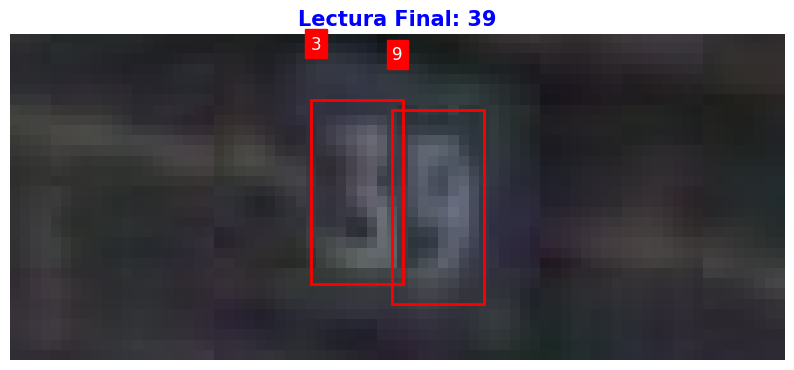


✅ RESULTADO DEL SISTEMA para 10989.png: 39

--- 📸 Procesando: 11004.png ---

🔍 Procesando 3 dígitos encontrados...
   ➤ Caja 1: Detectado '2' (88.8%)
   ➤ Caja 2: Detectado '2' (98.4%)
   ➤ Caja 3: Detectado '0' (74.9%)


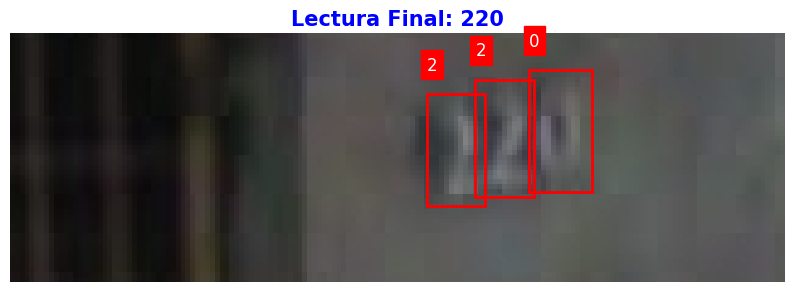


✅ RESULTADO DEL SISTEMA para 11004.png: 220

--- 📸 Procesando: 8121.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '7' (79.5%)
   ➤ Caja 2: Detectado '9' (36.1%)


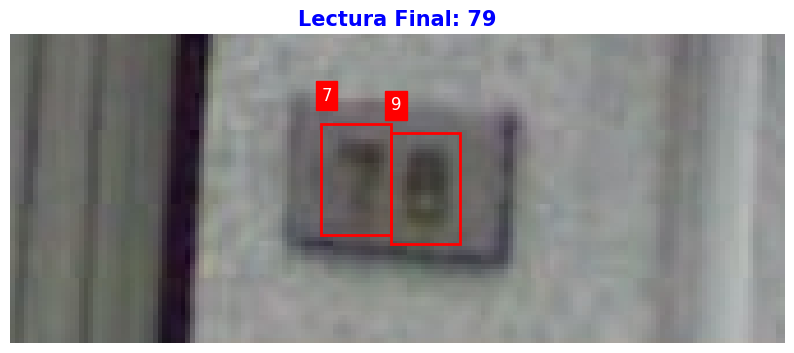


✅ RESULTADO DEL SISTEMA para 8121.png: 79

--- 📸 Procesando: 1839.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '1' (99.8%)
   ➤ Caja 2: Detectado '3' (95.2%)


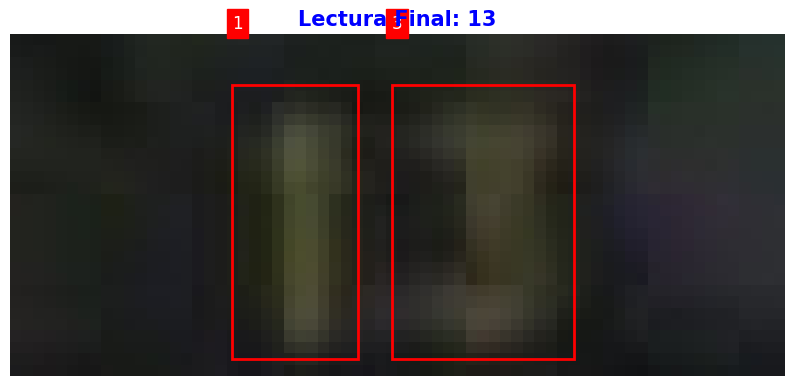


✅ RESULTADO DEL SISTEMA para 1839.png: 13

--- 📸 Procesando: 3314.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '3' (95.6%)
   ➤ Caja 2: Detectado '4' (100.0%)


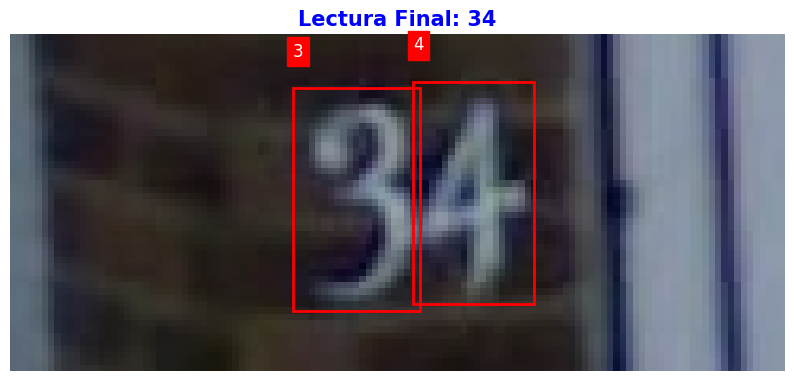


✅ RESULTADO DEL SISTEMA para 3314.png: 34

--- 📸 Procesando: 1647.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '5' (41.1%)
   ➤ Caja 2: Detectado '6' (93.6%)


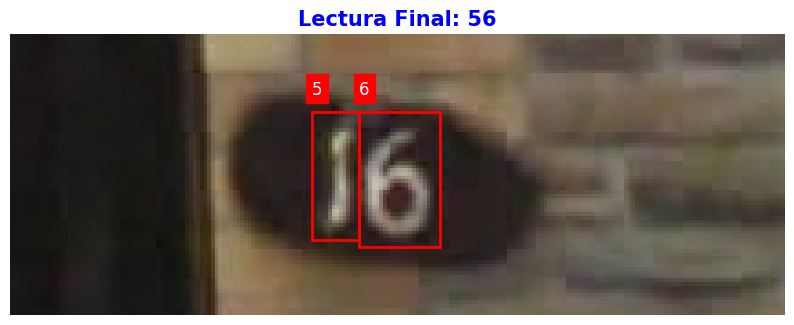


✅ RESULTADO DEL SISTEMA para 1647.png: 56

--- 📸 Procesando: 8468.png ---

🔍 Procesando 3 dígitos encontrados...
   ➤ Caja 1: Detectado '1' (84.8%)
   ➤ Caja 2: Detectado '1' (93.3%)
   ➤ Caja 3: Detectado '5' (100.0%)


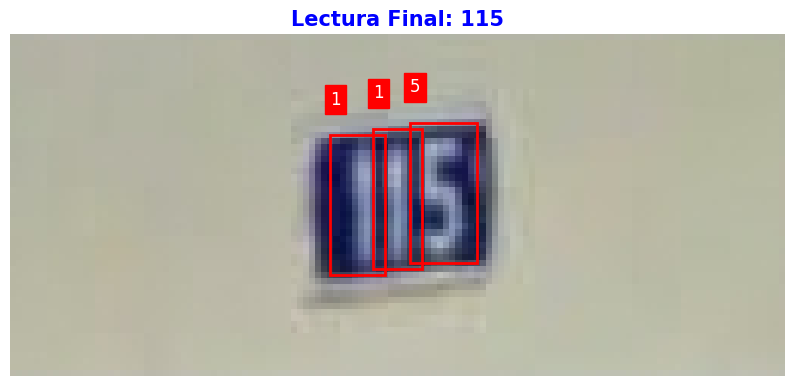


✅ RESULTADO DEL SISTEMA para 8468.png: 115

--- 📸 Procesando: 11416.png ---

🔍 Procesando 1 dígitos encontrados...
   ➤ Caja 1: Detectado '5' (45.7%)


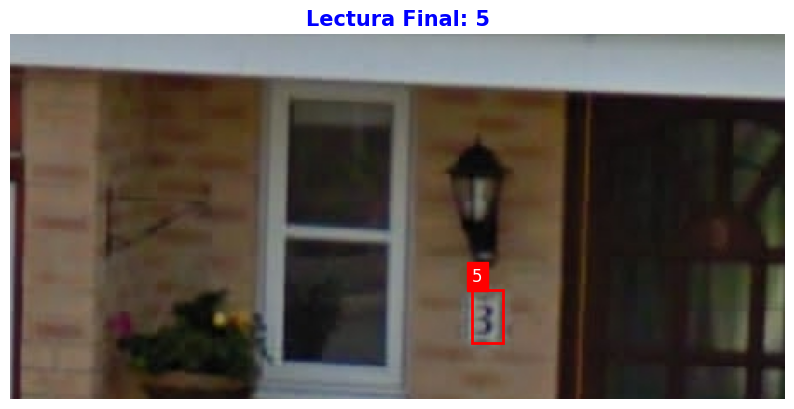


✅ RESULTADO DEL SISTEMA para 11416.png: 5

--- 📸 Procesando: 12903.png ---

🔍 Procesando 3 dígitos encontrados...
   ➤ Caja 1: Detectado '2' (95.1%)
   ➤ Caja 2: Detectado '4' (99.2%)
   ➤ Caja 3: Detectado '8' (73.9%)


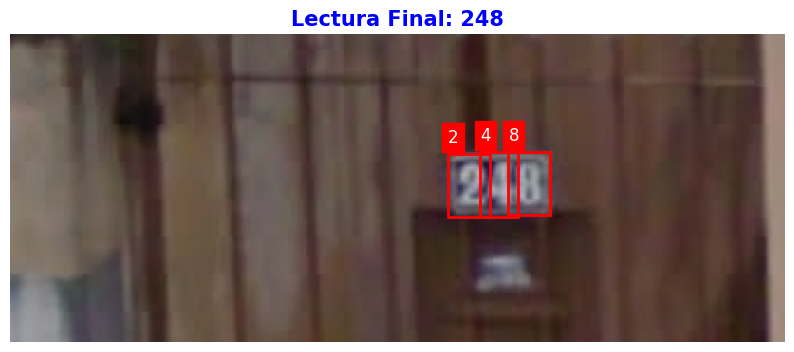


✅ RESULTADO DEL SISTEMA para 12903.png: 248

--- 📸 Procesando: 8338.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '1' (74.2%)
   ➤ Caja 2: Detectado '6' (98.9%)


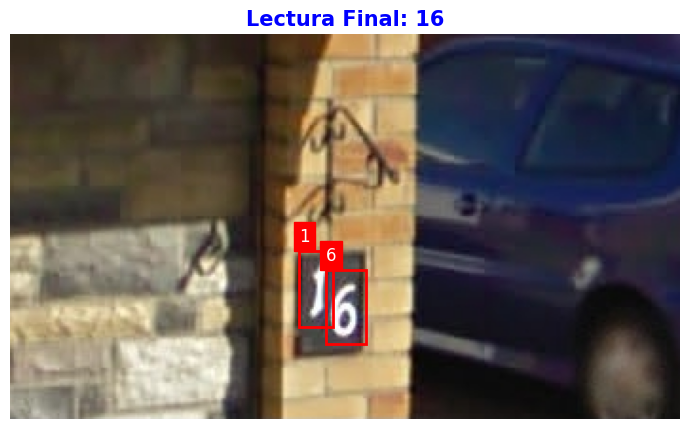


✅ RESULTADO DEL SISTEMA para 8338.png: 16

--- 📸 Procesando: 2560.png ---

🔍 Procesando 1 dígitos encontrados...
   ➤ Caja 1: Detectado '6' (100.0%)


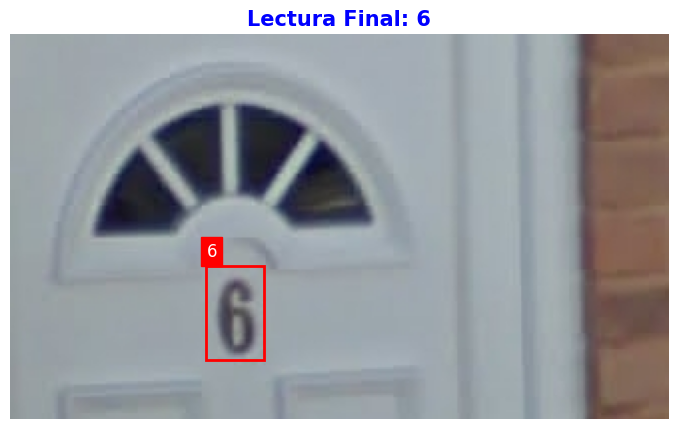


✅ RESULTADO DEL SISTEMA para 2560.png: 6

--- 📸 Procesando: 2539.png ---

🔍 Procesando 3 dígitos encontrados...
   ➤ Caja 1: Detectado '2' (36.7%)
   ➤ Caja 2: Detectado '3' (30.9%)
   ➤ Caja 3: Detectado '6' (98.6%)


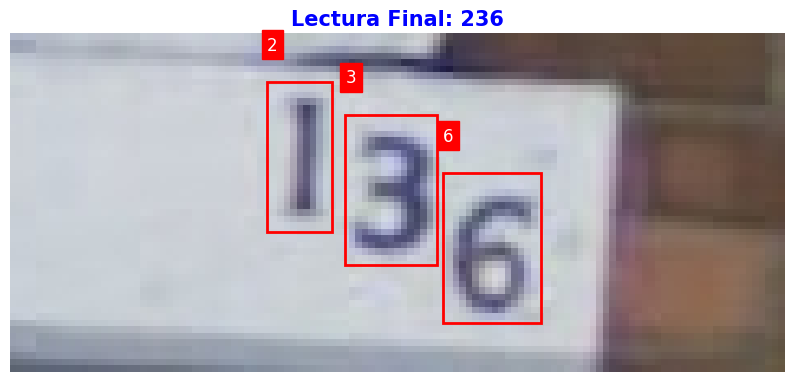


✅ RESULTADO DEL SISTEMA para 2539.png: 236

--- 📸 Procesando: 10286.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '3' (99.9%)
   ➤ Caja 2: Detectado '2' (100.0%)


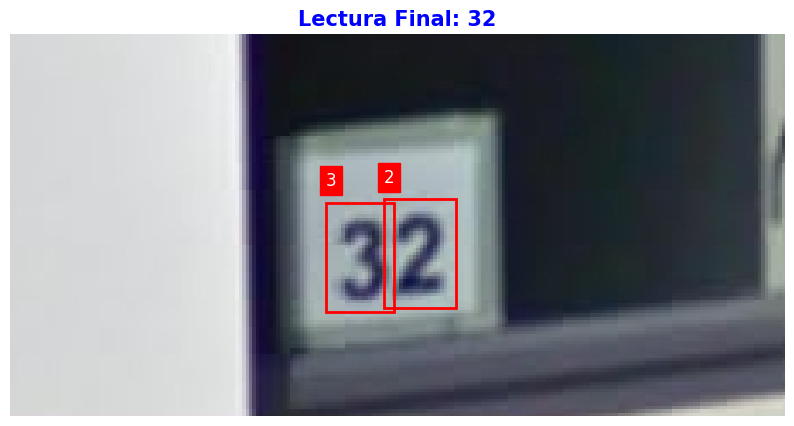


✅ RESULTADO DEL SISTEMA para 10286.png: 32

--- 📸 Procesando: 4513.png ---

🔍 Procesando 1 dígitos encontrados...
   ➤ Caja 1: Detectado '4' (99.4%)


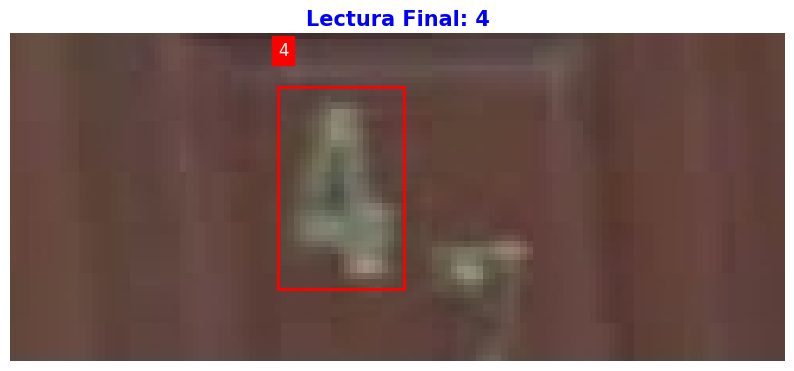


✅ RESULTADO DEL SISTEMA para 4513.png: 4

--- 📸 Procesando: 7458.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '5' (59.4%)
   ➤ Caja 2: Detectado '5' (88.9%)


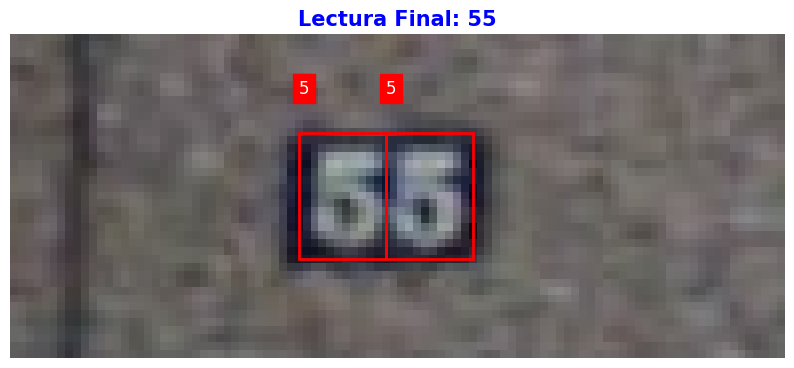


✅ RESULTADO DEL SISTEMA para 7458.png: 55

--- 📸 Procesando: 7559.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '1' (57.3%)
   ➤ Caja 2: Detectado '0' (99.9%)


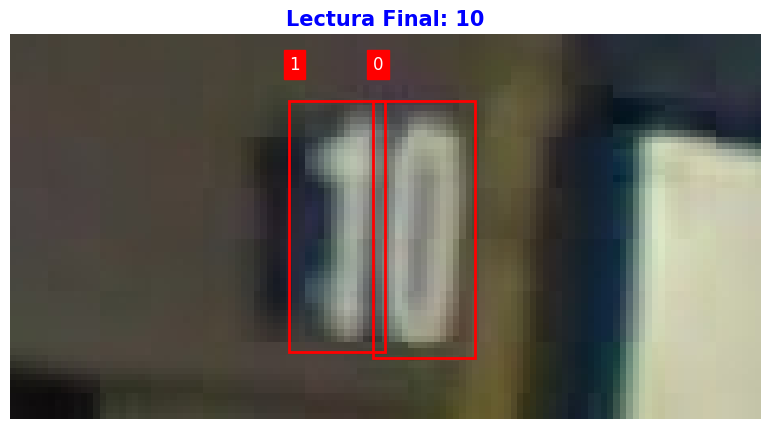


✅ RESULTADO DEL SISTEMA para 7559.png: 10

--- 📸 Procesando: 3979.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '9' (93.0%)
   ➤ Caja 2: Detectado '7' (98.7%)


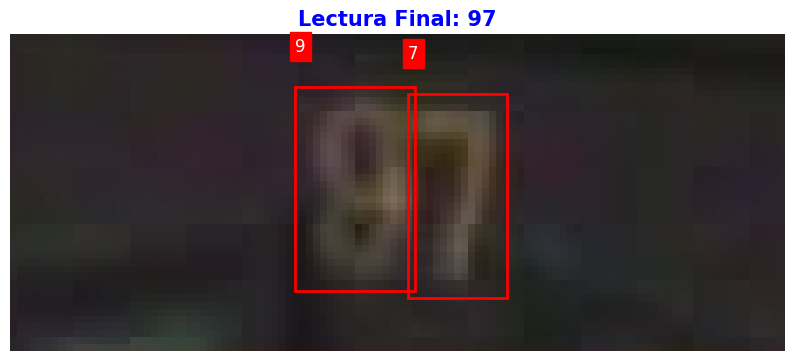


✅ RESULTADO DEL SISTEMA para 3979.png: 97

--- 📸 Procesando: 12022.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '6' (69.4%)
   ➤ Caja 2: Detectado '2' (100.0%)


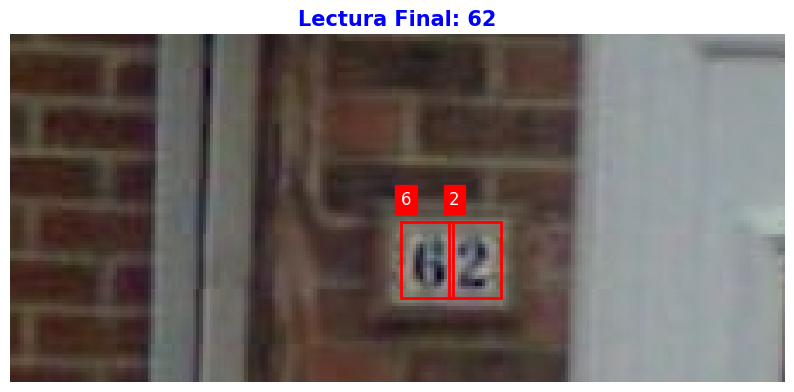


✅ RESULTADO DEL SISTEMA para 12022.png: 62

--- 📸 Procesando: 9725.png ---

🔍 Procesando 1 dígitos encontrados...
   ➤ Caja 1: Detectado '8' (71.1%)


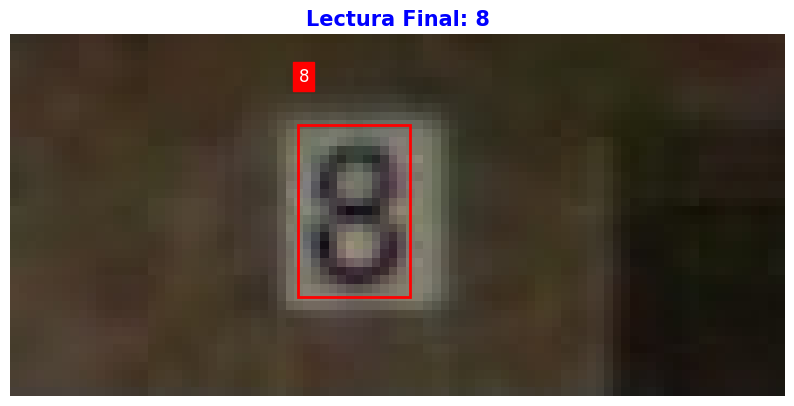


✅ RESULTADO DEL SISTEMA para 9725.png: 8

--- 📸 Procesando: 12142.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '2' (100.0%)
   ➤ Caja 2: Detectado '6' (73.7%)


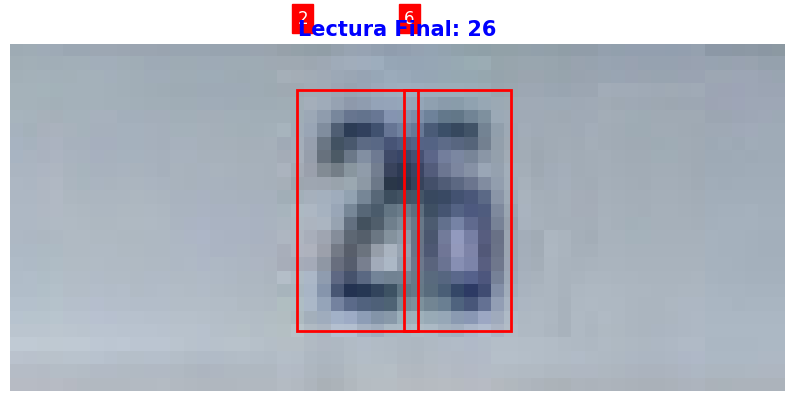


✅ RESULTADO DEL SISTEMA para 12142.png: 26

--- 📸 Procesando: 12561.png ---

🔍 Procesando 3 dígitos encontrados...
   ➤ Caja 1: Detectado '2' (87.0%)
   ➤ Caja 2: Detectado '4' (24.6%)
   ➤ Caja 3: Detectado '5' (64.8%)


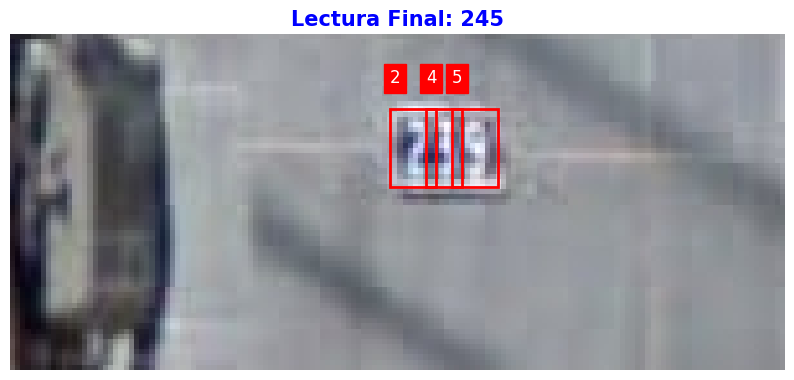


✅ RESULTADO DEL SISTEMA para 12561.png: 245

--- 📸 Procesando: 6376.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '2' (100.0%)
   ➤ Caja 2: Detectado '1' (78.4%)


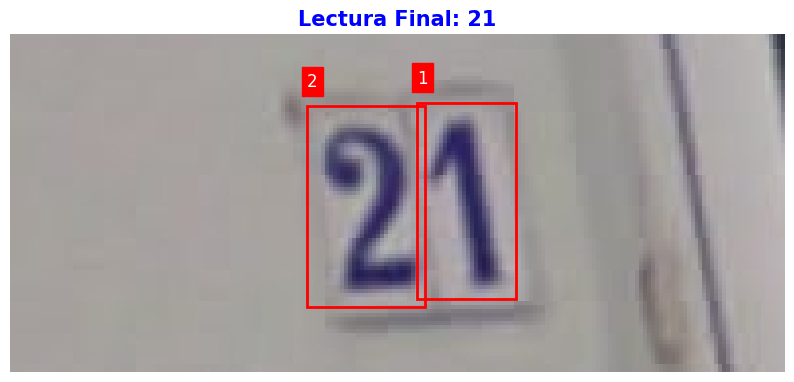


✅ RESULTADO DEL SISTEMA para 6376.png: 21

--- 📸 Procesando: 716.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '9' (86.4%)
   ➤ Caja 2: Detectado '6' (70.5%)


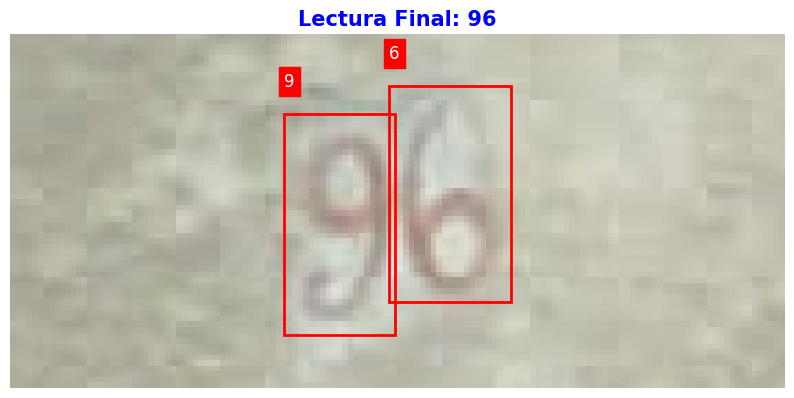


✅ RESULTADO DEL SISTEMA para 716.png: 96

--- 📸 Procesando: 748.png ---

🔍 Procesando 3 dígitos encontrados...
   ➤ Caja 1: Detectado '1' (57.8%)
   ➤ Caja 2: Detectado '2' (100.0%)
   ➤ Caja 3: Detectado '2' (100.0%)


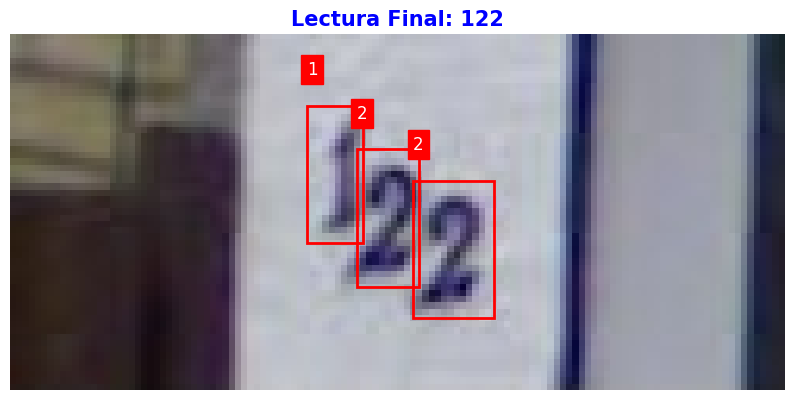


✅ RESULTADO DEL SISTEMA para 748.png: 122

--- 📸 Procesando: 7739.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '3' (36.5%)
   ➤ Caja 2: Detectado '5' (99.6%)


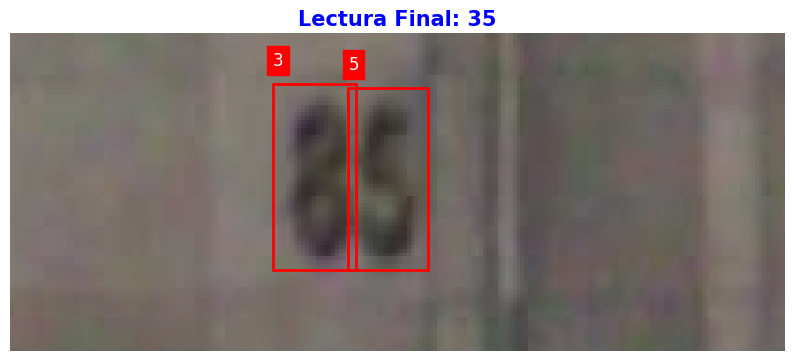


✅ RESULTADO DEL SISTEMA para 7739.png: 35

--- 📸 Procesando: 7223.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '6' (29.1%)
   ➤ Caja 2: Detectado '6' (92.9%)


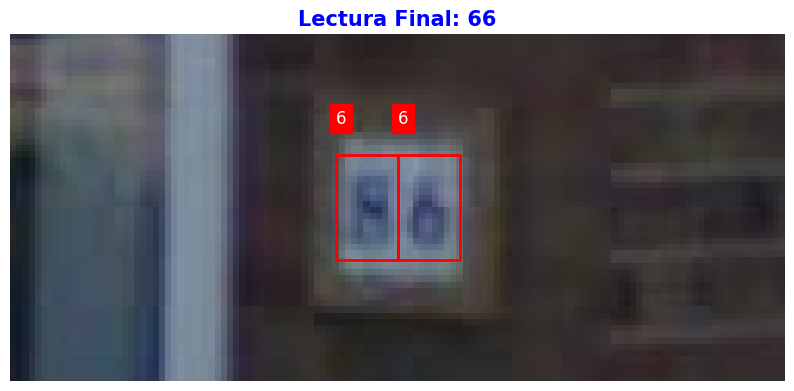


✅ RESULTADO DEL SISTEMA para 7223.png: 66

--- 📸 Procesando: 1157.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '3' (97.8%)
   ➤ Caja 2: Detectado '2' (100.0%)


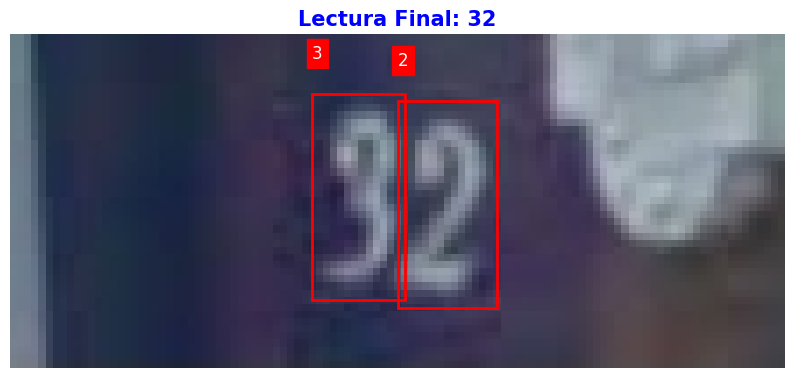


✅ RESULTADO DEL SISTEMA para 1157.png: 32

--- 📸 Procesando: 10614.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '1' (89.5%)
   ➤ Caja 2: Detectado '8' (67.9%)


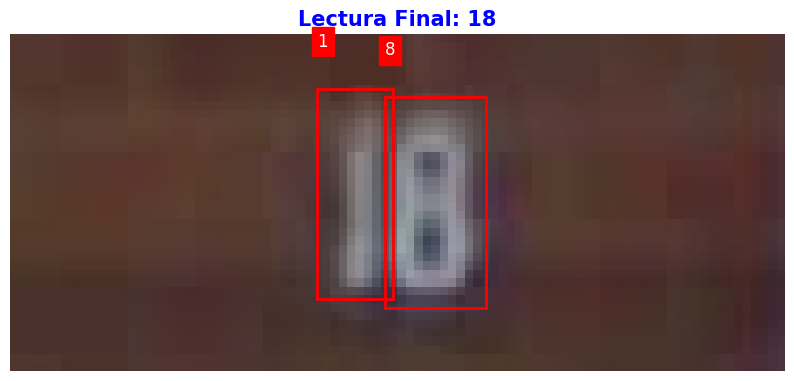


✅ RESULTADO DEL SISTEMA para 10614.png: 18

--- 📸 Procesando: 10572.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '6' (96.2%)
   ➤ Caja 2: Detectado '4' (99.9%)


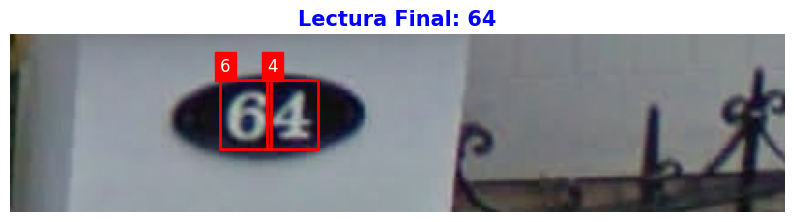


✅ RESULTADO DEL SISTEMA para 10572.png: 64

--- 📸 Procesando: 10136.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '6' (55.4%)
   ➤ Caja 2: Detectado '0' (99.4%)


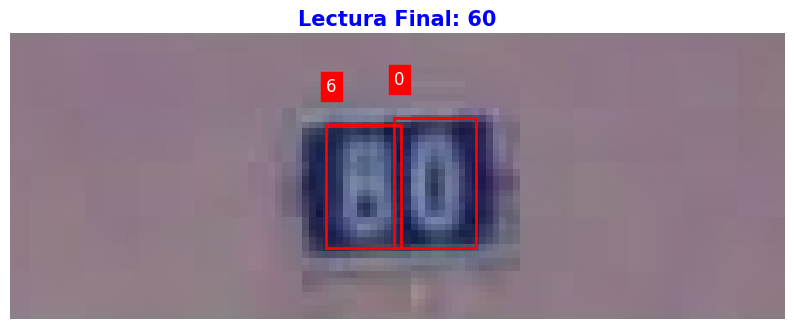


✅ RESULTADO DEL SISTEMA para 10136.png: 60

--- 📸 Procesando: 7990.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '1' (99.8%)
   ➤ Caja 2: Detectado '3' (88.0%)


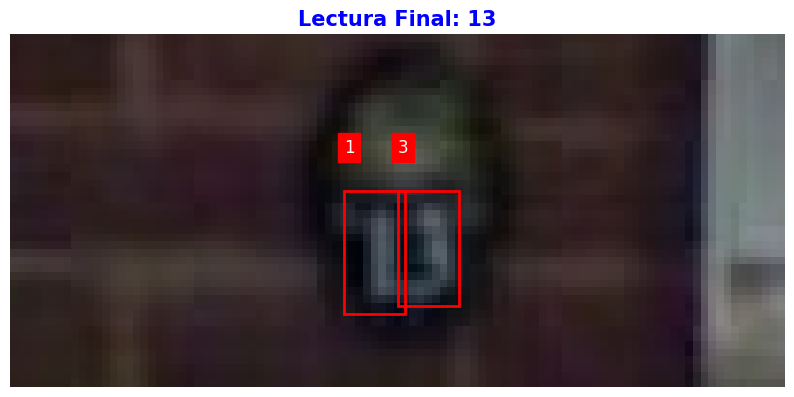


✅ RESULTADO DEL SISTEMA para 7990.png: 13

--- 📸 Procesando: 7433.png ---

🔍 Procesando 3 dígitos encontrados...
   ➤ Caja 1: Detectado '1' (99.3%)
   ➤ Caja 2: Detectado '1' (99.3%)
   ➤ Caja 3: Detectado '2' (52.7%)


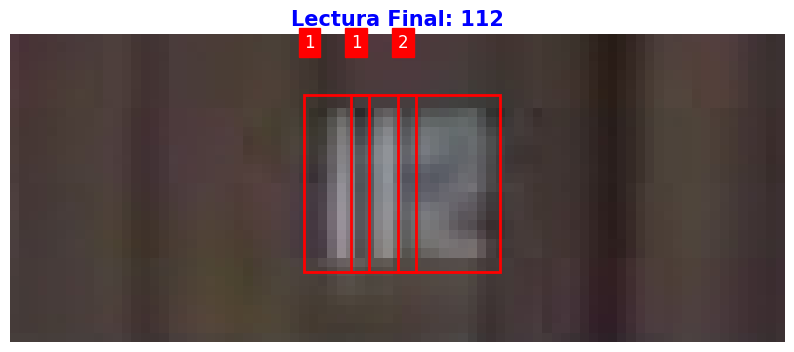


✅ RESULTADO DEL SISTEMA para 7433.png: 112

--- 📸 Procesando: 2437.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '5' (91.6%)
   ➤ Caja 2: Detectado '6' (99.2%)


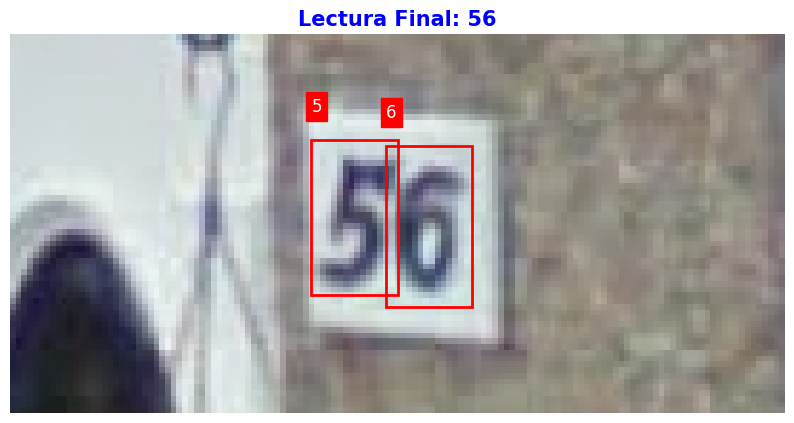


✅ RESULTADO DEL SISTEMA para 2437.png: 56

--- 📸 Procesando: 4574.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '4' (98.9%)
   ➤ Caja 2: Detectado '7' (63.6%)


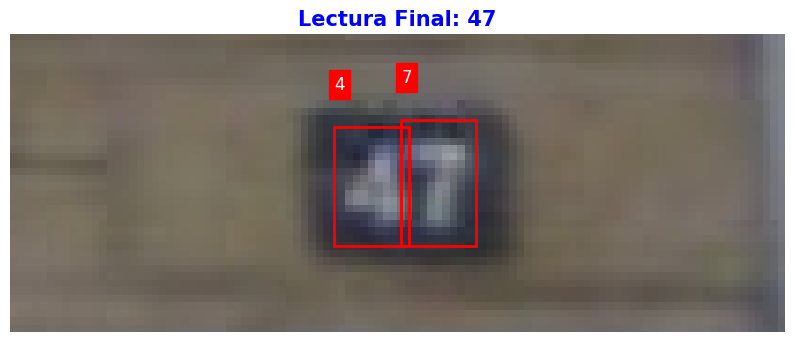


✅ RESULTADO DEL SISTEMA para 4574.png: 47

--- 📸 Procesando: 10961.png ---

🔍 Procesando 2 dígitos encontrados...
   ➤ Caja 1: Detectado '2' (95.9%)
   ➤ Caja 2: Detectado '9' (93.1%)


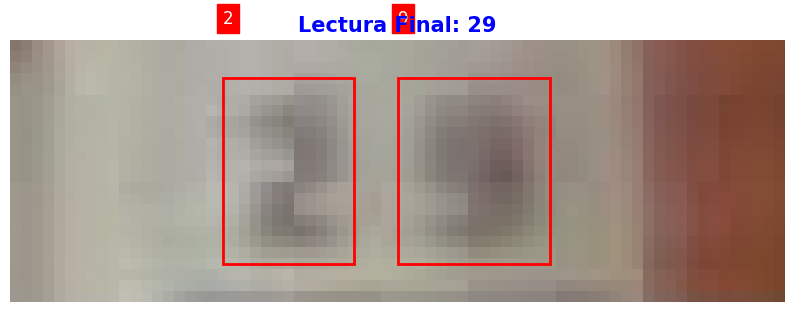


✅ RESULTADO DEL SISTEMA para 10961.png: 29

✅ PRUEBAS MULTIPLES FINALIZADAS. Total imágenes probadas: 50
El resultado visual de cada prueba se mostró arriba.


In [20]:
# ============================================================
# 3. PRUEBA MULTIPLE (50 imágenes aleatorias del Test Set)
# ============================================================
import os
import random

# Definimos la carpeta de prueba
RAIZ_SVHN = "/content/svhn_zip"
TEST_DIR = os.path.join(RAIZ_SVHN, "test", "test")

# Listar todas las imágenes PNG en la carpeta de prueba
try:
    imgs_test = [f for f in os.listdir(TEST_DIR) if f.endswith('.png')]
except FileNotFoundError:
    imgs_test = []
    print(f"❌ ERROR: La carpeta de test no existe en {TEST_DIR}. ¿Está descomprimido el dataset?")


if imgs_test:
    # Seleccionamos hasta 50 imágenes aleatoriamente
    # Si la lista tiene menos de 50, toma todas.
    N_SAMPLES = 50
    test_samples = random.sample(imgs_test, min(N_SAMPLES, len(imgs_test)))

    print(f"\n🔍 Iniciando pruebas en {len(test_samples)} imágenes aleatorias...")

    resultados_globales = {}

    for fn in test_samples:
        ruta_imagen = os.path.join(TEST_DIR, fn)

        try:
            print(f"\n--- 📸 Procesando: {fn} ---")

            # Ejecutar el pipeline completo
            # La función pipeline_yolo_cnn incluye la visualización de la imagen.
            lectura = pipeline_yolo_cnn(ruta_imagen)

            # Almacenar el resultado
            resultados_globales[fn] = lectura
            print(f"\n✅ RESULTADO DEL SISTEMA para {fn}: {lectura}")

        except RuntimeError as e:
            # Captura errores de YOLO (ej. "YOLO no detectó números")
            print(f"❌ FALLO EN {fn}: {e}")

        except Exception as e:
            # Captura otros errores (ej. ruta incorrecta, error de carga)
            print(f"❌ ERROR CRÍTICO EN {fn}: {e}")

    print("\n" + "="*50)
    print(f"✅ PRUEBAS MULTIPLES FINALIZADAS. Total imágenes probadas: {len(test_samples)}")
    print("El resultado visual de cada prueba se mostró arriba.")

else:
    print("⚠️ No se encontraron imágenes PNG en la carpeta de test.")

crn nuevo

⏳ Cargando modelos...
✅ CRNN Listo
✅ YOLO Listo

📸 Procesando: 4297.png


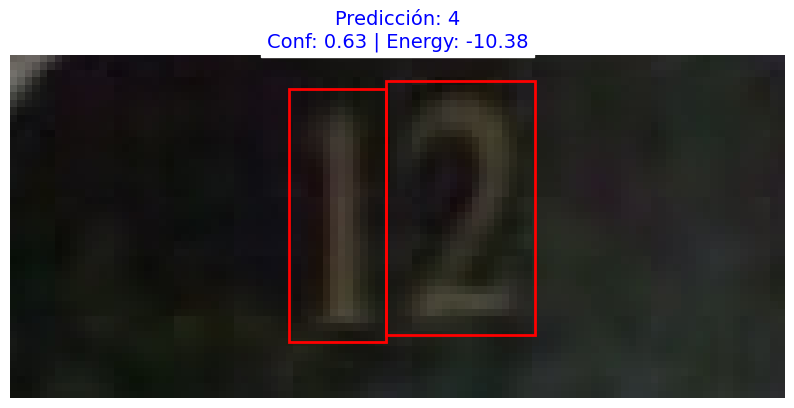


📸 Procesando: 3802.png


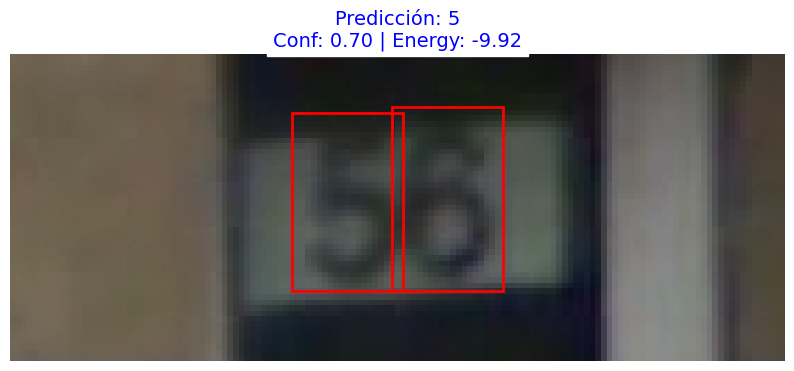


📸 Procesando: 10364.png


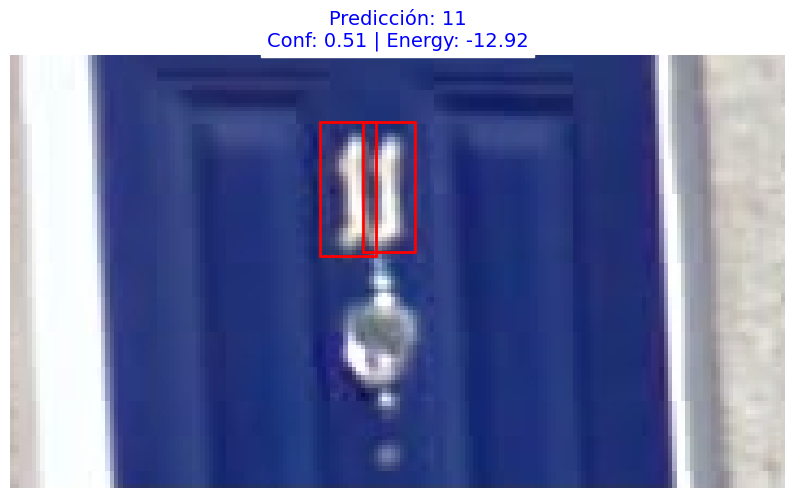

In [15]:
# ==============================================================================
# INFERENCIA VISUAL FINAL: YOLOv8 (640px) + CRNN A100 + PLOT
# ==============================================================================
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --------- CONFIGURACIÓN DE RUTAS ---------
RAIZ_SVHN = "/content/svhn_zip"
SALIDA_YOLO = "/content/svhn_yolo_dataset"

# 1. Ruta al CRNN (.keras)
RUTA_CRNN = os.path.join(RAIZ_SVHN, "crnn_a100_final.keras") # Corrected model file name

# 2. Ruta al YOLOv8 Small (Auto-búsqueda)
posibles_rutas_yolo = [
    os.path.join(SALIDA_YOLO, "runs", "svhn_yolov8s_640_pro", "weights", "best.pt"),
    os.path.join(SALIDA_YOLO, "runs", "svhn_yolov8s_640_ram", "weights", "best.pt"),
    os.path.join(SALIDA_YOLO, "runs", "detect", "svhn_yolov8s_640_pro", "weights", "best.pt")
]

RUTA_YOLOV8_PT = None
for p in posibles_rutas_yolo:
    if os.path.exists(p):
        RUTA_YOLOV8_PT = p
        break

# --------- PARÁMETROS ---------
CRNN_H, CRNN_W = 32, 128
ALFABETO = "0123456789"
INDICE_BLANCO = 10
NUM_CLASES = len(ALFABETO) + 1
YOLO_IMGSZ = 640

# --------- 1. RECONSTRUCCIÓN ARQUITECTURA CRNN ---------
def build_crnn():
    inputs = keras.Input(shape=(CRNN_H, CRNN_W, 3))
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x); x = layers.MaxPool2D((2,2))(x)
    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x); x = layers.MaxPool2D((2,2))(x)
    x = layers.SpatialDropout2D(0.1)(x)
    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x); x = layers.MaxPool2D((2,1))(x)
    x = layers.SpatialDropout2D(0.1)(x)
    x = layers.Conv2D(512, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(512, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x); x = layers.MaxPool2D((2,1))(x)
    x = layers.Conv2D(512, 2, padding="valid", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Lambda(lambda t: tf.squeeze(t, axis=1))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)
    logits = layers.Dense(NUM_CLASES, name="logits", dtype='float32')(x)
    return keras.Model(inputs, logits)

# --------- 2. CARGA DE MODELOS ---------
print("⏳ Cargando modelos...")

if not os.path.exists(RUTA_CRNN):
    raise FileNotFoundError(f"❌ Falta CRNN: {RUTA_CRNN}")
if RUTA_YOLOV8_PT is None:
    raise FileNotFoundError(f"❌ Falta YOLO en {SALIDA_YOLO}/runs")

try:
    crnn = build_crnn()
    crnn.load_weights(RUTA_CRNN)
    print(f"✅ CRNN Listo")
except Exception as e:
    raise RuntimeError(f"❌ Error CRNN: {e}")

try:
    yolo = YOLO(RUTA_YOLOV8_PT)
    print(f"✅ YOLO Listo")
except Exception as e:
    raise RuntimeError(f"❌ Error YOLO: {e}")

# --------- 3. FUNCIONES AUXILIARES ---------
def colapsar_y_decodificar(logits):
    probs = tf.nn.softmax(logits, axis=-1)
    pred_ids = tf.argmax(probs, axis=-1).numpy()[0]
    out = []; prev = -1
    for ch in pred_ids:
        ch = int(ch)
        if ch != prev and ch != INDICE_BLANCO: out.append(ch)
        prev = ch
    return ''.join(ALFABETO[i] for i in out)

def metricas_ood(logits, T=1.0):
    logits = tf.cast(logits, tf.float32)
    probs = tf.nn.softmax(logits, axis=-1)
    msp = float(tf.reduce_mean(tf.reduce_max(probs, axis=2)).numpy())
    lse = tf.math.reduce_logsumexp(logits / T, axis=2)
    neg_energy = float(tf.reduce_mean(-T * lse).numpy())
    return neg_energy, msp

class Caja:
    def __init__(self, x1, y1, x2, y2, conf):
        self.xmin, self.ymin, self.xmax, self.ymax = int(x1), int(y1), int(x2), int(y2)
        self.conf = float(conf)

# --------- 4. PIPELINE DE INFERENCIA ---------
def pipeline_estricto(ruta_imagen, conf_yolo=0.5):
    if not os.path.exists(ruta_imagen):
        raise FileNotFoundError(f"Imagen no encontrada: {ruta_imagen}")

    # A. YOLO
    pil_img = Image.open(ruta_imagen).convert("RGB")
    np_img = np.array(pil_img)

    results = yolo.predict(np_img, imgsz=YOLO_IMGSZ, conf=conf_yolo, verbose=False)[0]

    cajas = []
    if results.boxes:
        for box in results.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cajas.append(Caja(x1, y1, x2, y2, conf))

    cajas.sort(key=lambda c: c.xmin)

    if not cajas:
        raise RuntimeError("⚠️ YOLO no encontró dígitos.")

    # B. RECORTE Y COSIDO
    recortes = []
    H_orig, W_orig = np_img.shape[:2]

    for c in cajas:
        x1, y1 = max(0, c.xmin), max(0, c.ymin)
        x2, y2 = min(W_orig, c.xmax), min(H_orig, c.ymax)
        crop = np_img[y1:y2, x1:x2]
        if crop.size == 0: continue

        new_w = max(1, int(crop.shape[1] * (CRNN_H / crop.shape[0])))
        crop_pil = Image.fromarray(crop).resize((new_w, CRNN_H), Image.BILINEAR)
        recortes.append(np.array(crop_pil))

    if not recortes: raise RuntimeError("⚠️ Error procesando recortes.")

    pad = 2
    total_w = sum(r.shape[1] for r in recortes) + (pad * (len(recortes)-1))
    lienzo = np.ones((CRNN_H, total_w, 3), dtype=np.uint8) * 128

    curr_x = 0
    for r in recortes:
        lienzo[:, curr_x:curr_x+r.shape[1]] = r
        curr_x += r.shape[1] + pad

    # C. CRNN PREP
    img_tf = tf.convert_to_tensor(lienzo)
    img_tf = tf.image.convert_image_dtype(img_tf, tf.float32)

    target_w = tf.shape(img_tf)[1]
    if target_w > CRNN_W: img_res = tf.image.resize(img_tf, (CRNN_H, CRNN_W))
    else: img_res = img_tf

    curr_w = tf.shape(img_res)[1]
    if curr_w < CRNN_W:
        pad_w = CRNN_W - curr_w
        img_input = tf.pad(img_res, [[0,0], [0,pad_w], [0,0]], constant_values=0.5)
    else:
        img_input = img_res

    img_input = (img_input - 0.5) / 0.5
    img_input = tf.expand_dims(img_input, 0)

    # D. INFERENCIA
    logits = crnn.predict(img_input, verbose=0)
    texto = colapsar_y_decodificar(logits)
    neg_e, msp = metricas_ood(logits)

    return {
        "texto": texto,
        "conf_yolo": np.mean([c.conf for c in cajas]),
        "neg_energy": neg_e,
        "cajas_coords": [(c.xmin, c.ymin, c.xmax, c.ymax) for c in cajas] # <--- ¡NUEVO!
    }

# --------- 5. VISUALIZACIÓN (¡ESTO ES LO QUE QUERÍAS!) ---------
def visualizar_resultado(img_path, resultado):
    img = Image.open(img_path)

    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    ax = plt.gca()

    # Dibujar Cajas
    for (x1, y1, x2, y2) in resultado['cajas_coords']:
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    # Texto Predicho
    info = f"Predicción: {resultado['texto']}\nConf: {resultado['conf_yolo']:.2f} | Energy: {resultado['neg_energy']:.2f}"
    plt.title(info, fontsize=14, color='blue', backgroundcolor='white')
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    test_dir = os.path.join(RAIZ_SVHN, "test", "test")
    imgs_test = [f for f in os.listdir(test_dir) if f.endswith(".png")]

    if imgs_test:
        import random
        # Probamos 3 imágenes
        for _ in range(3):
            fn = random.choice(imgs_test)
            path = os.path.join(test_dir, fn)
            print(f"\n📸 Procesando: {fn}")
            try:
                # Inferencia
                res = pipeline_estricto(path, conf_yolo=0.3)
                # Visualización Gráfica
                visualizar_resultado(path, res)
            except Exception as e:
                print(f"⚠️ {e}")
    else:
        print("No hay imágenes para probar.")


resnet

⏳ Cargando modelos...
✅ CRNN Listo (ResNet/GRU)
✅ YOLO Listo

📸 Procesando: 10057.png


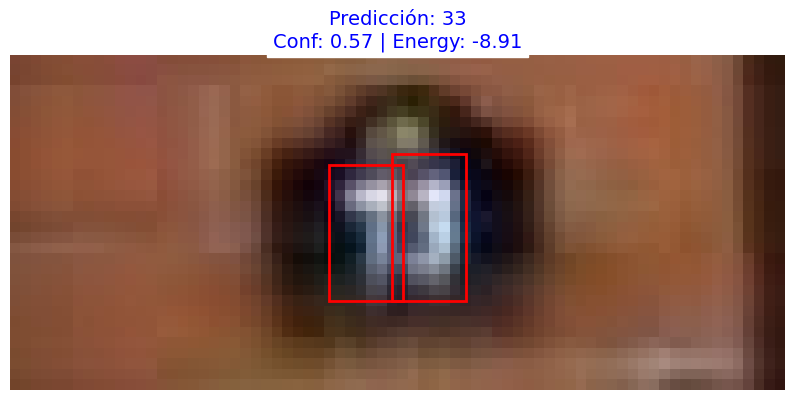


📸 Procesando: 11592.png


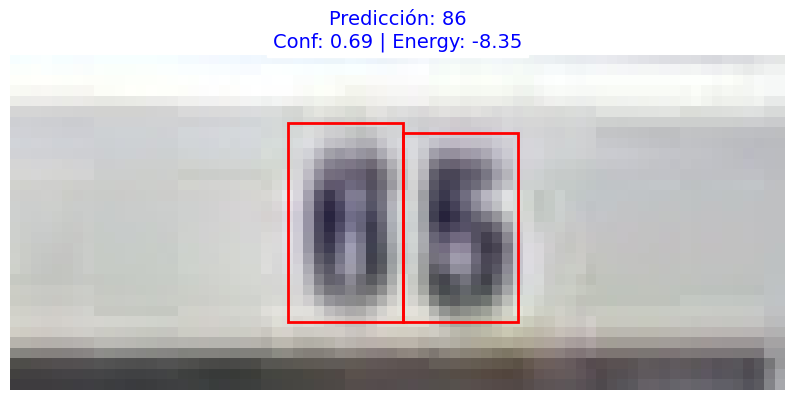


📸 Procesando: 7506.png


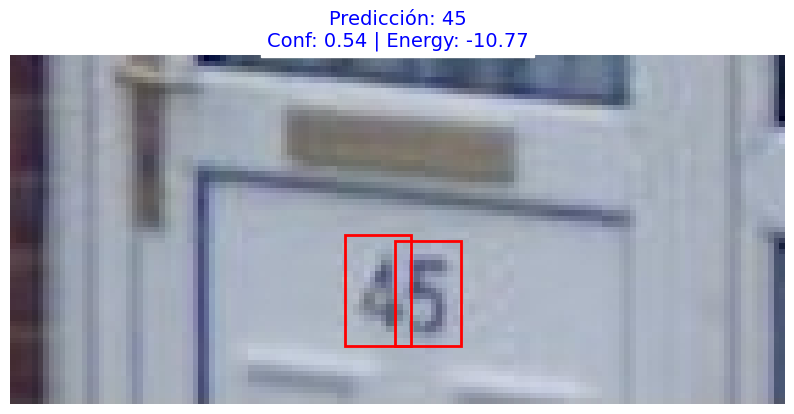

In [26]:
# ==============================================================================
# INFERENCIA VISUAL FINAL: YOLOv8 + CRNN (ResNet/GRU) + PLOT
# ==============================================================================
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --------- CONFIGURACIÓN DE RUTAS ---------
RAIZ_SVHN = "/content/svhn_zip"
SALIDA_YOLO = "/content/svhn_yolo_dataset"

# 1. Ruta al CRNN (APUNTA AL MODELO RESNET/GRU)
RUTA_CRNN = os.path.join(RAIZ_SVHN, "crnn_resnet_final.keras") # <--- RUTA ACTUALIZADA

# 2. Ruta al YOLOv8 Small (Auto-búsqueda - No necesita cambios)
posibles_rutas_yolo = [
    os.path.join(SALIDA_YOLO, "runs", "svhn_yolov8s_640_pro", "weights", "best.pt"),
    os.path.join(SALIDA_YOLO, "runs", "svhn_yolov8s_640_ram", "weights", "best.pt"),
    os.path.join(SALIDA_YOLO, "runs", "detect", "svhn_yolov8s_640_pro", "weights", "best.pt")
]

RUTA_YOLOV8_PT = None
for p in posibles_rutas_yolo:
    if os.path.exists(p):
        RUTA_YOLOV8_PT = p
        break

# --------- PARÁMETROS ---------
CRNN_H, CRNN_W = 32, 128
ALFABETO = "0123456789"
INDICE_BLANCO = 10
YOLO_IMGSZ = 640
TEMPERATURA = 1.0


# --------- 1. RECONSTRUCCIÓN ARQUITECTURA CRNN (RESNET/GRU) ---------

def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    """Define un Bloque Residual"""
    shortcut = x
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same", use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_crnn_resnet():
    """Arquitectura ResNet/GRU (La versión Next-Gen)"""
    inputs = keras.Input(shape=(CRNN_H, CRNN_W, 3))

    # Entrada
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)

    # Bloques ResNet (Asegura la estructura para cargar los pesos)
    x = residual_block(x, 128)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)

    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = layers.MaxPool2D(pool_size=(2, 1))(x)
    x = layers.SpatialDropout2D(0.1)(x)

    x = residual_block(x, 512)
    x = residual_block(x, 512)
    x = layers.MaxPool2D(pool_size=(2, 1))(x)

    x = residual_block(x, 1024)
    x = layers.MaxPool2D(pool_size=(2, 1))(x)

    # Adaptación para RNN
    x = layers.Lambda(lambda t: tf.squeeze(t, axis=1))(x)

    # GRU Bidireccional (512 unidades)
    x = layers.Bidirectional(layers.GRU(512, return_sequences=True, dropout=0.3))(x)
    x = layers.Bidirectional(layers.GRU(512, return_sequences=True, dropout=0.3))(x)

    logits = layers.Dense(NUM_CLASES, activation="linear", dtype='float32')(x)
    return keras.Model(inputs, logits)


# --------- 2. CARGA DE MODELOS ---------
print("⏳ Cargando modelos...")

if not os.path.exists(RUTA_CRNN):
    raise FileNotFoundError(f"❌ Falta CRNN: {RUTA_CRNN}")
if RUTA_YOLOV8_PT is None:
    raise FileNotFoundError(f"❌ Falta YOLO en {SALIDA_YOLO}/runs")

# --- A. CARGA CRNN (CON FIX DE ARQUITECTURA) ---
try:
    # 1. Reconstruir el esqueleto
    crnn = build_crnn_resnet()
    # 2. Cargar los pesos (Necesario si el modelo se guardó solo con pesos o si load_model falla)
    crnn.load_weights(RUTA_CRNN)
    print(f"✅ CRNN Listo (ResNet/GRU)")
except Exception as e:
    raise RuntimeError(f"❌ Error CRNN: {e}")

# --- B. CARGA YOLO ---
try:
    yolo = YOLO(RUTA_YOLOV8_PT)
    print(f"✅ YOLO Listo")
except Exception as e:
    raise RuntimeError(f"❌ Error YOLO: {e}")

# --------- 3. FUNCIONES AUXILIARES ---------
def colapsar_y_decodificar(logits):
    probs = tf.nn.softmax(logits, axis=-1)
    pred_ids = tf.argmax(probs, axis=-1).numpy()[0]
    out = []; prev = -1
    for ch in pred_ids:
        ch = int(ch)
        if ch != prev and ch != INDICE_BLANCO: out.append(ch)
        prev = ch
    return ''.join(ALFABETO[i] for i in out)

def metricas_ood(logits, T=1.0):
    logits = tf.cast(logits, tf.float32)
    probs = tf.nn.softmax(logits, axis=-1)
    msp = float(tf.reduce_mean(tf.reduce_max(probs, axis=2)).numpy())
    lse = tf.math.reduce_logsumexp(logits / T, axis=2)
    neg_energy = float(tf.reduce_mean(-T * lse).numpy())
    return neg_energy, msp

class Caja:
    def __init__(self, x1, y1, x2, y2, conf):
        self.xmin, self.ymin, self.xmax, self.ymax = int(x1), int(y1), int(x2), int(y2)
        self.conf = float(conf)

# --------- 4. PIPELINE DE INFERENCIA ---------
def pipeline_estricto(ruta_imagen, conf_yolo=0.5):
    if not os.path.exists(ruta_imagen):
        raise FileNotFoundError(f"Imagen no encontrada: {ruta_imagen}")

    # A. YOLO
    pil_img = Image.open(ruta_imagen).convert("RGB")
    np_img = np.array(pil_img)

    results = yolo.predict(np_img, imgsz=YOLO_IMGSZ, conf=conf_yolo, verbose=False)[0]

    cajas = []
    if results.boxes:
        for box in results.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cajas.append(Caja(x1, y1, x2, y2, conf))

    cajas.sort(key=lambda c: c.xmin)

    if not cajas:
        raise RuntimeError("⚠️ YOLO no encontró dígitos.")

    # B. RECORTE Y COSIDO
    recortes = []
    H_orig, W_orig = np_img.shape[:2]

    for c in cajas:
        x1, y1 = max(0, c.xmin), max(0, c.ymin)
        x2, y2 = min(W_orig, c.xmax), min(H_orig, c.ymax)
        crop = np_img[y1:y2, x1:x2]
        if crop.size == 0: continue

        new_w = max(1, int(crop.shape[1] * (CRNN_H / crop.shape[0])))
        crop_pil = Image.fromarray(crop).resize((new_w, CRNN_H), Image.BILINEAR)
        recortes.append(np.array(crop_pil))

    if not recortes: raise RuntimeError("⚠️ Error procesando recortes.")

    pad = 2
    total_w = sum(r.shape[1] for r in recortes) + (pad * (len(recortes)-1))
    lienzo = np.ones((CRNN_H, total_w, 3), dtype=np.uint8) * 128

    curr_x = 0
    for r in recortes:
        lienzo[:, curr_x:curr_x+r.shape[1]] = r
        curr_x += r.shape[1] + pad

    # C. CRNN PREP
    img_tf = tf.convert_to_tensor(lienzo)
    img_tf = tf.image.convert_image_dtype(img_tf, tf.float32)

    target_w = tf.shape(img_tf)[1]
    if target_w > CRNN_W: img_res = tf.image.resize(img_tf, (CRNN_H, CRNN_W))
    else: img_res = img_tf

    curr_w = tf.shape(img_res)[1]
    if curr_w < CRNN_W:
        pad_w = CRNN_W - curr_w
        img_input = tf.pad(img_res, [[0,0], [0,pad_w], [0,0]], constant_values=0.5)
    else:
        img_input = img_res

    img_input = (img_input - 0.5) / 0.5
    img_input = tf.expand_dims(img_input, 0)

    # D. INFERENCIA
    logits = crnn.predict(img_input, verbose=0)
    texto = colapsar_y_decodificar(logits)
    neg_e, msp = metricas_ood(logits)

    return {
        "texto": texto,
        "conf_yolo": np.mean([c.conf for c in cajas]),
        "neg_energy": neg_e,
        "cajas_coords": [(c.xmin, c.ymin, c.xmax, c.ymax) for c in cajas]
    }

# --------- 5. VISUALIZACIÓN ---------
def visualizar_resultado(img_path, resultado):
    img = Image.open(img_path)

    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    ax = plt.gca()

    for (x1, y1, x2, y2) in resultado['cajas_coords']:
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    info = f"Predicción: {resultado['texto']}\nConf: {resultado['conf_yolo']:.2f} | Energy: {resultado['neg_energy']:.2f}"
    plt.title(info, fontsize=14, color='blue', backgroundcolor='white')
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    test_dir = os.path.join(RAIZ_SVHN, "test", "test")
    imgs_test = [f for f in os.listdir(test_dir) if f.endswith(".png")]

    if imgs_test:
        import random
        for _ in range(3):
            fn = random.choice(imgs_test)
            path = os.path.join(test_dir, fn)
            print(f"\n📸 Procesando: {fn}")
            try:
                res = pipeline_estricto(path, conf_yolo=0.3)
                visualizar_resultado(path, res)
            except Exception as e:
                print(f"⚠️ Error en {fn}: {e}")
    else:
        print("No hay imágenes para probar.")

In [55]:
import os
import subprocess
from google.colab import files
from pathlib import Path
import time

# --- CONFIGURACIÓN ---
# ⚠️ CAMBIA ESTO: Ruta de la carpeta que quieres comprimir (Ej: /content/svhn_zip)
CARPETA_A_COMPRIMIR = "/content/svhn_yolo_dataset" #"svhn_zip"
# Nombre que tendrá el archivo ZIP de salida
NOMBRE_ZIP = "backup_descarga.zip"

# Ruta donde se creará el archivo ZIP
RUTA_DESTINO_ZIP = os.path.join("/content", NOMBRE_ZIP)

# ======================================================
# FUNCIÓN DE COMPRESIÓN Y DESCARGA
# ======================================================

def comprimir_y_descargar(ruta_carpeta: str, ruta_zip: str):
    """
    Comprime la carpeta especificada en un archivo ZIP y lo descarga.

    Args:
        ruta_carpeta (str): La carpeta de origen dentro de Colab.
        ruta_zip (str): La ruta donde se creará el archivo ZIP.
    """

    # 1. Validación
    if not os.path.isdir(ruta_carpeta):
        print(f"❌ ERROR: La carpeta de origen no existe: {ruta_carpeta}")
        return

    # 2. Comando de Compresión
    # El comando 'zip -r' comprime la carpeta de forma recursiva.
    # El flag -r es crucial para incluir subdirectorios.
    zip_command = ["zip", "-r", ruta_zip, ruta_carpeta]

    print(f"⏳ Comprimiendo '{Path(ruta_carpeta).name}'...")

    try:
        # Ejecutar el comando zip
        process = subprocess.run(zip_command, check=True,
                                 stdout=subprocess.PIPE, stderr=subprocess.PIPE,
                                 text=True)

        # 3. Verificar si el ZIP se creó
        if os.path.exists(ruta_zip):
            size_mb = os.path.getsize(ruta_zip) / (1024 * 1024)
            print(f"✅ Compresión exitosa: {os.path.basename(ruta_zip)} ({size_mb:.2f} MB)")

            # 4. Iniciar la descarga al navegador
            print("⬇️ Iniciando descarga al navegador...")
            files.download(ruta_zip)
        else:
            print(f"❌ Fallo al crear el archivo ZIP. Mensaje: {process.stderr}")

    except subprocess.CalledProcessError as e:
        print(f"❌ ERROR DE COMPRESIÓN. El comando 'zip' falló.")
        print(f"   Detalle: {e.stderr}")
    except Exception as e:
        print(f"❌ ERROR DESCONOCIDO: {e}")

# ======================================================
# EJECUCIÓN (Ejemplo: Reemplaza /content/tu_carpeta_de_resultados)
# ======================================================
if __name__ == '__main__':
    # Asegúrate de que esta carpeta exista, sino el script fallará.
    # Por ejemplo, si quieres tus resultados finales:
    # CARPETA_A_COMPRIMIR = "/content/svhn_zip/resultados_finales"

    # Crea una carpeta de ejemplo si no existe para la prueba
    if not os.path.exists(CARPETA_A_COMPRIMIR):
        os.makedirs(CARPETA_A_COMPRIMIR, exist_ok=True)
        with open(os.path.join(CARPETA_A_COMPRIMIR, "dummy.txt"), "w") as f:
            f.write("Test file.")

    comprimir_y_descargar(CARPETA_A_COMPRIMIR, RUTA_DESTINO_ZIP)

⏳ Comprimiendo 'svhn_yolo_dataset'...
✅ Compresión exitosa: backup_descarga.zip (2679.32 MB)
⬇️ Iniciando descarga al navegador...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
import os
import subprocess
from google.colab import files
from pathlib import Path
import time

# --- CONFIGURACIÓN ---
# ⚠️ CAMBIA ESTO: Ruta de la carpeta que quieres comprimir (Ej: /content/svhn_zip)
CARPETA_A_COMPRIMIR = "svhn_zip"
# Nombre que tendrá el archivo ZIP de salida
NOMBRE_ZIP = "backup_descarga.zip"

# Ruta donde se creará el archivo ZIP
RUTA_DESTINO_ZIP = os.path.join("/content", NOMBRE_ZIP)

# ======================================================
# FUNCIÓN DE COMPRESIÓN Y DESCARGA
# ======================================================

def comprimir_y_descargar(ruta_carpeta: str, ruta_zip: str):
    """
    Comprime la carpeta especificada en un archivo ZIP y lo descarga.

    Args:
        ruta_carpeta (str): La carpeta de origen dentro de Colab.
        ruta_zip (str): La ruta donde se creará el archivo ZIP.
    """

    # 1. Validación
    if not os.path.isdir(ruta_carpeta):
        print(f"❌ ERROR: La carpeta de origen no existe: {ruta_carpeta}")
        return

    # 2. Comando de Compresión
    # El comando 'zip -r' comprime la carpeta de forma recursiva.
    # El flag -r es crucial para incluir subdirectorios.
    zip_command = ["zip", "-r", ruta_zip, ruta_carpeta]

    print(f"⏳ Comprimiendo '{Path(ruta_carpeta).name}'...")

    try:
        # Ejecutar el comando zip
        process = subprocess.run(zip_command, check=True,
                                 stdout=subprocess.PIPE, stderr=subprocess.PIPE,
                                 text=True)

        # 3. Verificar si el ZIP se creó
        if os.path.exists(ruta_zip):
            size_mb = os.path.getsize(ruta_zip) / (1024 * 1024)
            print(f"✅ Compresión exitosa: {os.path.basename(ruta_zip)} ({size_mb:.2f} MB)")

            # 4. Iniciar la descarga al navegador
            print("⬇️ Iniciando descarga al navegador...")
            files.download(ruta_zip)
        else:
            print(f"❌ Fallo al crear el archivo ZIP. Mensaje: {process.stderr}")

    except subprocess.CalledProcessError as e:
        print(f"❌ ERROR DE COMPRESIÓN. El comando 'zip' falló.")
        print(f"   Detalle: {e.stderr}")
    except Exception as e:
        print(f"❌ ERROR DESCONOCIDO: {e}")

# ======================================================
# EJECUCIÓN (Ejemplo: Reemplaza /content/tu_carpeta_de_resultados)
# ======================================================
if __name__ == '__main__':
    # Asegúrate de que esta carpeta exista, sino el script fallará.
    # Por ejemplo, si quieres tus resultados finales:
    # CARPETA_A_COMPRIMIR = "/content/svhn_zip/resultados_finales"

    # Crea una carpeta de ejemplo si no existe para la prueba
    if not os.path.exists(CARPETA_A_COMPRIMIR):
        os.makedirs(CARPETA_A_COMPRIMIR, exist_ok=True)
        with open(os.path.join(CARPETA_A_COMPRIMIR, "dummy.txt"), "w") as f:
            f.write("Test file.")

    comprimir_y_descargar(CARPETA_A_COMPRIMIR, RUTA_DESTINO_ZIP)

⏳ Comprimiendo 'svhn_zip'...
✅ Compresión exitosa: backup_descarga.zip (5576.94 MB)
⬇️ Iniciando descarga al navegador...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
# ==============================================================================
# PROYECTO FINAL SVHN: CRNN Transfer Learning (A100 ESTABLE)
# ==============================================================================
import os, csv, re, unicodedata, random, time
from pathlib import Path
import numpy as np
import scipy.io as sio
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, mixed_precision

# --- 1. CONFIGURACIÓN GLOBAL Y HARDWARE ---
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Detección y Configuración de Precisión (La clave de la A100)
try:
    policy = mixed_precision.Policy('mixed_bfloat16')
    mixed_precision.set_global_policy(policy)
    print(f"🔥 Hardware OK: Usando política {policy.compute_dtype}")
except:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)

# Parámetros CRNN (Estables para A100 con CTC)
IMG_H, IMG_W = 32, 128
ALFABETO = "0123456789"
INDICE_BLANCO = len(ALFABETO)
NUM_CLASES = len(ALFABETO) + 1
BATCH_CRNN = 256       # Lote reducido para estabilidad (vs 2048 inestable)
LR_CRNN = 5e-4         # LR conservador para CTC (0.0005)
EPOCHS = 50
PATIENCE = 15          # Paciencia aumentada para el despegue de CER
MIN_DELTA = 1e-4

# Rutas
RAIZ_SVHN = "/content/svhn_zip"
CSV_TRAIN = os.path.join(RAIZ_SVHN, "labels_train_extra.csv")
SPLIT_DIRS = {"train": f"{RAIZ_SVHN}/train/train", "extra": f"{RAIZ_SVHN}/extra/extra", "test": f"{RAIZ_SVHN}/test/test"}
CRNN_MEJOR_WEIGHTS = os.path.join(RAIZ_SVHN, "crnn_transfer_best.weights.h5")


# --- 2. UTILIDADES Y CARGA DE DATOS ---
def str_a_ints(s): return [ord(c)-ord('0') for c in s]
def sanear(s: str) -> str:
    s = unicodedata.normalize("NFKC", s or "").replace("\x00", "").strip(' "\'')
    return re.sub(r'[\s\u00A0\u2000-\u200B\u202F\u205F\u3000\uFEFF]+', "", s).replace("\\", "/")

def resolver_abs_desde_rel(rel_path: str) -> Path:
    rel_path = sanear(rel_path)
    parts = rel_path.split("/", 1)
    if len(parts) == 2 and parts[0] in SPLIT_DIRS:
        return Path(SPLIT_DIRS[parts[0]]) / parts[1]
    return Path(rel_path)

def cargar_pairs_csv(csv_file: str):
    if not os.path.exists(csv_file): return []
    with open(csv_file, "r") as f:
        rdr = list(csv.reader(f))
    start = 1 if (len(rdr)>0 and "filename" in rdr[0][0].lower()) else 0
    crudos = [(sanear(r[0]), sanear(r[1])) for r in rdr[start:] if len(r)>=2]
    out = []
    for rel, lab in crudos:
        try: p = resolver_abs_desde_rel(rel)
        except: continue
        if p.exists(): out.append((str(p), lab))
    return out

# --- FUNCIONES DE PIPELINE ---
def preprocess_raw_crnn(path):
    data = tf.io.read_file(path); img = tf.image.decode_png(data, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    h = tf.cast(tf.shape(img)[0], tf.float32); w = tf.cast(tf.shape(img)[1], tf.float32)
    new_w = tf.cast(tf.math.maximum(1.0, tf.math.round(w * (IMG_H / h))), tf.int32)
    img = tf.image.resize(img, size=(IMG_H, new_w))
    if tf.less(new_w, IMG_W):
        img = tf.pad(img, [[0,0],[0,IMG_W-new_w],[0,0]], constant_values=0.5)
    else:
        img = tf.image.crop_to_bounding_box(img, 0, 0, IMG_H, IMG_W)
    return (img - 0.5) / 0.5

def make_dataset_crnn(pairs_list):
    paths = [p for p,_ in pairs_list]; labs = [str_a_ints(l) for _,l in pairs_list]
    lens = [len(v) for v in labs]; max_l = max(lens)
    labs_pad = [np.pad(np.array(v, dtype=np.int32), (0, max_l-len(v)), constant_values=-1) for v in labs]

    ds = tf.data.Dataset.from_tensor_slices((paths, np.array(labs_pad, dtype=np.int32), np.array(lens, dtype=np.int32)))
    ds = ds.map(lambda p, l, ln: (preprocess_raw_crnn(p), l, ln), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache().batch(BATCH_CRNN).prefetch(tf.data.AUTOTUNE)
    return ds

# --- ARQUITECTURA BASE (Backbone) ---
def get_resnet_backbone(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPool2D((2,2))(x)

    def res_block(x, filters):
        short = layers.Conv2D(filters, 1, padding="same")(x)
        res = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        res = layers.Conv2D(filters, 3, padding="same")(res)
        return layers.Add()([short, res])

    x = res_block(x, 128); x = layers.MaxPool2D((2,2))(x)
    x = res_block(x, 256); x = layers.MaxPool2D((2,2))(x)
    x = res_block(x, 512); x = layers.MaxPool2D((2,2))(x)
    return keras.Model(inputs, x, name="Visual_Backbone")

# --- MODELO FINAL CRNN ---
def build_transfer_crnn_final():
    inputs = keras.Input(shape=(32, 128, 3))
    visual_expert = get_resnet_backbone((32, 128, 3))

    # Carga de pesos de la Etapa 1 (Si existe el archivo)
    if os.path.exists("visual_weights.weights.h5"):
        visual_expert.load_weights("visual_weights.weights.h5", skip_mismatch=True, by_name=True)
        print("   💉 Pesos de experto visual cargados.")

    x = visual_expert(inputs) # Salida: (Batch, 2, 8, 512)

    # Adaptar para RNN (Reshape para 16 time steps: 2x8=16)
    x = layers.Reshape((16, 512))(x)

    # RNN + CTC
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)
    logits = layers.Dense(NUM_CLASES, activation="linear", dtype='float32')(x)

    return keras.Model(inputs, logits, name="CRNN_Transfer")

# --- FUNCIONES DE ENTRENAMIENTO (COMPILADAS) ---
@tf.function
def ctc_loss_safe(y_true_sparse, y_pred, label_len, logit_len):
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred_tm = tf.transpose(y_pred, [1,0,2])
    loss = tf.nn.ctc_loss(labels=y_true_sparse, logits=y_pred_tm, label_length=label_len, logit_length=logit_len, logits_time_major=True, blank_index=INDICE_BLANCO)
    return tf.reduce_mean(loss)

def dense_to_sparse_tensor(dense, lens):
    B = tf.shape(dense)[0]; max_len = tf.shape(dense)[1]
    indices = tf.where(tf.not_equal(dense, -1)); values = tf.gather_nd(dense, indices)
    shape = tf.cast([B, max_len], tf.int64); return tf.SparseTensor(indices, values, shape)

@tf.function
def train_step(imgs, lbl_dense, lbl_len, model, optimizer, dummy_T):
    logit_len = tf.fill([tf.shape(imgs)[0]], dummy_T)
    lbl_sparse = dense_to_sparse_tensor(lbl_dense, lbl_len)
    with tf.GradientTape() as tape:
        logits = model(imgs, training=True)
        loss = ctc_loss_safe(lbl_sparse, logits, lbl_len, logit_len)
    grads = tape.gradient(loss, model.trainable_variables)
    grads, _ = tf.clip_by_global_norm(grads, 5.0) # GRADIENT CLIPPING (Estabilidad)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

@tf.function
def val_step(imgs, lbl_dense, lbl_len, model, dummy_T):
    logit_len = tf.fill([tf.shape(imgs)[0]], dummy_T)
    lbl_sparse = dense_to_sparse_tensor(lbl_dense, lbl_len)
    logits = model(imgs, training=False)
    loss = ctc_loss_safe(lbl_sparse, logits, lbl_len, logit_len)
    return loss

# --- 3. EXECUTION ---
if __name__ == '__main__':
    # --- A. SETUP DE DATOS ---
    pairs_all = cargar_pairs_csv(CSV_TRAIN)
    val_n = int(0.05 * len(pairs_all))
    idxs = np.arange(len(pairs_all)); np.random.RandomState(SEED).shuffle(idxs)
    val_idx, tr_idx = idxs[:val_n], idxs[val_n:]
    pairs_train = [pairs_all[i] for i in tr_idx]
    pairs_val = [pairs_all[i] for i in val_idx]

    # --- ETAPA 1: PRE-ENTRENAMIENTO (Si es necesario) ---
    if not os.path.exists("visual_weights.weights.h5"):
        print("\n" + "="*50)
        print("⚠️ INICIANDO ETAPA 1: Pre-entrenamiento (10 epochs)")
        print("==================================================")
        # 1. Preparar datos Cropped (32x32)
        url_train = "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
        path_train = tf.keras.utils.get_file('train_32x32.mat', url_train)
        data = sio.loadmat(path_train)
        X_single = np.transpose(data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
        y_single = data['y']; y_single[y_single == 10] = 0 # Fix 10->0

        # 2. Montar y entrenar experto visual
        backbone = get_resnet_backbone((32, 32, 3))
        inputs = keras.Input((32, 32, 3)); x = backbone(inputs)
        x = layers.GlobalAveragePooling2D()(x)
        outputs = layers.Dense(10, activation='softmax', dtype='float32')(x)
        teacher_model = keras.Model(inputs, outputs)

        teacher_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        teacher_model.fit(X_single, y_single, batch_size=128, epochs=10, validation_split=0.1, verbose=1)
        backbone.save_weights("visual_weights.weights.h5")
        print("✅ ETAPA 1 COMPLETADA Y GUARDADA.")
        tf.keras.backend.clear_session()
    else:
        print("\n✅ Etapa 1 (Pre-entrenamiento) OMITIDA: Pesos visuales ya existen.")

    # --- ETAPA 2: FINE-TUNING (CRNN) ---
    print("\n" + "="*50)
    print("🚀 ETAPA 2: INICIANDO FINE-TUNING CRNN...")
    print("==================================================")

    train_ds = make_dataset_crnn(pairs_train)
    val_ds = make_dataset_crnn(pairs_val)

    model = build_transfer_crnn_final()
    optimizer = keras.optimizers.Adam(learning_rate=LR_CRNN, clipnorm=5.0)
    dummy_T = model(tf.zeros((1, 32, 128, 3))).shape[1]

    best_val_loss = float('inf')
    wait = 0

    for epoch in range(1, EPOCHS + 1):
        print(f"Epoch {epoch}/{EPOCHS} | Batch={BATCH_CRNN} | LR={optimizer.learning_rate.numpy():.1e}")
        start_time = time.time()

        # Train Loop (simlified)
        for step, (imgs, lbl_dense, lbl_len) in enumerate(train_ds):
            train_loss = train_step(imgs, lbl_dense, lbl_len, model, optimizer, dummy_T).numpy()

        # Validation Loop
        val_loss_sum = 0.0
        for step_val, (imgs, lbl_dense, lbl_len) in enumerate(val_ds):
            val_loss_sum += val_step(imgs, lbl_dense, lbl_len, model, dummy_T).numpy()
        avg_val_loss = val_loss_sum / (step_val + 1)

        # Logging & Checkpointing
        print(f"   T_Loss: {train_loss:.4f} | V_Loss: {avg_val_loss:.4f} | Time: {time.time()-start_time:.1f}s")

        if avg_val_loss < best_val_loss - MIN_DELTA:
            best_val_loss = avg_val_loss
            wait = 0
            model.save_weights(CRNN_MEJOR_WEIGHTS)
            print(f"   ⭐ Mejor modelo (V_Loss {best_val_loss:.4f}) guardado.")
        else:
            wait += 1
            print(f"   Paciencia: {wait}/{PATIENCE}")
            if wait >= PATIENCE:
                print(f"   🛑 Early Stopping activado. Deteniendo entrenamiento.")
                break

    print("\n✅ Entrenamiento CRNN (Etapa 2) finalizado.")

🔥 Hardware OK: Usando política bfloat16

✅ Etapa 1 (Pre-entrenamiento) OMITIDA: Pesos visuales ya existen.

🚀 ETAPA 2: INICIANDO FINE-TUNING CRNN...


ValueError: Invalid keyword arguments: {'by_name': True}

In [ ]:
# ============================================================
# 10. EVALUACIÓN FINAL EN TEST (Set de Prueba)
# ============================================================
print("\n" + "="*50)
print("🔍 EVALUANDO MODELO EN TEST SET (Imágenes nunca vistas)")
print("==================================================")

# Cargar el mejor modelo guardado (se asume que la variable CRNN_MEJOR_WEIGHTS existe)
model.load_weights(CRNN_MEJOR_WEIGHTS)

test_preds = []
test_targets = []

# Nota: Las funciones de métricas (decode_batch_predictions, get_ground_truth)
# y el dataset (test_ds) deben estar definidos en celdas anteriores.

for i, (imgs, lbls, lens) in enumerate(test_ds):
    logits = model(imgs, training=False)
    preds = decode_batch_predictions(logits.numpy())
    targets = get_ground_truth(lbls.numpy(), lens.numpy())

    test_preds.extend(preds)
    test_targets.extend(targets)

# Calcular Métricas Finales
import Levenshtein # Asegúrate de que esté importado
dists = [Levenshtein.distance(p, t) for p, t in zip(test_preds, test_targets)]
total_chars = sum(len(t) for t in test_targets)
test_cer = sum(dists) / max(1, total_chars)
acc = np.mean([p == t for p, t in zip(test_preds, test_targets)])

print(f"\n🏆 RESULTADOS FINALES TEST SET:")
print(f"   ➤ Accuracy (Exact Match): {acc*100:.2f}%")
print(f"   ➤ CER (Error Letras):     {test_cer:.4f}")

# ----------------- 12. GUARDADO FINAL PORTABLE -----------------
print("\n💾 Guardando modelo portable...")
model.save(os.path.join(RAIZ_SVHN, "crnn_transfer_final.keras"))
print("✅ Proceso de evaluación finalizado. Modelo portable guardado.")

In [ ]:
# ==============================================================================
# 5. INFERENCIA COMPLETA: YOLO (Detection) -> CRNN (Recognition)
# ==============================================================================
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import Levenshtein # Para métricas (aunque no se usan en el loop de inferencia)

# --- CONFIGURACIÓN Y CARGA DE MODELOS ---
RAIZ_SVHN = "/content/svhn_zip"
TEST_DIR = os.path.join(RAIZ_SVHN, "test", "test")
# NOTA: Debes tener el archivo crnn_transfer_final.keras disponible.

# Parámetros (Asegurar que existan las variables)
CRNN_H, CRNN_W = 32, 128
ALFABETO = "0123456789"
YOLO_IMGSZ = 640
DUMMY_T = 31 # Estimación de time steps de salida del CRNN
INDICE_BLANCO = 10

# --- Carga de Modelos ---
try:
    # Cargar el modelo YOLO entrenado (El localizador)
    RUTA_YOLO = "/content/svhn_yolo_dataset/runs/svhn_yolov8s_640_pro/weights/best.pt"
    yolo_model = YOLO(RUTA_YOLO)

    # Cargar el CRNN (El lector de secuencias)
    RUTA_CRNN_FINAL = os.path.join(RAIZ_SVHN, "crnn_transfer_final.keras")
    model_crnn = keras.models.load_model(RUTA_CRNN_FINAL)

    print("✅ Modelos de YOLO y CRNN cargados.")
except Exception as e:
    print(f"❌ ERROR CRÍTICO al cargar modelos: {e}. Asegúrate de que los archivos .pt y .keras existan.")
    raise

# --- UTILIDADES ---
class Caja:
    def __init__(self, x1, y1, x2, y2, conf):
        self.xmin, self.ymin, self.xmax, self.ymax = int(x1), int(y1), int(x2), int(y2)
        self.conf = float(conf)

def ctc_decode(pred_matrix, alphabet):
    """Decodificación CTC (para CRNN)"""
    input_len = tf.ones(shape=(tf.shape(pred_matrix)[0]), dtype=tf.int32) * tf.shape(pred_matrix)[1]
    results = tf.keras.backend.ctc_decode(pred_matrix, input_length=input_len, greedy=True)[0][0]
    final_output = []
    for res in results.numpy():
        clean_res = [r for r in res if r != -1]
        text = "".join([alphabet[i] for i in clean_res])
        final_output.append(text)
    return final_output[0] # Retorna solo el primer elemento de la secuencia

# ==============================================================================
# FUNCIÓN CLAVE: PIPELINE YOLO -> STITCHING -> CRNN
# ==============================================================================
def infer_full_pipeline(ruta_imagen, conf_yolo=0.4):
    """
    Función que ejecuta el flujo completo de producción (Detección + Reconocimiento).
    """
    if not os.path.exists(ruta_imagen): return "Error: Archivo no encontrado", []

    # 1. DETECCIÓN YOLO
    results = yolo_model.predict(ruta_imagen, imgsz=YOLO_IMGSZ, conf=conf_yolo, verbose=False)[0]
    cajas = []; img_original_np = np.array(Image.open(ruta_imagen).convert("RGB"))

    if results.boxes:
        for box in results.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cajas.append(Caja(x1, y1, x2, y2, conf))

    cajas.sort(key=lambda c: c.xmin)
    if not cajas: return "No detectó dígitos", []

    # 2. COSIDO (STITCHING)
    recortes = []
    H_orig, W_orig = img_original_np.shape[:2]

    for c in cajas:
        x1, y1 = max(0, c.xmin), max(0, c.ymin)
        x2, y2 = min(W_orig, c.xmax), min(H_orig, c.ymax)
        crop = img_original_np[y1:y2, x1:x2]
        if crop.size == 0: continue

        # Resize a 32 de altura
        new_w = max(1, int(crop.shape[1] * (CRNN_H / crop.shape[0])))
        crop_pil = Image.fromarray(crop).resize((new_w, CRNN_H), Image.BILINEAR)
        recortes.append(np.array(crop_pil))

    pad = 2
    total_w = sum(r.shape[1] for r in recortes) + (pad * (len(recortes)-1))
    lienzo = np.ones((CRNN_H, total_w, 3), dtype=np.uint8) * 128
    current_x = 0
    for r in recortes:
        lienzo[:, current_x:current_x+r.shape[1]] = r
        current_x += r.shape[1] + pad

    # 3. PREPARACIÓN FINAL PARA CRNN (32x128)
    img_tf = tf.convert_to_tensor(lienzo)
    img_tf = tf.image.convert_image_dtype(img_tf, tf.float32)

    # Aplicar el mismo logic de preprocesamiento del CRNN final
    if tf.shape(img_tf)[1] > CRNN_W: img_res = tf.image.resize(img_tf, (CRNN_H, CRNN_W))
    else: img_res = img_tf

    curr_w = tf.shape(img_res)[1]
    if curr_w < CRNN_W:
        pad_w = CRNN_W - curr_w
        img_input = tf.pad(img_res, [[0,0], [0,pad_w], [0,0]], constant_values=0.5)
    else:
        img_input = img_res

    img_input = (img_input - 0.5) / 0.5
    img_input = tf.expand_dims(img_input, 0) # Batch dimension

    # 4. INFERENCIA CRNN
    logits = model_crnn.predict(img_input, verbose=0)
    prediction = ctc_decode(logits, ALFABETO)

    return prediction, cajas

# ==============================================================================
# PRUEBA DE EJECUCIÓN (Visualización)
# ==============================================================================
if __name__ == '__main__':
    TEST_DIR_BASE = os.path.join(RAIZ_SVHN, "test", "test")
    test_files = [f for f in os.listdir(TEST_DIR_BASE) if f.endswith('.png')]
    samples = random.sample(test_files, min(5, len(test_files)))

    print("\n" + "="*50)
    print("DEMO DE INFERENCIA COMPLETA (YOLO + CRNN)")
    print("==================================================")

    for fn in samples:
        ruta_imagen = os.path.join(TEST_DIR_BASE, fn)
        true_label = fn.split('.')[0] # Hack para el label (recuerda que el GT viene del CSV)

        prediction, boxes = infer_full_pipeline(ruta_imagen)

        img = Image.open(ruta_imagen)
        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        ax = plt.gca()

        # Colores
        is_correct = (prediction == true_label)
        box_color = 'lime' if is_correct else 'red'

        # Dibujar Cajas
        for c in boxes:
            rect = patches.Rectangle((c.xmin, c.ymin), c.xmax-c.xmin, c.ymax-c.ymin,
                                     linewidth=2, edgecolor=box_color, fill=False)
            ax.add_patch(rect)

        # Título
        plt.title(f"PREDICCIÓN: {prediction} | REAL (Filename): {true_label}",
                  fontsize=14, color=box_color)
        plt.axis('off')
        plt.show()

In [ ]:
# ==============================================================================
# DEMO: PIPELINE YOLO (DETECCIÓN) -> CRNN (RECONOCIMIENTO)
# ESTE CÓDIGO USA TU YOLO PARA ENCONTRAR LAS CAJAS Y LA CRNN PARA LEERLAS.
# ==============================================================================
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
# import Levenshtein # Ya no es necesario aquí

# --- CONFIGURACIÓN Y CARGA DE MODELOS ---
RAIZ_SVHN = "/content/svhn_zip"
TEST_DIR = os.path.join(RAIZ_SVHN, "test", "test")

# Parámetros fijos
CRNN_H, CRNN_W = 32, 128
ALFABETO = "0123456789"
INDICE_BLANCO = 10
YOLO_IMGSZ = 640

# --- Carga de Modelos (Asumiendo que build_transfer_crnn_final existe en la sesión) ---
try:
    # 1. Rutas (Ajustar si es necesario)
    RUTA_YOLO = "/content/svhn_yolo_dataset/runs/svhn_yolov8s_640_pro/weights/best.pt"
    RUTA_CRNN_FINAL = os.path.join(RAIZ_SVHN, "crnn_transfer_final.keras")

    # 2. Cargar modelos
    # Nota: Si model_crnn falla, se debe a que build_transfer_crnn_final() no está definida.
    model_crnn = keras.models.load_model(RUTA_CRNN_FINAL, compile=False) # Cargar como objeto Keras
    yolo_model = YOLO(RUTA_YOLO)

    # Obtener T (Time steps)
    dummy_T = model_crnn.predict(np.zeros((1, CRNN_H, CRNN_W, 3)), verbose=0).shape[1]

    print("✅ Modelos de YOLO y CRNN cargados.")
except Exception as e:
    print(f"❌ ERROR CRÍTICO al cargar modelos: {e}. Asegúrate de que los archivos existan y el entorno Keras sea el correcto.")
    raise


# --- UTILIDADES DE INFERENCIA ---
class Caja:
    def __init__(self, x1, y1, x2, y2, conf):
        self.xmin, self.ymin, self.xmax, self.ymax = int(x1), int(y1), int(x2), int(y2)
        self.conf = float(conf)

def ctc_decode(pred_matrix, alphabet):
    """Decodificación CTC (para CRNN)"""
    input_len = tf.ones(shape=(tf.shape(pred_matrix)[0]), dtype=tf.int32) * tf.shape(pred_matrix)[1]
    results = tf.keras.backend.ctc_decode(pred_matrix, input_length=input_len, greedy=True)[0][0]
    final_output = []
    for res in results.numpy():
        clean_res = [r for r in res if r != -1]
        text = "".join([alphabet[i] for i in clean_res])
        final_output.append(text)
    return final_output[0]

# ==============================================================================
# FUNCIÓN CLAVE: PIPELINE YOLO -> STITCHING -> CRNN
# ==============================================================================
def infer_full_pipeline(ruta_imagen, conf_yolo=0.4):
    """
    Función que ejecuta el flujo completo de producción (Detección + Reconocimiento).
    """
    if not os.path.exists(ruta_imagen): return "Error: Archivo no encontrado", []

    # 1. DETECCIÓN YOLO
    results = yolo_model.predict(ruta_imagen, imgsz=YOLO_IMGSZ, conf=conf_yolo, verbose=False)[0]
    cajas = []; img_original_np = np.array(Image.open(ruta_imagen).convert("RGB"))

    if results.boxes:
        for box in results.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cajas.append(Caja(x1, y1, x2, y2, conf))

    cajas.sort(key=lambda c: c.xmin)
    if not cajas: return "No detectó dígitos", []

    # 2. COSIDO (STITCHING)
    recortes = []
    H_orig, W_orig = img_original_np.shape[:2]

    for c in cajas:
        x1, y1 = max(0, c.xmin), max(0, c.ymin)
        x2, y2 = min(W_orig, c.xmax), min(H_orig, c.ymax)
        crop = img_original_np[y1:y2, x1:x2]
        if crop.size == 0: continue

        # Resize a 32 de altura
        new_w = max(1, int(crop.shape[1] * (CRNN_H / crop.shape[0])))
        crop_pil = Image.fromarray(crop).resize((new_w, CRNN_H), Image.BILINEAR)
        recortes.append(np.array(crop_pil))

    pad = 2
    total_w = sum(r.shape[1] for r in recortes) + (pad * (len(recortes)-1))
    lienzo = np.ones((CRNN_H, total_w, 3), dtype=np.uint8) * 128
    current_x = 0
    for r in recortes:
        lienzo[:, current_x:current_x+r.shape[1]] = r
        current_x += r.shape[1] + pad

    # 3. PREPARACIÓN FINAL PARA CRNN (32x128)
    img_tf = tf.convert_to_tensor(lienzo)
    img_tf = tf.image.convert_image_dtype(img_tf, tf.float32)

    # Aplicar el mismo logic de preprocesamiento del CRNN final
    if tf.shape(img_tf)[1] > CRNN_W: img_res = tf.image.resize(img_tf, (CRNN_H, CRNN_W))
    else: img_res = img_tf

    curr_w = tf.shape(img_res)[1]
    if curr_w < CRNN_W:
        pad_w = CRNN_W - curr_w
        img_input = tf.pad(img_res, [[0,0], [0,pad_w], [0,0]], constant_values=0.5)
    else:
        img_input = img_res

    img_input = (img_input - 0.5) / 0.5
    img_input = tf.expand_dims(img_input, 0) # Batch dimension

    # 4. INFERENCIA CRNN
    logits = model_crnn.predict(img_input, verbose=0)
    prediction = ctc_decode(logits, ALFABETO)

    return prediction, cajas

# ==============================================================================
# PRUEBA DE EJECUCIÓN (Visualización)
# ==============================================================================
if __name__ == '__main__':
    TEST_DIR_BASE = os.path.join(RAIZ_SVHN, "test", "test")
    test_files = [f for f in os.listdir(TEST_DIR_BASE) if f.endswith('.png')]
    samples = random.sample(test_files, min(5, len(test_files)))

    print("\n" + "="*50)
    print("DEMO DE INFERENCIA COMPLETA (YOLO + CRNN)")
    print("==================================================")

    for fn in samples:
        ruta_imagen = os.path.join(TEST_DIR_BASE, fn)
        true_label = fn.split('.')[0] # Asumiendo que el nombre del archivo es la etiqueta

        try:
            prediction, boxes = infer_full_pipeline(ruta_imagen)

            img = Image.open(ruta_imagen)
            plt.figure(figsize=(10, 5))
            plt.imshow(img)
            ax = plt.gca()

            # Colores
            is_correct = (prediction == true_label)
            box_color = 'lime' if is_correct else 'red'

            # Dibujar Cajas
            for c in boxes:
                rect = patches.Rectangle((c.xmin, c.ymin), c.xmax-c.xmin, c.ymax-c.ymin,
                                         linewidth=2, edgecolor=box_color, fill=False)
                ax.add_patch(rect)

            # Título
            plt.title(f"PREDICCIÓN: {prediction} | REAL (Filename): {true_label}",
                      fontsize=14, color=box_color)
            plt.axis('off')
            plt.show()

            print(f"✅ Lectura final para {fn}: {prediction}")
        except Exception as e:
            print(f"❌ Error procesando {fn}: { {e} }")